In [1]:
!pip install QuantLib
!pip install tqdm
!pip install torch
!pip install matplotlib
!pip install pyarrow
!pip install fastparquet
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.6/19.6 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 72.0 MB/s eta 0:00:00


In [2]:
import QuantLib as ql
import numpy as np
import pandas as pd

In [3]:
from tqdm import tqdm
import time

# Calibration with Real-World Data

start calibration using Quantlib

# Simulate Data

simulate data with Heston model (params are as above)

In [ ]:
n = 20000  # Number of samples

# Market Parameters
m = np.random.uniform(0.2, 5, n)
T = np.random.uniform(0.004, 2, n)
r = np.random.uniform(0., 0.08, n)
q = np.random.uniform(0., 0.05, n)

# Heston Parameters
parameters = {
    'v0': {'mean': 0.083907, 'std': 0.052926},
    'theta': {'mean': 0.192415, 'std': 0.096760},
    'kappa': {'mean': 0.051349, 'std': 0.058484},
    'sigma': {'mean': 0.431462, 'std': 0.264535},
    'rho': {'mean': -0.753532, 'std': 0.250096}
}

v0 = np.random.normal(loc=parameters['v0']['mean'], scale=parameters['v0']['std'], size=n)
theta = np.random.normal(loc=parameters['theta']['mean'], scale=parameters['theta']['std'], size=n)
kappa = np.random.normal(loc=parameters['kappa']['mean'], scale=parameters['kappa']['std'], size=n)
sigma = np.random.normal(loc=parameters['sigma']['mean'], scale=parameters['sigma']['std'], size=n)
rho = np.random.normal(loc=parameters['rho']['mean'], scale=parameters['rho']['std'], size=n)


In [ ]:
# Generate the price of a European call option using the Fourier Transform Method with the Heston model
def american_call_fourier(m, T, r, q, v0, theta, kappa, sigma, rho):
  '''
  m: Moneyness
  T: Time to maturity of the option
  r: Risk-free interest rate
  q: Dividend yield of the underlying asset
  v0: Initial volatility of the Heston mode
  theta: Mean reversion speed of the Heston model
  kappa: Mean reversion level of the Heston model
  sigma: Volatility of the Heston model
  rho: Correlation between the asset price and volatility processes
  '''

  # Parameters
  S0 = 1    # Current price of the underlying asset (scale)
  K = S0 * m    # Strike price of the option
  option_type = ql.Option.Call #Define call option???

  # Set up the option
  today = ql.Date.todaysDate()
  # expiry_date = today + ql.Period(T, ql.Days)
  expiry_date = today + ql.Period(f"{int(T*365)}d")
  option = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call,K) ,ql.AmericanExercise(today,expiry_date)) #Plain Vanilla Option???

  # Set up the Heston model
  day_count=ql.Actual365Fixed()
  spot_handle = ql.QuoteHandle(ql.SimpleQuote(S0))
  flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(today, r, day_count))
  dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(today, q, day_count))

  heston_process = ql.HestonProcess(flat_ts, dividend_yield, spot_handle, v0, kappa, theta, sigma, rho)
  heston_model = ql.HestonModel(heston_process)

  # Calculate the option price using the Heston model with the Fourier transform
  heston_engine = ql.FdHestonVanillaEngine(heston_model, 64)
  option.setPricingEngine(heston_engine)
  # print("The price of the European call option is:", option.NPV())

  # see if Feller Condition is fulfilled
  if 2*kappa*theta>(sigma**2):
    try:
      return option.NPV()
    except RuntimeError:
      return np.nan
  else:
    #print('Feller Condition is not fulfilled')
    return np.nan

# Test
american_call_fourier(1.05, 2, 0.05, 0.1, 0.05, 0.25, 1.0, 0.5, -0.5)

0.13339908260633193

In [ ]:
def generate_samples_heston(N):

  prices = np.empty((N,)) # np.zeros((N,))
  for i in range(N):
    try:
      prices[i] = american_call_fourier(m[i], T[i], r[i], q[i], v0[i], theta[i], kappa[i], sigma[i], rho[i])
    except RuntimeError:
      prices[i] = np.nan

  df = pd.DataFrame({
        'moneyness':m,
        'Time to maturity':T,
        'interest rate':r,
        'divident yield':q,
        'initial vol':v0,
        'long term expected vol':theta,
        'vol revert rate':kappa,
        'vol of vol':sigma,
        'correlation of W and W':rho,
        'Call Option Price': prices
    })

  return df

In [ ]:
heston_simulated = generate_samples_heston(n)

In [ ]:
heston_simulated

moneyness  Time to maturity  interest rate  divident yield  \
0       4.365630          1.111166       0.049444        0.044677   
1       4.675427          0.865308       0.006680        0.000914   
2       1.351771          1.331171       0.077199        0.009317   
3       1.728279          0.071757       0.034456        0.026584   
4       0.820325          0.764151       0.024343        0.003936   
...          ...               ...            ...             ...   
19995   4.675628          0.502529       0.014556        0.021918   
19996   1.885208          0.582604       0.071273        0.016399   
19997   2.295855          1.077975       0.021955        0.030837   
19998   2.733951          0.153521       0.003410        0.024317   
19999   2.454026          0.585352       0.049156        0.045329   

       initial vol  long term expected vol  vol revert rate  vol of vol  \
0         0.112607                0.258329         0.051203   -0.012195   
1         0.064118                0.220516         0.086378    0.298277   
2         0.011654                0.227449         0.056830    0.668045   
3         0.081111                0.185178        -0.024345    0.254868   
4         0.042523                0.141879         0.066265    0.627303   
...            ...                     ...              ...         ...   
19995     0.008762                0.169323         0.149211    0.233690   
19996     0.101609                0.074778         0.058508   -0.036689   
19997     0.062555                0.253639         0.107312    0.482356   
19998     0.143098                0.409513         0.006541    0.053391   
19999     0.062343                0.302219         0.080670    0.398845   

       correlation of W and W  Call Option Price  
0                   -1.034589                NaN  
1                   -1.115476                NaN  
2                   -0.478823                NaN  
3                   -1.077396                NaN  
4                   -0.990237                NaN  
...                       ...                ...  
19995               -1.124467                NaN  
19996               -0.646207                NaN  
19997               -1.294958                NaN  
19998               -0.835139           0.000038  
19999               -1.010232                NaN  

[20000 rows x 10 columns]

In [ ]:
heston_simulated=heston_simulated.dropna()
heston_simulated

moneyness  Time to maturity  interest rate  divident yield  \
23      0.927102          0.331283       0.065190        0.015099   
32      1.546214          1.753936       0.079064        0.024225   
37      2.420955          0.129103       0.058976        0.023723   
49      3.964110          0.597064       0.070135        0.043264   
50      4.383063          0.208560       0.058429        0.024547   
...          ...               ...            ...             ...   
19961   2.741597          1.941293       0.039688        0.026468   
19971   2.011624          0.353165       0.016178        0.027930   
19983   2.323426          1.299978       0.056454        0.022862   
19986   2.728913          1.898976       0.059800        0.033306   
19998   2.733951          0.153521       0.003410        0.024317   

       initial vol  long term expected vol  vol revert rate  vol of vol  \
23        0.102612                0.149237         0.028393    0.074343   
32        0.079112                0.065891         0.152428    0.086658   
37        0.163381                0.254539         0.143453    0.154761   
49        0.073398                0.224918         0.075414    0.051828   
50        0.176298                0.288650         0.018859    0.094487   
...            ...                     ...              ...         ...   
19961     0.022375                0.229458         0.093193    0.093642   
19971     0.093595                0.174888         0.044656    0.113336   
19983     0.095485                0.336716         0.038978    0.075719   
19986     0.141098                0.358616         0.037778    0.097824   
19998     0.143098                0.409513         0.006541    0.053391   

       correlation of W and W  Call Option Price  
23                  -0.754382       1.229908e-01  
32                  -0.990590       2.803114e-02  
37                  -0.343852       6.771815e-12  
49                  -0.956061       1.785129e-14  
50                  -0.937751      -1.519814e-05  
...                       ...                ...  
19961               -0.790121      -6.355549e-13  
19971               -0.796630       5.766025e-09  
19983               -0.665850       1.172134e-03  
19986               -0.396553       8.725139e-03  
19998               -0.835139       3.816783e-05  

[1307 rows x 10 columns]

# Data Preprocessing

draw CDF to check extreme value

In [4]:
import pandas as pd
# 从 pq 文件重新读取数据
heston_simulated = pd.read_parquet('/content/sample_data/heston_simulated_price.pq')
# heston_simulated = pd.read_csv("heston_simulated.csv")
heston_simulated = heston_simulated.reset_index(drop=True)
heston_simulated

moneyness  Time to maturity  interest rate  divident yield  \
0        1.007008             19.00       0.053200          0.0158   
1        0.813437            127.96       0.048535          0.0170   
2        0.916003              5.00       0.042900          0.0172   
3        0.906428             36.00       0.043080          0.0166   
4        0.631106             78.00       0.054360          0.0165   
...           ...               ...            ...             ...   
379112   0.982338              9.00       0.055300          0.0156   
379113   0.438901            108.00       0.048920          0.0172   
379114   0.831021             22.00       0.059500          0.0166   
379115   0.926450             15.00       0.053700          0.0158   
379116   0.891240             21.00       0.059500          0.0166   

        initial vol  long term expected vol  vol revert rate    vol of vol  \
0          0.245998                0.327139         0.850837  4.540043e-06   
1          0.183330                0.319745         0.831421  3.585045e-05   
2          0.173578                0.916642         0.346984  6.461707e-06   
3          0.183330                2.000000         0.054130  1.000000e-10   
4          0.148507                1.999779         0.391601  6.461707e-06   
...             ...                     ...              ...           ...   
379112     0.214613                1.999863         0.831421  6.461707e-06   
379113     0.184927                2.000000         0.831421  2.675859e-06   
379114     0.187798                0.967624         0.866577  1.928305e-05   
379115     0.160133                1.999641         0.837704  1.928305e-05   
379116     0.176812                1.998691         0.892851  4.829867e-06   

        correlation of W and W  Call Option Price  
0                     0.014183           0.707130  
1                     0.037327           0.734720  
2                     0.014458           0.596992  
3                     0.011347           0.794611  
4                     0.030402           1.020158  
...                        ...                ...  
379112                0.026009           0.878900  
379113                0.014195       47248.080793  
379114                0.017916           0.849339  
379115                0.017913           0.889524  
379116                0.030243           0.882574  

[379117 rows x 10 columns]

In [5]:
heston_simulated = heston_simulated.iloc[:50000]

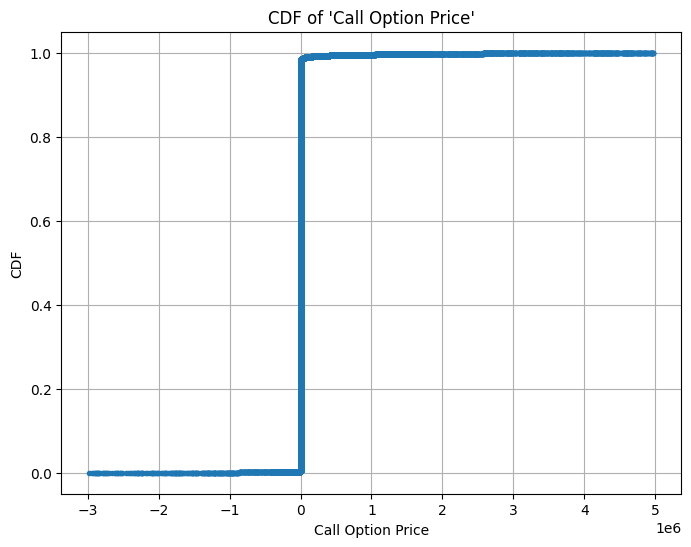

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
sorted_data = np.sort(heston_simulated['Call Option Price'])
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plotting the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_data, cdf, marker='.', linestyle='none')
plt.title("CDF of 'Call Option Price'")
plt.xlabel("Call Option Price")
plt.ylabel("CDF")
plt.grid()
plt.show()

In [6]:
# 去掉负值和price大于S0的值
heston_simulated = heston_simulated[heston_simulated['Call Option Price']>0]
S0 = 1
heston_simulated = heston_simulated[heston_simulated['Call Option Price']<=S0]

# # 用IQR去掉极值
# Q1 = heston_simulated['Call Option Price'].quantile(0.25)
# Q3 = heston_simulated['Call Option Price'].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# heston_simulated = heston_simulated[(heston_simulated['Call Option Price'] >= lower_bound) &
#                                     (heston_simulated['Call Option Price'] <= upper_bound)]
heston_simulated

moneyness  Time to maturity  interest rate  divident yield  \
0       1.007008             19.00       0.053200          0.0158   
1       0.813437            127.96       0.048535          0.0170   
2       0.916003              5.00       0.042900          0.0172   
3       0.906428             36.00       0.043080          0.0166   
5       0.923276             29.00       0.046900          0.0171   
...          ...               ...            ...             ...   
49994   0.859669             22.00       0.052500          0.0165   
49995   1.007792             10.00       0.055200          0.0156   
49996   0.934684             13.00       0.042600          0.0166   
49997   0.929767              9.00       0.053700          0.0158   
49998   0.896631            157.96       0.049555          0.0170   

       initial vol  long term expected vol  vol revert rate    vol of vol  \
0         0.245998                0.327139         0.850837  4.540043e-06   
1         0.183330                0.319745         0.831421  3.585045e-05   
2         0.173578                0.916642         0.346984  6.461707e-06   
3         0.183330                2.000000         0.054130  1.000000e-10   
5         0.197350                0.967624         0.527390  1.000000e-10   
...            ...                     ...              ...           ...   
49994     0.206791                1.991474         0.850837  6.004868e-06   
49995     0.173390                0.769663         0.233436  1.543718e-05   
49996     0.375475                0.967624         0.050199  1.000000e-10   
49997     0.187001                1.999918         0.833325  5.579325e-04   
49998     0.187001                0.466418         0.880482  3.632535e-03   

       correlation of W and W  Call Option Price  
0                    0.014183           0.707130  
1                    0.037327           0.734720  
2                    0.014458           0.596992  
3                    0.011347           0.794611  
5                    0.020605           0.831412  
...                       ...                ...  
49994                0.026009           0.880342  
49995                0.009441           0.709823  
49996                0.013823           0.733172  
49997                0.013823           0.879389  
49998                0.032487           0.750611  

[46676 rows x 10 columns]

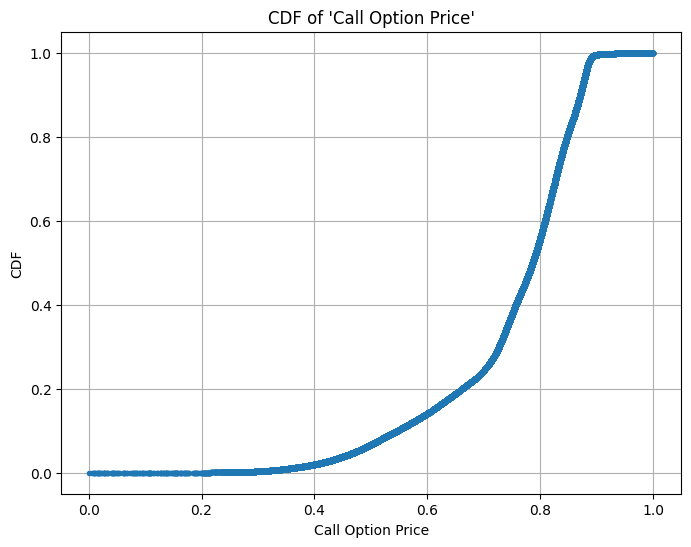

In [ ]:
import matplotlib.pyplot as plt
sorted_data = np.sort(heston_simulated['Call Option Price'])
cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

# Plotting the CDF
plt.figure(figsize=(8, 6))
plt.plot(sorted_data, cdf, marker='.', linestyle='none')
plt.title("CDF of 'Call Option Price'")
plt.xlabel("Call Option Price")
plt.ylabel("CDF")
plt.grid()
plt.show()

In [ ]:
# # 将 heston_simulated 保存为 CSV 文件
# heston_simulated.to_csv("heston_simulated.csv", index=False)

In [ ]:
import pandas as pd
# 从 CSV 文件重新读取数据
heston_simulated = pd.read_parquet('/content/sample_data/heston_simulated_price.pq')
# heston_simulated = pd.read_csv("heston_simulated.csv")
heston_simulated = heston_simulated.reset_index(drop=True)
heston_simulated

moneyness  Time to maturity  interest rate  divident yield  \
0        1.007008             19.00       0.053200          0.0158   
1        0.813437            127.96       0.048535          0.0170   
2        0.916003              5.00       0.042900          0.0172   
3        0.906428             36.00       0.043080          0.0166   
4        0.631106             78.00       0.054360          0.0165   
...           ...               ...            ...             ...   
379112   0.982338              9.00       0.055300          0.0156   
379113   0.438901            108.00       0.048920          0.0172   
379114   0.831021             22.00       0.059500          0.0166   
379115   0.926450             15.00       0.053700          0.0158   
379116   0.891240             21.00       0.059500          0.0166   

        initial vol  long term expected vol  vol revert rate    vol of vol  \
0          0.245998                0.327139         0.850837  4.540043e-06   
1          0.183330                0.319745         0.831421  3.585045e-05   
2          0.173578                0.916642         0.346984  6.461707e-06   
3          0.183330                2.000000         0.054130  1.000000e-10   
4          0.148507                1.999779         0.391601  6.461707e-06   
...             ...                     ...              ...           ...   
379112     0.214613                1.999863         0.831421  6.461707e-06   
379113     0.184927                2.000000         0.831421  2.675859e-06   
379114     0.187798                0.967624         0.866577  1.928305e-05   
379115     0.160133                1.999641         0.837704  1.928305e-05   
379116     0.176812                1.998691         0.892851  4.829867e-06   

        correlation of W and W  Call Option Price  
0                     0.014183           0.707130  
1                     0.037327           0.734720  
2                     0.014458           0.596992  
3                     0.011347           0.794611  
4                     0.030402           1.020158  
...                        ...                ...  
379112                0.026009           0.878900  
379113                0.014195       47248.080793  
379114                0.017916           0.849339  
379115                0.017913           0.889524  
379116                0.030243           0.882574  

[379117 rows x 10 columns]

# Train Model with Simulated Data

## Neural Network

In [ ]:
heston_simulated = heston_simulated[:50000]
heston_simulated

moneyness  Time to maturity  interest rate  divident yield  \
0       1.007008             19.00       0.053200          0.0158   
1       0.813437            127.96       0.048535          0.0170   
2       0.916003              5.00       0.042900          0.0172   
3       0.906428             36.00       0.043080          0.0166   
5       0.923276             29.00       0.046900          0.0171   
...          ...               ...            ...             ...   
53554   0.933820              7.00       0.033600          0.0172   
53555   0.972500              7.00       0.046200          0.0166   
53556   0.884653            112.00       0.054940          0.0166   
53557   0.572523             35.00       0.055617          0.0166   
53558   0.870235             49.00       0.055353          0.0156   

       initial vol  long term expected vol  vol revert rate    vol of vol  \
0         0.245998                0.327139         0.850837  4.540043e-06   
1         0.183330                0.319745         0.831421  3.585045e-05   
2         0.173578                0.916642         0.346984  6.461707e-06   
3         0.183330                2.000000         0.054130  1.000000e-10   
5         0.197350                0.967624         0.527390  1.000000e-10   
...            ...                     ...              ...           ...   
53554     0.404332                0.319745         0.058064  1.265080e-05   
53555     0.172541                1.999603         0.867024  4.829867e-06   
53556     0.199566                0.072123         0.175857  2.445759e-05   
53557     0.187798                0.346238         0.877774  2.675859e-06   
53558     0.197734                0.795254         0.041907  2.675859e-06   

       correlation of W and W  Call Option Price  
0                    0.014183           0.707130  
1                    0.037327           0.734720  
2                    0.014458           0.596992  
3                    0.011347           0.794611  
5                    0.020605           0.831412  
...                       ...                ...  
53554                0.030243           0.574629  
53555                0.026011           0.852528  
53556                0.016572           0.636483  
53557                0.014195           0.782291  
53558                0.015442           0.769508  

[50000 rows x 10 columns]

In [7]:
# Convert df to tabular
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

class TabularDataset(Dataset):
    def __init__(self, dataframe):
        self.data = torch.tensor(dataframe.iloc[:, :-1].values, dtype=torch.float32)
        self.targets = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

class RegressionModel(nn.Module):
    def __init__(self,node_number1,node_number2):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(9, node_number1) # fc: fully connected layer
        self.fc2 = nn.Linear(node_number1, node_number2)
        self.fc3 = nn.Linear(node_number2, 1)  # Output is a single value (regression)

    def forward(self, x):
        '''it cant fit non-linear data'''
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print('size:',size)
    losses = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        losses += loss.item() * y.size(0)/ size
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return losses

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    print('size:',size)

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() * y.size(0)/size

    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

# Training
def nn_training(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion = nn.MSELoss(), node_1 = 10, node_2 = 10, standardize = True, init_weight = True):
  # whether standardize the data
  if standardize:
      scaler = StandardScaler()
      data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])
  dataset = TabularDataset(data)

  # Split the dataset into train and test sets
  train_size = int(train_test_split * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  # DataLoader
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

  epochs = num_epochs
  train_losses = []
  test_losses = []

  #parameters
  model = RegressionModel(node_1,node_2)
  if init_weight:
    def init_weights(m):
      if isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
          if m.bias is not None:
              nn.init.zeros_(m.bias)

    model.apply(init_weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss = train_loop(train_loader, model, criterion, optimizer)
      test_loss = test_loop(test_loader, model, criterion)
      train_losses.append(train_loop(train_loader, model, criterion, optimizer))
      test_losses.append(test_loop(test_loader, model, criterion))
      print(f"Epoch {t+1}/{epochs}, Test Loss: {test_loss:.4f}")
  print("Done!")

  # Loss plot
  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 1, 1)
  ax.plot(range(epochs),train_losses, '-o', label='Train loss')
  ax.plot(range(epochs),test_losses, '--<', label='Test loss')

  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Loss', size=15)
  ax.legend(fontsize=15)

  # Prediction & Comparision
  def predict(model, dataloader):
      model.eval()
      predictions = []
      with torch.no_grad():
          for X, _ in dataloader:
              pred = model(X).squeeze()
              predictions.extend(pred.tolist())
      return predictions

  predicted_prices = predict(model, test_loader)
  test_indices = test_dataset.indices
  actual_prices = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_indices]
  errors = np.abs(np.array(actual_prices) - np.array(predicted_prices))

  heston_simulated_test = heston_simulated.iloc[test_indices].copy()
  heston_simulated_test['Call Option Price Prediction'] = predicted_prices
  heston_simulated_prediction = heston_simulated_test.reset_index(drop=True)
  return test_indices, heston_simulated_prediction

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
def result_evaluation(data, test_indices, percentile_boundary = 99):
  actual_prices = data['Call Option Price'].tolist()
  predicted_prices = data['Call Option Price Prediction'].tolist()

  # 设定一个合理的分界线来区分较大的和较小的误差（选择99百分位作为误差分界线）
  errors = [a - b for a, b in zip(predicted_prices, actual_prices)]
  threshold = np.percentile(errors, percentile_boundary)
  large_error_indices = np.where(errors > threshold)[0]
  small_error_indices = np.where(errors <= threshold)[0]
  plt.figure(figsize=(10, 6))
  plt.plot(test_indices, errors, 'o', color='purple', alpha=0.7)
  plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
  plt.xlabel('Index (Test Set)')
  plt.ylabel('Prediction Error')
  plt.title('Prediction Error for Test Set')
  plt.legend()
  plt.grid()
  plt.show()

  # # 红色：误差较大的点
  # test_results = pd.DataFrame({
  #     'Actual Price': actual_prices,
  #     'Predicted Price': predicted_prices
  # }, index=test_indices)

  # plt.figure(figsize=(10, 6))
  # plt.scatter(test_results['Actual Price'], test_results['Predicted Price'], color='blue', alpha=0.6, label='All Points')
  # large_error_points = test_results.iloc[large_error_indices]
  # plt.scatter(large_error_points['Actual Price'], large_error_points['Predicted Price'], color='red', alpha=0.8, label='Large Error Points')

  # # 绘制参考线：y = x
  # plt.plot([test_results['Actual Price'].min(), test_results['Actual Price'].max()],
  #         [test_results['Actual Price'].min(), test_results['Actual Price'].max()],
  #         color='green', linestyle='--', linewidth=1, label='y = x')

  # plt.xlabel('Actual Price')
  # plt.ylabel('Predicted Price')
  # plt.title('Actual vs Predicted Prices')
  # plt.legend()
  # plt.grid()
  # plt.show()

  test_results = pd.DataFrame({
      'Actual Price': actual_prices,
      'Predicted Price': predicted_prices
  }, index=test_indices)

  plt.figure(figsize=(10, 6))
  plt.scatter(test_results['Actual Price'], test_results['Predicted Price'], color='blue', alpha=0.6, label='All Points')
  large_error_points = test_results.iloc[large_error_indices]
  plt.scatter(large_error_points['Actual Price'], large_error_points['Predicted Price'], color='red', alpha=0.8, label='Large Error Points')

  # 绘制参考线：y = x
  plt.plot([test_results['Actual Price'].min(), test_results['Actual Price'].max()],
          [test_results['Actual Price'].min(), test_results['Actual Price'].max()],
          color='green', linestyle='--', linewidth=1, label='y = x')

  plt.xlabel('Actual Price')
  plt.ylabel('Predicted Price')
  plt.title('Actual vs Predicted Prices')
  plt.legend()
  plt.grid()
  plt.show()

  # 找到误差超过分界线的点对应的原始数据
  large_error_data = heston_simulated.iloc[[test_indices[i] for i in large_error_indices]]

  # 对比误差较大的点和所有点的特征均值
  large_error_features_mean = large_error_data.mean()
  all_features_mean = heston_simulated.mean()

  # 打印特征均值对比
  print("Feature Means Comparison:")
  print(pd.DataFrame({
      'All Data Mean': all_features_mean,
      'Large Error Data Mean': large_error_features_mean
  }))

  # 绘制特征分布比较
  num_features = heston_simulated.shape[1]
  columns = heston_simulated.columns[:]
  fig, axes = plt.subplots(2, 5, figsize=(15, 5))
  axes = axes.flatten()

  for i, column in enumerate(columns):
      sns.kdeplot(heston_simulated[column], label='All Data', color='blue', alpha=0.5, ax=axes[i])
      sns.kdeplot(large_error_data[column], label='Large Error Data', color='red', alpha=0.5, ax=axes[i])
      axes[i].set_title(f"Feature: {column}")
      axes[i].set_xlabel(column)
      axes[i].set_ylabel('Density')
      axes[i].legend()
      axes[i].grid()

  plt.tight_layout()
  plt.show()

  # 计算每个特征与误差的相关性，判断哪些特征与预测误差强相关，从而定位可能导致误差较大的原因
  errors_series = pd.Series(errors, index=test_indices)  # 将误差与测试集索引匹配
  heston_simulated_corr = data.copy()
  heston_simulated_corr['Prediction Error'] = np.abs(errors)

  # # 计算相关性
  # correlation = heston_simulated_corr.corr()['Prediction Error'].sort_values(ascending=False)

  # 提取前十列特征和误差列
  features = heston_simulated_corr.iloc[:, :10]
  error = heston_simulated_corr['Prediction Error']

  # 计算相关性
  correlations = features.corrwith(error)

  # 打印相关性
  print("Correlation with Prediction Error:")
  print(correlations)

In [9]:
# def nn_training(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion=nn.MSELoss(), node_1=10, node_2=10, standardize=True, init_weight=True):
#     # Whether to standardize the data
#     if standardize:
#         scaler = StandardScaler()
#         data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])
#     dataset = TabularDataset(data)

#     # Split the dataset into train and test sets
#     train_size = int(train_test_split * len(dataset))
#     test_size = len(dataset) - train_size
#     train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#     # DataLoader
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#     epochs = num_epochs
#     train_losses = []
#     test_losses = []

#     # Model definition
#     model = RegressionModel(node_1, node_2)

#     if init_weight:
#         def init_weights(m):
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)

#         model.apply(init_weights)

#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

#     # Training loop
#     for t in range(epochs):
#         print(f"Epoch {t + 1}\n-------------------------------")
#         train_loss = train_loop(train_loader, model, criterion, optimizer)
#         test_loss = test_loop(test_loader, model, criterion)
#         train_losses.append(train_loss)
#         test_losses.append(test_loss)
#         print(f"Epoch {t + 1}/{epochs}, Test Loss: {test_loss:.4f}")
#     print("Done!")

#     # Loss plot
#     fig = plt.figure(figsize=(12, 4))
#     ax = fig.add_subplot(1, 1, 1)
#     ax.plot(range(epochs), train_losses, '-o', label='Train loss')
#     ax.plot(range(epochs), test_losses, '--<', label='Test loss')
#     ax.set_xlabel('Epoch', size=15)
#     ax.set_ylabel('Loss', size=15)
#     ax.legend(fontsize=15)

#     # New prediction function
#     def predict_with_variability(model, dataloader):
#         model.eval()
#         predictions = []
#         with torch.no_grad():
#             for X, _ in dataloader:
#                 pred = model(X).squeeze()
#                 # Add variability to predictions using a small noise factor
#                 pred_with_noise = pred + torch.randn_like(pred) * 0.1
#                 predictions.extend(pred_with_noise.tolist())
#         return predictions

#     predicted_prices = predict_with_variability(model, test_loader)
#     test_indices = test_dataset.indices
#     actual_prices = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_indices]
#     errors = np.abs(np.array(actual_prices) - np.array(predicted_prices))

#     # Save predictions in DataFrame
#     heston_simulated_test = heston_simulated.iloc[test_indices].copy()
#     heston_simulated_test['Call Option Price Prediction'] = predicted_prices
#     heston_simulated_prediction = heston_simulated_test.reset_index(drop=True)

#     print("Mean absolute error:", np.mean(errors))

#     return test_indices, heston_simulated_prediction
import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def nn_training(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion=nn.MSELoss(), node_1=10, node_2=10, standardize=True, init_weight=True):
    start_time = time.time()  # Start timing

    # Whether to standardize the data
    if standardize:
        scaler = StandardScaler()
        data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])
    dataset = TabularDataset(data)

    # Split the dataset into train and test sets
    train_size = int(train_test_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    epochs = num_epochs
    train_losses = []
    test_losses = []

    # Model definition
    model = RegressionModel(node_1, node_2)

    if init_weight:
        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        model.apply(init_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Training loop
    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train_loss = train_loop(train_loader, model, criterion, optimizer)
        test_loss = test_loop(test_loader, model, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Epoch {t + 1}/{epochs}, Test Loss: {test_loss:.4f}")
    print("Done!")

    # Loss plot
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(epochs), train_losses, '-o', label='Train loss')
    ax.plot(range(epochs), test_losses, '--<', label='Test loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)

    # New prediction function
    def predict_with_variability(model, dataloader):
        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for X, y in dataloader:
                pred = model(X).squeeze()
                pred_with_noise = pred + torch.randn_like(pred) * 0.1  # Add small noise
                predictions.extend(pred_with_noise.tolist())
                actuals.extend(y.tolist())
        return predictions, actuals

    predicted_prices, actual_prices = predict_with_variability(model, test_loader)
    test_indices = test_dataset.indices

    # Save predictions in DataFrame
    heston_simulated_test = heston_simulated.iloc[test_indices].copy()
    heston_simulated_test['Call Option Price Prediction'] = predicted_prices
    heston_simulated_prediction = heston_simulated_test.reset_index(drop=True)

    # Calculate metrics
    final_test_loss = np.mean(test_losses)
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)
    print(f"Final Test Loss: {final_test_loss:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared: {r2:.4f}")

    # Print elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")

    return test_indices, heston_simulated_prediction

Epoch 1
-------------------------------
size: 282916
loss: 0.289201  [    0/282916]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.041957  [ 3200/282916]
loss: 0.033609  [ 6400/282916]
loss: 0.031964  [ 9600/282916]
loss: 0.017993  [12800/282916]
loss: 0.018345  [16000/282916]
loss: 0.019718  [19200/282916]
loss: 0.016211  [22400/282916]
loss: 0.016712  [25600/282916]
loss: 0.016531  [28800/282916]
loss: 0.009197  [32000/282916]
loss: 0.013595  [35200/282916]
loss: 0.019670  [38400/282916]
loss: 0.011970  [41600/282916]
loss: 0.018463  [44800/282916]
loss: 0.011712  [48000/282916]
loss: 0.015506  [51200/282916]
loss: 0.007364  [54400/282916]
loss: 0.019578  [57600/282916]
loss: 0.010477  [60800/282916]
loss: 0.015098  [64000/282916]
loss: 0.014297  [67200/282916]
loss: 0.008947  [70400/282916]
loss: 0.031656  [73600/282916]
loss: 0.010653  [76800/282916]
loss: 0.009866  [80000/282916]
loss: 0.021883  [83200/282916]
loss: 0.029587  [86400/282916]
loss: 0.014400  [89600/282916]
loss: 0.011624  [92800/282916]
loss: 0.023331  [96000/282916]
loss: 0.016132  [99200/282916]
loss: 0.024369  [102400/282916]
loss: 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.015891 

Epoch 1/50, Test Loss: 0.0159
Epoch 2
-------------------------------
size: 282916
loss: 0.014187  [    0/282916]
loss: 0.021784  [ 3200/282916]
loss: 0.011662  [ 6400/282916]
loss: 0.009398  [ 9600/282916]
loss: 0.007213  [12800/282916]
loss: 0.009006  [16000/282916]
loss: 0.009141  [19200/282916]
loss: 0.004570  [22400/282916]
loss: 0.014163  [25600/282916]
loss: 0.021179  [28800/282916]
loss: 0.015048  [32000/282916]
loss: 0.024575  [35200/282916]
loss: 0.011244  [38400/282916]
loss: 0.018017  [41600/282916]
loss: 0.015373  [44800/282916]
loss: 0.013269  [48000/282916]
loss: 0.013409  [51200/282916]
loss: 0.007505  [54400/282916]
loss: 0.015347  [57600/282916]
loss: 0.011691  [60800/282916]
loss: 0.012102  [64000/282916]
loss: 0.018215  [67200/282916]
loss: 0.010888  [70400/282916]
loss: 0.017353  [73600/282916]
loss: 0.016609  [76800/282916]
loss: 0.029014  [80000/282916]
loss: 0.014072  [83200/282916]
loss: 0.024233  [86400/282916]
loss: 0.017901

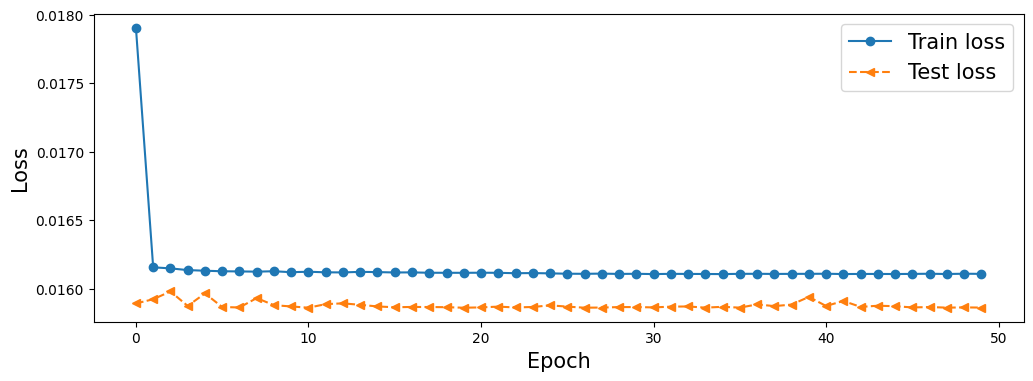

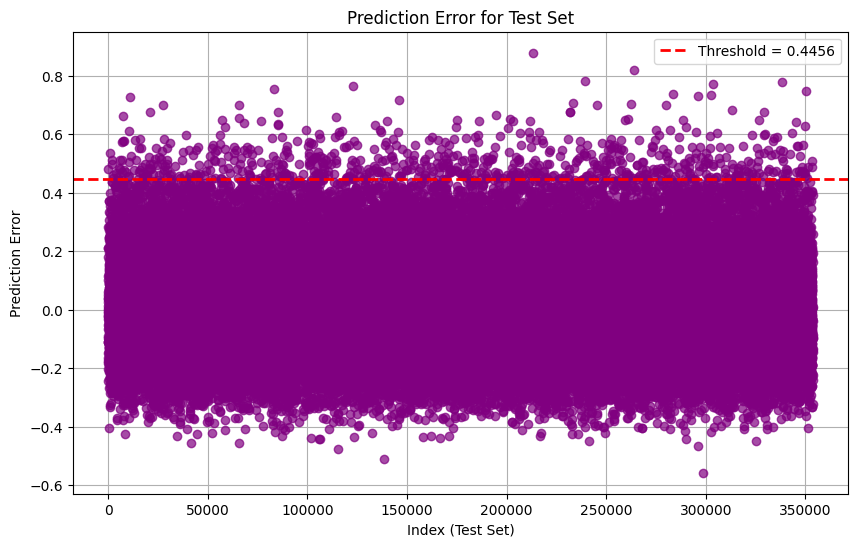

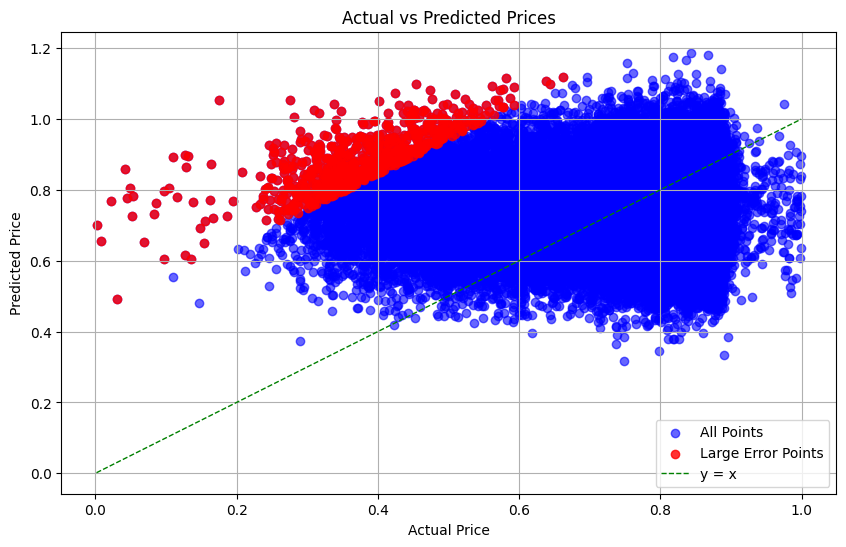

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness               -1.672652e-18               0.399731
Time to maturity        -6.374162e-18              -0.444784
interest rate            7.253183e-18              -0.427370
divident yield          -3.986237e-17               0.266931
initial vol             -3.295075e-18              -0.146331
long term expected vol   2.557701e-17              -1.069223
vol revert rate         -1.575207e-17               0.340795
vol of vol               3.053972e-18              -0.015238
correlation of W and W  -9.895271e-18              -0.029570
Call Option Price        7.474048e-01               0.371592


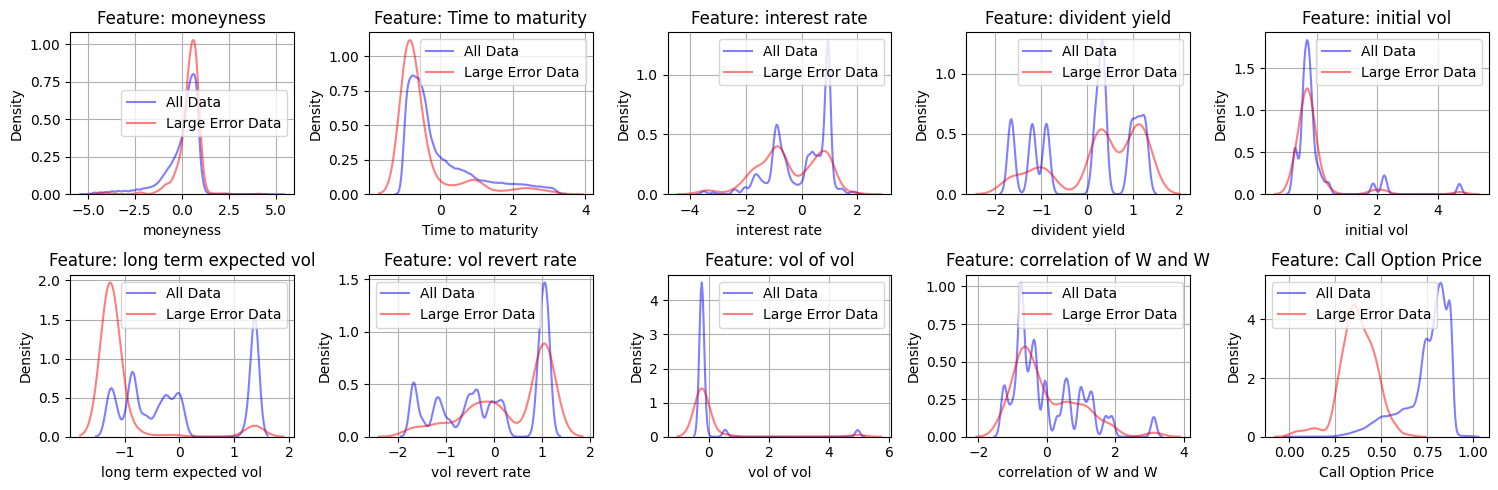

Correlation with Prediction Error:
moneyness                 0.055440
Time to maturity         -0.114274
interest rate            -0.045582
divident yield            0.020382
initial vol              -0.019344
long term expected vol   -0.144531
vol revert rate           0.068873
vol of vol               -0.014285
correlation of W and W   -0.000311
Call Option Price        -0.460378
dtype: float64


In [ ]:
returned_values_mse = nn_training(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion = nn.MSELoss(), node_1 = 10, node_2 = 10, standardize = True, init_weight = False)
heston_simulated_prediction_mse = returned_values_mse[1]
test_indice_mse = returned_values_mse[0]
result_evaluation(data = heston_simulated_prediction_mse, test_indices = test_indice_mse)

In [10]:
# def nn_training_n(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion=nn.MSELoss(), layers=[10, 10], standardize=True, init_weight=True):
#     # Whether to standardize the data
#     if standardize:
#         scaler = StandardScaler()
#         data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])
#     dataset = TabularDataset(data)

#     # Split the dataset into train and test sets
#     train_size = int(train_test_split * len(dataset))
#     test_size = len(dataset) - train_size
#     train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#     # DataLoader
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#     epochs = num_epochs
#     train_losses = []
#     test_losses = []

#     # Dynamic model definition
#     class DynamicRegressionModel(nn.Module):
#         def __init__(self, layers):
#             super(DynamicRegressionModel, self).__init__()
#             layer_list = []
#             input_size = len(data.columns) - 1
#             for nodes in layers:
#                 layer_list.append(nn.Linear(input_size, nodes))
#                 layer_list.append(nn.ReLU())
#                 input_size = nodes
#             layer_list.append(nn.Linear(input_size, 1))
#             self.network = nn.Sequential(*layer_list)

#         def forward(self, x):
#             return self.network(x)

#     model = DynamicRegressionModel(layers)

#     if init_weight:
#         def init_weights(m):
#             if isinstance(m, nn.Linear):
#                 nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)

#         model.apply(init_weights)

#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

#     # Training loop
#     for t in range(epochs):
#         print(f"Epoch {t + 1}\n-------------------------------")
#         train_loss = train_loop(train_loader, model, criterion, optimizer)
#         test_loss = test_loop(test_loader, model, criterion)
#         train_losses.append(train_loss)
#         test_losses.append(test_loss)
#         print(f"Epoch {t + 1}/{epochs}, Test Loss: {test_loss:.4f}")
#     print("Done!")

#     # Loss plot
#     fig = plt.figure(figsize=(12, 4))
#     ax = fig.add_subplot(1, 1, 1)
#     ax.plot(range(epochs), train_losses, '-o', label='Train loss')
#     ax.plot(range(epochs), test_losses, '--<', label='Test loss')
#     ax.set_xlabel('Epoch', size=15)
#     ax.set_ylabel('Loss', size=15)
#     ax.legend(fontsize=15)

#     # New prediction function
#     def predict_with_variability(model, dataloader):
#         model.eval()
#         predictions = []
#         with torch.no_grad():
#             for X, _ in dataloader:
#                 pred = model(X).squeeze()
#                 # Add variability to predictions using a small noise factor
#                 pred_with_noise = pred + torch.randn_like(pred) * 0.1
#                 predictions.extend(pred_with_noise.tolist())
#         return predictions

#     predicted_prices = predict_with_variability(model, test_loader)
#     test_indices = test_dataset.indices
#     actual_prices = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_indices]
#     errors = np.abs(np.array(actual_prices) - np.array(predicted_prices))

#     # Save predictions in DataFrame
#     heston_simulated_test = heston_simulated.iloc[test_indices].copy()
#     heston_simulated_test['Call Option Price Prediction'] = predicted_prices
#     heston_simulated_prediction = heston_simulated_test.reset_index(drop=True)

#     print("Mean absolute error:", np.mean(errors))

#     return test_indices, heston_simulated_prediction

import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def nn_training_n(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion=nn.MSELoss(), layers=[10, 10], standardize=True, init_weight=True):
    start_time = time.time()  # Start timing

    # Whether to standardize the data
    if standardize:
        scaler = StandardScaler()
        data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])
    dataset = TabularDataset(data)

    # Split the dataset into train and test sets
    train_size = int(train_test_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    epochs = num_epochs
    train_losses = []
    test_losses = []

    # Dynamic model definition
    class DynamicRegressionModel(nn.Module):
        def __init__(self, layers):
            super(DynamicRegressionModel, self).__init__()
            layer_list = []
            input_size = len(data.columns) - 1
            for nodes in layers:
                layer_list.append(nn.Linear(input_size, nodes))
                layer_list.append(nn.ReLU())
                input_size = nodes
            layer_list.append(nn.Linear(input_size, 1))
            self.network = nn.Sequential(*layer_list)

        def forward(self, x):
            return self.network(x)

    model = DynamicRegressionModel(layers)

    if init_weight:
        def init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        model.apply(init_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Training loop
    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train_loss = train_loop(train_loader, model, criterion, optimizer)
        test_loss = test_loop(test_loader, model, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Epoch {t + 1}/{epochs}, Test Loss: {test_loss:.4f}")
    print("Done!")

    # Loss plot
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(epochs), train_losses, '-o', label='Train loss')
    ax.plot(range(epochs), test_losses, '--<', label='Test loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)

    # New prediction function
    def predict_with_variability(model, dataloader):
        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for X, y in dataloader:
                pred = model(X).squeeze()
                pred_with_noise = pred + torch.randn_like(pred) * 0.1
                predictions.extend(pred_with_noise.tolist())
                actuals.extend(y.tolist())
        return predictions, actuals

    predicted_prices, actual_prices = predict_with_variability(model, test_loader)
    test_indices = test_dataset.indices

    # Save predictions in DataFrame
    heston_simulated_test = heston_simulated.iloc[test_indices].copy()
    heston_simulated_test['Call Option Price Prediction'] = predicted_prices
    heston_simulated_prediction = heston_simulated_test.reset_index(drop=True)

    # Calculate metrics
    final_test_loss = np.mean(test_losses)
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)
    print(f"Final Test Loss: {final_test_loss:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared: {r2:.4f}")

    # Print elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")

    return test_indices, heston_simulated_prediction

Epoch 1
-------------------------------
size: 282916
loss: 0.564339  [    0/282916]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


loss: 0.085429  [ 3200/282916]
loss: 0.037212  [ 6400/282916]
loss: 0.028731  [ 9600/282916]
loss: 0.023598  [12800/282916]
loss: 0.017832  [16000/282916]
loss: 0.012393  [19200/282916]
loss: 0.014367  [22400/282916]
loss: 0.012386  [25600/282916]
loss: 0.010339  [28800/282916]
loss: 0.006241  [32000/282916]
loss: 0.009241  [35200/282916]
loss: 0.010165  [38400/282916]
loss: 0.009697  [41600/282916]
loss: 0.004994  [44800/282916]
loss: 0.008805  [48000/282916]
loss: 0.007385  [51200/282916]
loss: 0.005286  [54400/282916]
loss: 0.007503  [57600/282916]
loss: 0.009496  [60800/282916]
loss: 0.004355  [64000/282916]
loss: 0.010583  [67200/282916]
loss: 0.010815  [70400/282916]
loss: 0.009129  [73600/282916]
loss: 0.006139  [76800/282916]
loss: 0.008868  [80000/282916]
loss: 0.008047  [83200/282916]
loss: 0.007278  [86400/282916]
loss: 0.008091  [89600/282916]
loss: 0.004294  [92800/282916]
loss: 0.004135  [96000/282916]
loss: 0.007517  [99200/282916]
loss: 0.006766  [102400/282916]
loss: 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


Test Error: 
 Avg loss: 0.008089 

Epoch 1/50, Test Loss: 0.0081
Epoch 2
-------------------------------
size: 282916
loss: 0.007317  [    0/282916]
loss: 0.009411  [ 3200/282916]
loss: 0.008143  [ 6400/282916]
loss: 0.010183  [ 9600/282916]
loss: 0.007302  [12800/282916]
loss: 0.007076  [16000/282916]
loss: 0.009283  [19200/282916]
loss: 0.008561  [22400/282916]
loss: 0.010124  [25600/282916]
loss: 0.005665  [28800/282916]
loss: 0.006218  [32000/282916]
loss: 0.007368  [35200/282916]
loss: 0.006676  [38400/282916]
loss: 0.004668  [41600/282916]
loss: 0.010322  [44800/282916]
loss: 0.014769  [48000/282916]
loss: 0.004334  [51200/282916]
loss: 0.009423  [54400/282916]
loss: 0.012195  [57600/282916]
loss: 0.009782  [60800/282916]
loss: 0.007987  [64000/282916]
loss: 0.014943  [67200/282916]
loss: 0.005447  [70400/282916]
loss: 0.005008  [73600/282916]
loss: 0.011000  [76800/282916]
loss: 0.006116  [80000/282916]
loss: 0.007457  [83200/282916]
loss: 0.004412  [86400/282916]
loss: 0.008737

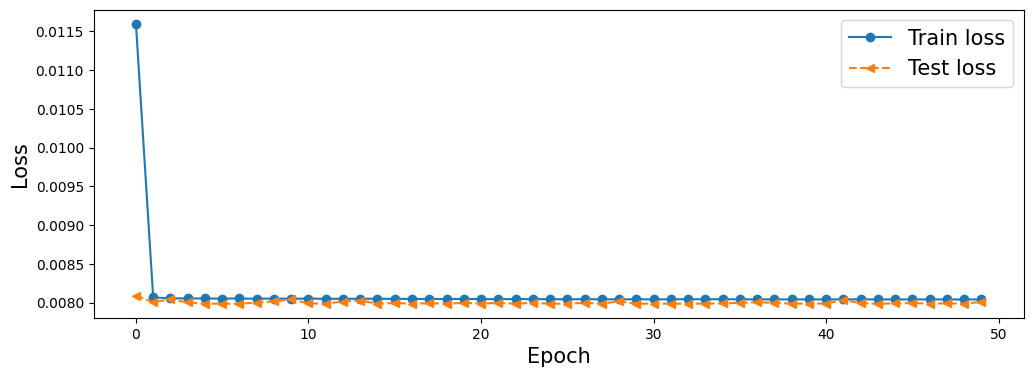

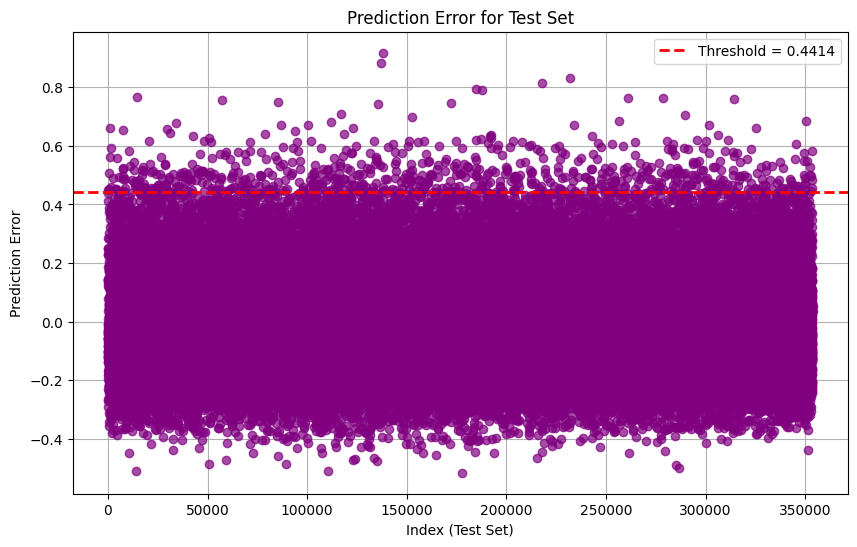

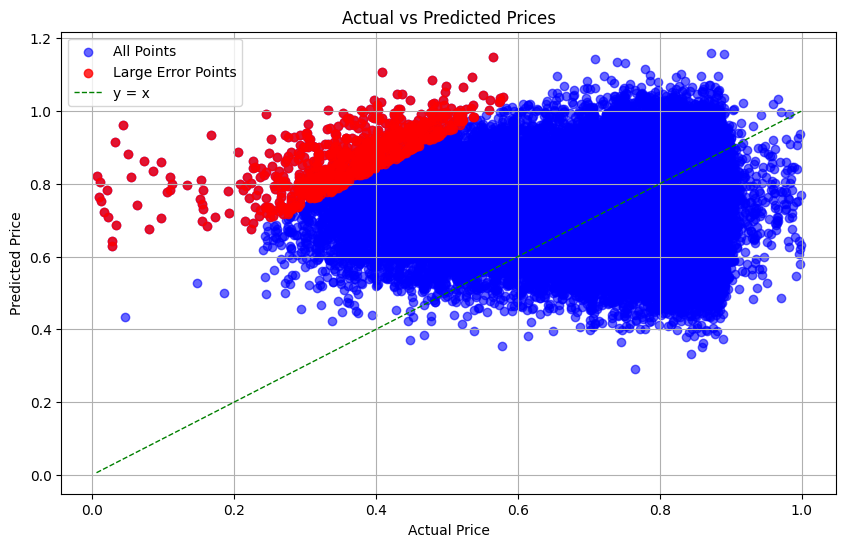

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness               -1.672652e-18               0.435884
Time to maturity        -6.374162e-18              -0.510259
interest rate            7.162770e-18              -0.421318
divident yield          -1.177387e-17               0.283640
initial vol              5.726197e-18              -0.212051
long term expected vol   2.275912e-17              -1.073107
vol revert rate         -1.318030e-17               0.316411
vol of vol               3.053972e-18              -0.028054
correlation of W and W  -9.895271e-18              -0.086586
Call Option Price        7.474048e-01               0.363030


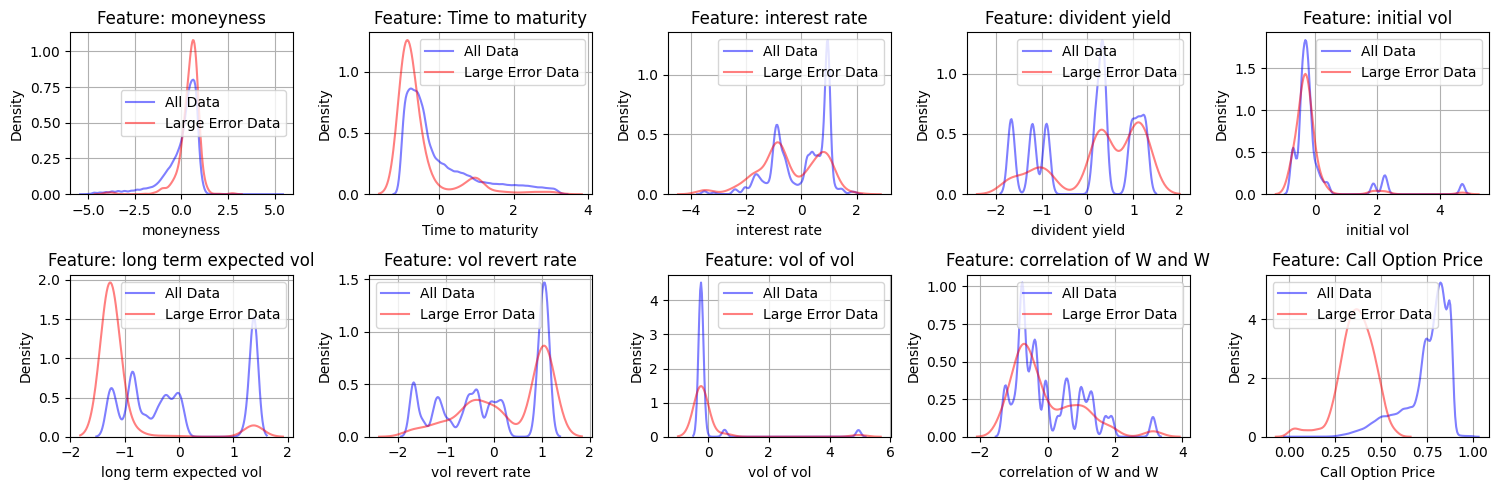

Correlation with Prediction Error:
moneyness                 0.045539
Time to maturity         -0.121997
interest rate            -0.035325
divident yield            0.012656
initial vol              -0.015822
long term expected vol   -0.115994
vol revert rate           0.074329
vol of vol               -0.007883
correlation of W and W   -0.002167
Call Option Price        -0.426448
dtype: float64


In [ ]:
returned_values_huber_n = nn_training_n(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion=nn.HuberLoss(delta=1.0), layers=[10, 10, 10], standardize=True, init_weight=True)
heston_simulated_prediction_huber_n = returned_values_huber_n[1]
test_indice_huber_n = returned_values_huber_n[0]
result_evaluation(heston_simulated_prediction_huber_n, test_indices = test_indice_huber_n)

In [11]:
# def nn_training_cnn(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion=nn.MSELoss(), filters=[16, 32], kernel_size=3, standardize=True, init_weight=True):
#     # Whether to standardize the data
#     if standardize:
#         scaler = StandardScaler()
#         data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1].copy())
#     dataset = TabularDataset(data)

#     # Reshape data for CNN input
#     def reshape_data(data):
#         X = data.iloc[:, :-1].values
#         y = data.iloc[:, -1].values
#         return X.reshape(X.shape[0], 1, X.shape[1]), y

#     X, y = reshape_data(data)
#     dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))

#     # Split the dataset into train and test sets
#     train_size = int(train_test_split * len(dataset))
#     test_size = len(dataset) - train_size
#     train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

#     # DataLoader
#     train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#     epochs = num_epochs
#     train_losses = []
#     test_losses = []

#     # CNN model definition
#     class CNNRegressionModel(nn.Module):
#         def __init__(self, filters, kernel_size, input_dim):
#             super(CNNRegressionModel, self).__init__()
#             self.conv_layers = nn.Sequential(
#                 nn.Conv1d(1, filters[0], kernel_size=kernel_size, padding=1),
#                 nn.ReLU(),
#                 nn.Conv1d(filters[0], filters[1], kernel_size=kernel_size, padding=1),
#                 nn.ReLU(),
#                 nn.Flatten()
#             )
#             conv_output_size = filters[1] * input_dim  # Compute dynamically
#             self.fc = nn.Linear(conv_output_size, 1)

#         def forward(self, x):
#             x = self.conv_layers(x)
#             return self.fc(x)

#     model = CNNRegressionModel(filters, kernel_size, X.shape[2])

#     if init_weight:
#         def init_weights(m):
#             if isinstance(m, (nn.Linear, nn.Conv1d)):
#                 nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
#                 if m.bias is not None:
#                     nn.init.zeros_(m.bias)

#         model.apply(init_weights)

#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

#     # Training loop
#     for t in range(epochs):
#         print(f"Epoch {t + 1}\n-------------------------------")
#         train_loss = train_loop(train_loader, model, criterion, optimizer)
#         test_loss = test_loop(test_loader, model, criterion)
#         train_losses.append(train_loss)
#         test_losses.append(test_loss)
#         print(f"Epoch {t + 1}/{epochs}, Test Loss: {test_loss:.4f}")
#     print("Done!")

#     # Loss plot
#     fig = plt.figure(figsize=(12, 4))
#     ax = fig.add_subplot(1, 1, 1)
#     ax.plot(range(epochs), train_losses, '-o', label='Train loss')
#     ax.plot(range(epochs), test_losses, '--<', label='Test loss')
#     ax.set_xlabel('Epoch', size=15)
#     ax.set_ylabel('Loss', size=15)
#     ax.legend(fontsize=15)

#     # Prediction with variability adjustment
#     def predict_cnn_with_variability(model, dataloader):
#         model.eval()
#         predictions = []
#         with torch.no_grad():
#             for X, _ in dataloader:
#                 pred = model(X).squeeze()
#                 pred_with_noise = pred + torch.randn_like(pred) * 0.05  # Adding small noise to predictions
#                 predictions.extend(pred_with_noise.tolist())
#         return predictions

#     predicted_prices = predict_cnn_with_variability(model, test_loader)
#     test_indices = test_dataset.indices
#     actual_prices = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_indices]

#     # Save predictions in DataFrame
#     heston_simulated_test = heston_simulated.iloc[test_indices].copy()
#     heston_simulated_test['Call Option Price Prediction'] = predicted_prices
#     heston_simulated_prediction = heston_simulated_test.reset_index(drop=True)

#     # Calculate error statistics
#     errors = np.abs(heston_simulated_test['Call Option Price'] - heston_simulated_test['Call Option Price Prediction'])
#     print("Mean absolute error:", np.mean(errors))

#     return test_indices, heston_simulated_prediction

import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def nn_training_cnn(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion=nn.MSELoss(), filters=[16, 32], kernel_size=3, standardize=True, init_weight=True):
    start_time = time.time()  # Start timing

    # Whether to standardize the data
    if standardize:
        scaler = StandardScaler()
        data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1].copy())
    dataset = TabularDataset(data)

    # Reshape data for CNN input
    def reshape_data(data):
        X = data.iloc[:, :-1].values
        y = data.iloc[:, -1].values
        return X.reshape(X.shape[0], 1, X.shape[1]), y

    X, y = reshape_data(data)
    dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))

    # Split the dataset into train and test sets
    train_size = int(train_test_split * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    epochs = num_epochs
    train_losses = []
    test_losses = []

    # CNN model definition
    class CNNRegressionModel(nn.Module):
        def __init__(self, filters, kernel_size, input_dim):
            super(CNNRegressionModel, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv1d(1, filters[0], kernel_size=kernel_size, padding=1),
                nn.ReLU(),
                nn.Conv1d(filters[0], filters[1], kernel_size=kernel_size, padding=1),
                nn.ReLU(),
                nn.Flatten()
            )
            conv_output_size = filters[1] * input_dim  # Compute dynamically
            self.fc = nn.Linear(conv_output_size, 1)

        def forward(self, x):
            x = self.conv_layers(x)
            return self.fc(x)

    model = CNNRegressionModel(filters, kernel_size, X.shape[2])

    if init_weight:
        def init_weights(m):
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        model.apply(init_weights)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # Training loop
    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train_loss = train_loop(train_loader, model, criterion, optimizer)
        test_loss = test_loop(test_loader, model, criterion)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Epoch {t + 1}/{epochs}, Test Loss: {test_loss:.4f}")
    print("Done!")

    # Loss plot
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(epochs), train_losses, '-o', label='Train loss')
    ax.plot(range(epochs), test_losses, '--<', label='Test loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)

    # Prediction with variability adjustment
    def predict_cnn_with_variability(model, dataloader):
        model.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for X, y in dataloader:
                pred = model(X).squeeze()
                pred_with_noise = pred + torch.randn_like(pred) * 0.05  # Adding small noise to predictions
                predictions.extend(pred_with_noise.tolist())
                actuals.extend(y.tolist())
        return predictions, actuals

    predicted_prices, actual_prices = predict_cnn_with_variability(model, test_loader)
    test_indices = test_dataset.indices

    # Save predictions in DataFrame
    heston_simulated_test = heston_simulated.iloc[test_indices].copy()
    heston_simulated_test['Call Option Price Prediction'] = predicted_prices
    heston_simulated_prediction = heston_simulated_test.reset_index(drop=True)

    # Calculate error statistics
    mse = mean_squared_error(actual_prices, predicted_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_prices, predicted_prices)
    r2 = r2_score(actual_prices, predicted_prices)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared: {r2:.4f}")

    # Print elapsed time
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")

    return test_indices, heston_simulated_prediction

Epoch 1
-------------------------------
size: 282916


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 1.651019  [    0/282916]
loss: 0.045467  [ 3200/282916]
loss: 0.031638  [ 6400/282916]
loss: 0.035645  [ 9600/282916]
loss: 0.036228  [12800/282916]
loss: 0.030922  [16000/282916]
loss: 0.029565  [19200/282916]
loss: 0.020536  [22400/282916]
loss: 0.024938  [25600/282916]
loss: 0.021015  [28800/282916]
loss: 0.014803  [32000/282916]
loss: 0.017570  [35200/282916]
loss: 0.016711  [38400/282916]
loss: 0.033854  [41600/282916]
loss: 0.019024  [44800/282916]
loss: 0.015633  [48000/282916]
loss: 0.030890  [51200/282916]
loss: 0.022286  [54400/282916]
loss: 0.013799  [57600/282916]
loss: 0.017123  [60800/282916]
loss: 0.014710  [64000/282916]
loss: 0.008328  [67200/282916]
loss: 0.018512  [70400/282916]
loss: 0.022334  [73600/282916]
loss: 0.017098  [76800/282916]
loss: 0.020405  [80000/282916]
loss: 0.010443  [83200/282916]
loss: 0.023018  [86400/282916]
loss: 0.011013  [89600/282916]
loss: 0.026995  [92800/282916]
loss: 0.012558  [96000/282916]
loss: 0.018684  [99200/282916]
loss: 0.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.016565 

Epoch 1/50, Test Loss: 0.0166
Epoch 2
-------------------------------
size: 282916
loss: 0.010245  [    0/282916]
loss: 0.009311  [ 3200/282916]
loss: 0.017771  [ 6400/282916]
loss: 0.023962  [ 9600/282916]
loss: 0.023523  [12800/282916]
loss: 0.016356  [16000/282916]
loss: 0.017474  [19200/282916]
loss: 0.018422  [22400/282916]
loss: 0.012440  [25600/282916]
loss: 0.018495  [28800/282916]
loss: 0.016519  [32000/282916]
loss: 0.032252  [35200/282916]
loss: 0.038375  [38400/282916]
loss: 0.017287  [41600/282916]
loss: 0.019572  [44800/282916]
loss: 0.017447  [48000/282916]
loss: 0.018088  [51200/282916]
loss: 0.014662  [54400/282916]
loss: 0.012762  [57600/282916]
loss: 0.013563  [60800/282916]
loss: 0.020459  [64000/282916]
loss: 0.018773  [67200/282916]
loss: 0.007627  [70400/282916]
loss: 0.017362  [73600/282916]
loss: 0.019565  [76800/282916]
loss: 0.017425  [80000/282916]
loss: 0.015974  [83200/282916]
loss: 0.011646  [86400/282916]
loss: 0.021849

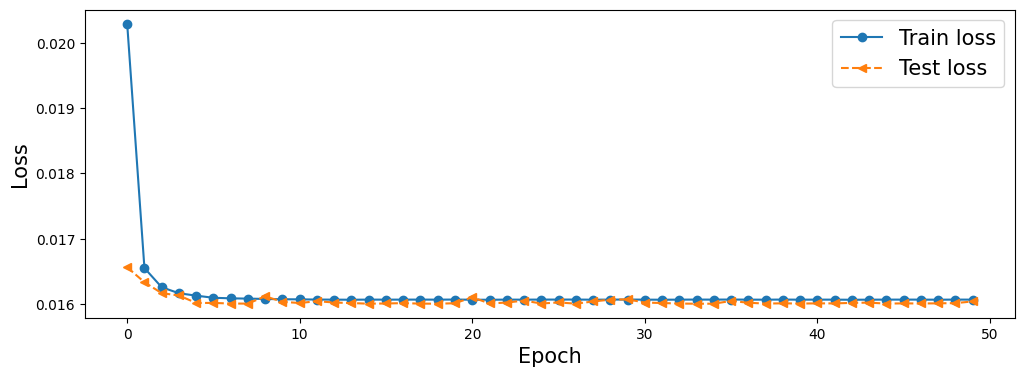

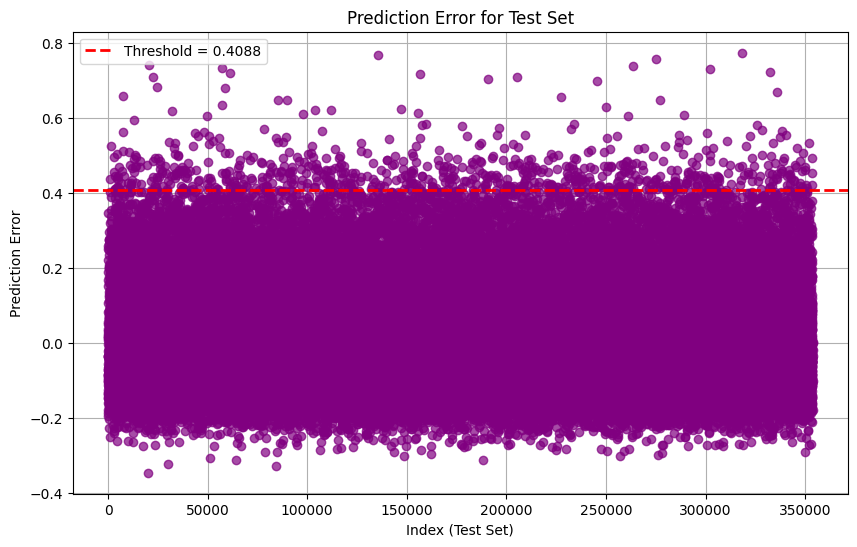

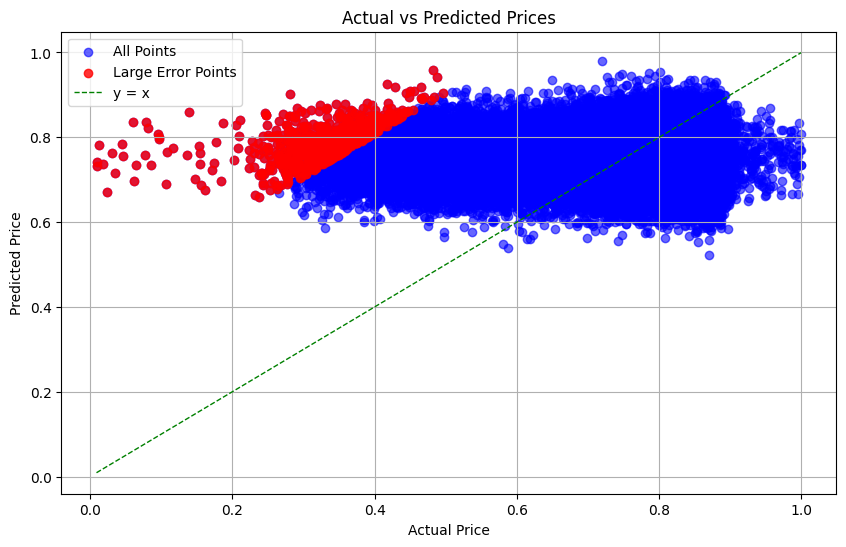

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness                3.226662e-16               0.484743
Time to maturity        -7.820780e-18              -0.652886
interest rate           -8.803476e-16              -0.540351
divident yield           6.146319e-16               0.349391
initial vol             -2.023658e-16              -0.209377
long term expected vol   3.277796e-16              -1.072829
vol revert rate         -5.573499e-17               0.461644
vol of vol               1.715850e-17               0.051350
correlation of W and W   1.489916e-16              -0.014986
Call Option Price        7.474048e-01               0.323430


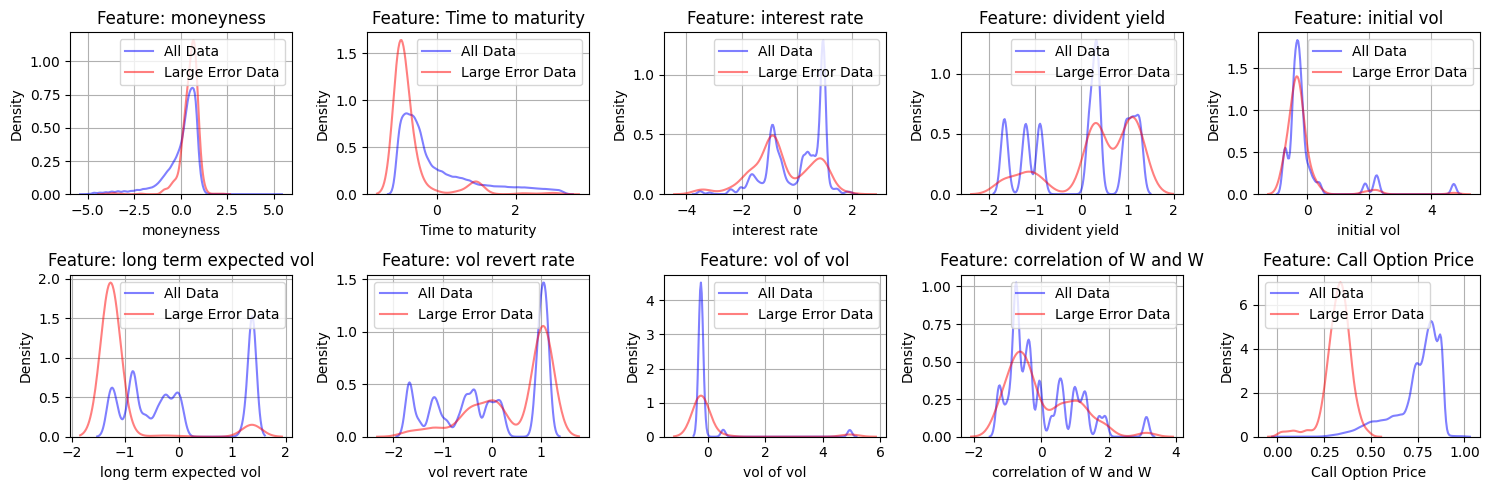

Correlation with Prediction Error:
moneyness                 0.072334
Time to maturity         -0.180564
interest rate            -0.055523
divident yield            0.017778
initial vol              -0.032999
long term expected vol   -0.186654
vol revert rate           0.094547
vol of vol               -0.003625
correlation of W and W   -0.002946
Call Option Price        -0.624722
dtype: float64


In [ ]:
returned_values_cnn = nn_training_cnn(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion=nn.MSELoss(), filters=[16, 32], kernel_size=3, standardize=True, init_weight=True)
heston_simulated_prediction_cnn = returned_values_cnn[1]
test_indice_cnn = returned_values_cnn[0]
result_evaluation(heston_simulated_prediction_cnn, test_indices = test_indice_cnn)

# Grid Search

Testing parameters: Layers=[10, 10], Standardize=MSELoss(), Init Weight=True
Epoch 1
-------------------------------
size: 37340
loss: 1.499942  [    0/37340]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.211777  [ 3200/37340]
loss: 0.092143  [ 6400/37340]
loss: 0.089348  [ 9600/37340]
loss: 0.056521  [12800/37340]
loss: 0.035300  [16000/37340]
loss: 0.043081  [19200/37340]
loss: 0.031837  [22400/37340]
loss: 0.026085  [25600/37340]
loss: 0.032199  [28800/37340]
loss: 0.027089  [32000/37340]
loss: 0.026393  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.025249 

Epoch 1/50, Test Loss: 0.0252
Epoch 2
-------------------------------
size: 37340
loss: 0.028660  [    0/37340]
loss: 0.034089  [ 3200/37340]
loss: 0.030671  [ 6400/37340]
loss: 0.025786  [ 9600/37340]
loss: 0.018078  [12800/37340]
loss: 0.016675  [16000/37340]
loss: 0.025197  [19200/37340]
loss: 0.025152  [22400/37340]
loss: 0.019535  [25600/37340]
loss: 0.017678  [28800/37340]
loss: 0.020234  [32000/37340]
loss: 0.024480  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.018858 

Epoch 2/50, Test Loss: 0.0189
Epoch 3
-------------------------------
size: 37340
loss: 0.021149  [    0/37340]
loss: 0.013092  [ 3200/37340]
loss: 0.010010  [ 6400/37340]
loss: 0.015226  [ 9600/37340]
loss: 0.020485  [12800/37340]
loss: 0.020030  [16000/37340]
loss: 0.013408  [19200/37340]
loss: 0.028780  [22400/37340]
loss: 0.020259  [25600/37340]
loss: 0.022892  [28800/37340]
loss: 0.010971  [32000/37340]
loss: 0.016890  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.033676  [ 3200/37340]
loss: 0.020691  [ 6400/37340]
loss: 0.018353  [ 9600/37340]
loss: 0.027812  [12800/37340]
loss: 0.021247  [16000/37340]
loss: 0.011584  [19200/37340]
loss: 0.011316  [22400/37340]
loss: 0.017322  [25600/37340]
loss: 0.010892  [28800/37340]
loss: 0.022283  [32000/37340]
loss: 0.012203  [35200/37340]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


size: 9336
Test Error: 
 Avg loss: 0.016377 

Epoch 1/50, Test Loss: 0.0164
Epoch 2
-------------------------------
size: 37340
loss: 0.012189  [    0/37340]
loss: 0.032408  [ 3200/37340]
loss: 0.018574  [ 6400/37340]
loss: 0.017939  [ 9600/37340]
loss: 0.013871  [12800/37340]
loss: 0.010246  [16000/37340]
loss: 0.019528  [19200/37340]
loss: 0.009282  [22400/37340]
loss: 0.026209  [25600/37340]
loss: 0.020471  [28800/37340]
loss: 0.022538  [32000/37340]
loss: 0.024997  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.015709 

Epoch 2/50, Test Loss: 0.0157
Epoch 3
-------------------------------
size: 37340
loss: 0.021361  [    0/37340]
loss: 0.013589  [ 3200/37340]
loss: 0.017880  [ 6400/37340]
loss: 0.013119  [ 9600/37340]
loss: 0.012899  [12800/37340]
loss: 0.019426  [16000/37340]
loss: 0.011919  [19200/37340]
loss: 0.016396  [22400/37340]
loss: 0.022633  [25600/37340]
loss: 0.013299  [28800/37340]
loss: 0.008534  [32000/37340]
loss: 0.021617  [35200/37340]
size: 9336
Test Error: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.378884  [ 3200/37340]
loss: 0.259888  [ 6400/37340]
loss: 0.123549  [ 9600/37340]
loss: 0.110593  [12800/37340]
loss: 0.040562  [16000/37340]
loss: 0.051173  [19200/37340]
loss: 0.042184  [22400/37340]
loss: 0.041789  [25600/37340]
loss: 0.034474  [28800/37340]
loss: 0.023228  [32000/37340]
loss: 0.030306  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.028450 

Epoch 1/50, Test Loss: 0.0285
Epoch 2
-------------------------------
size: 37340
loss: 0.022926  [    0/37340]
loss: 0.020662  [ 3200/37340]
loss: 0.019521  [ 6400/37340]
loss: 0.016098  [ 9600/37340]
loss: 0.035764  [12800/37340]
loss: 0.022951  [16000/37340]
loss: 0.017368  [19200/37340]
loss: 0.026499  [22400/37340]
loss: 0.020282  [25600/37340]
loss: 0.018204  [28800/37340]
loss: 0.019404  [32000/37340]
loss: 0.026364  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.019540 

Epoch 2/50, Test Loss: 0.0195
Epoch 3
-------------------------------
size: 37340
loss: 0.016033  [    0/37340]
loss: 0.019123  [ 3200/37340]
loss: 0.022333  [ 6400/37340]
loss: 0.018562  [ 9600/37340]
loss: 0.018818  [12800/37340]
loss: 0.024227  [16000/37340]
loss: 0.020500  [19200/37340]
loss: 0.017283  [22400/37340]
loss: 0.012774  [25600/37340]
loss: 0.014400  [28800/37340]
loss: 0.017315  [32000/37340]
loss: 0.017444  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.171549  [ 3200/37340]
loss: 0.054027  [ 6400/37340]
loss: 0.022659  [ 9600/37340]
loss: 0.020142  [12800/37340]
loss: 0.025849  [16000/37340]
loss: 0.017382  [19200/37340]
loss: 0.012858  [22400/37340]
loss: 0.017251  [25600/37340]
loss: 0.018827  [28800/37340]
loss: 0.011733  [32000/37340]
loss: 0.020823  [35200/37340]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


size: 9336
Test Error: 
 Avg loss: 0.016071 

Epoch 1/50, Test Loss: 0.0161
Epoch 2
-------------------------------
size: 37340
loss: 0.023545  [    0/37340]
loss: 0.019255  [ 3200/37340]
loss: 0.016643  [ 6400/37340]
loss: 0.017766  [ 9600/37340]
loss: 0.013592  [12800/37340]
loss: 0.015352  [16000/37340]
loss: 0.025034  [19200/37340]
loss: 0.013151  [22400/37340]
loss: 0.009337  [25600/37340]
loss: 0.017991  [28800/37340]
loss: 0.029041  [32000/37340]
loss: 0.011071  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.016057 

Epoch 2/50, Test Loss: 0.0161
Epoch 3
-------------------------------
size: 37340
loss: 0.015916  [    0/37340]
loss: 0.024524  [ 3200/37340]
loss: 0.021579  [ 6400/37340]
loss: 0.017529  [ 9600/37340]
loss: 0.018431  [12800/37340]
loss: 0.016790  [16000/37340]
loss: 0.035878  [19200/37340]
loss: 0.015169  [22400/37340]
loss: 0.013667  [25600/37340]
loss: 0.020518  [28800/37340]
loss: 0.011418  [32000/37340]
loss: 0.010560  [35200/37340]
size: 9336
Test Error: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.249291  [ 3200/37340]
loss: 0.087995  [ 6400/37340]
loss: 0.045192  [ 9600/37340]
loss: 0.041150  [12800/37340]
loss: 0.032123  [16000/37340]
loss: 0.023795  [19200/37340]
loss: 0.025581  [22400/37340]
loss: 0.019861  [25600/37340]
loss: 0.020838  [28800/37340]
loss: 0.052244  [32000/37340]
loss: 0.015894  [35200/37340]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


size: 9336
Test Error: 
 Avg loss: 0.022624 

Epoch 1/50, Test Loss: 0.0226
Epoch 2
-------------------------------
size: 37340
loss: 0.024423  [    0/37340]
loss: 0.023840  [ 3200/37340]
loss: 0.025377  [ 6400/37340]
loss: 0.022150  [ 9600/37340]
loss: 0.020531  [12800/37340]
loss: 0.016327  [16000/37340]
loss: 0.020785  [19200/37340]
loss: 0.016730  [22400/37340]
loss: 0.027939  [25600/37340]
loss: 0.014166  [28800/37340]
loss: 0.022750  [32000/37340]
loss: 0.014090  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.018214 

Epoch 2/50, Test Loss: 0.0182
Epoch 3
-------------------------------
size: 37340
loss: 0.022499  [    0/37340]
loss: 0.021603  [ 3200/37340]
loss: 0.008292  [ 6400/37340]
loss: 0.015728  [ 9600/37340]
loss: 0.013167  [12800/37340]
loss: 0.023025  [16000/37340]
loss: 0.009631  [19200/37340]
loss: 0.020817  [22400/37340]
loss: 0.026112  [25600/37340]
loss: 0.016356  [28800/37340]
loss: 0.012985  [32000/37340]
loss: 0.036775  [35200/37340]
size: 9336
Test Error: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.021749  [ 3200/37340]
loss: 0.021120  [ 6400/37340]
loss: 0.024978  [ 9600/37340]
loss: 0.017412  [12800/37340]
loss: 0.015548  [16000/37340]
loss: 0.011481  [19200/37340]
loss: 0.015465  [22400/37340]
loss: 0.013105  [25600/37340]
loss: 0.021275  [28800/37340]
loss: 0.009607  [32000/37340]
loss: 0.025296  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.016277 

Epoch 1/50, Test Loss: 0.0163
Epoch 2
-------------------------------
size: 37340
loss: 0.017420  [    0/37340]
loss: 0.019977  [ 3200/37340]
loss: 0.012333  [ 6400/37340]
loss: 0.013484  [ 9600/37340]
loss: 0.007056  [12800/37340]
loss: 0.025622  [16000/37340]
loss: 0.013713  [19200/37340]
loss: 0.020345  [22400/37340]
loss: 0.015359  [25600/37340]
loss: 0.018993  [28800/37340]
loss: 0.016876  [32000/37340]
loss: 0.009250  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.016131 

Epoch 2/50, Test Loss: 0.0161
Epoch 3
-------------------------------
size: 37340
loss: 0.014079  [    0/37340]
loss: 0.012213  [ 3200/37340]
loss: 0.010724  [ 6400/37340]
loss: 0.033677  [ 9600/37340]
loss: 0.012435  [12800/37340]
loss: 0.009779  [16000/37340]
loss: 0.023380  [19200/37340]
loss: 0.010718  [22400/37340]
loss: 0.019541  [25600/37340]
loss: 0.013539  [28800/37340]
loss: 0.017482  [32000/37340]
loss: 0.012455  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.060097  [ 6400/37340]
loss: 0.043612  [ 9600/37340]
loss: 0.039034  [12800/37340]
loss: 0.030961  [16000/37340]
loss: 0.028002  [19200/37340]
loss: 0.014159  [22400/37340]
loss: 0.020300  [25600/37340]
loss: 0.023069  [28800/37340]
loss: 0.014959  [32000/37340]
loss: 0.017466  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.020553 

Epoch 1/50, Test Loss: 0.0206
Epoch 2
-------------------------------
size: 37340
loss: 0.026979  [    0/37340]
loss: 0.020314  [ 3200/37340]
loss: 0.012998  [ 6400/37340]
loss: 0.027935  [ 9600/37340]
loss: 0.016339  [12800/37340]
loss: 0.018997  [16000/37340]
loss: 0.019604  [19200/37340]
loss: 0.008807  [22400/37340]
loss: 0.006696  [25600/37340]
loss: 0.019978  [28800/37340]
loss: 0.018847  [32000/37340]
loss: 0.022937  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.017775 

Epoch 2/50, Test Loss: 0.0178
Epoch 3
-------------------------------
size: 37340
loss: 0.010175  [    0/37340]
loss: 0.013327  [ 3200/37340]
loss: 0.027628  [ 6400/37340]
loss: 0.022483  [ 9600/37340]
loss: 0.014755  [12800/37340]
loss: 0.012694  [16000/37340]
loss: 0.022199  [19200/37340]
loss: 0.011934  [22400/37340]
loss: 0.021381  [25600/37340]
loss: 0.021447  [28800/37340]
loss: 0.019257  [32000/37340]
loss: 0.024441  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.032733  [ 3200/37340]
loss: 0.017943  [ 6400/37340]
loss: 0.016839  [ 9600/37340]
loss: 0.015943  [12800/37340]
loss: 0.017384  [16000/37340]
loss: 0.021437  [19200/37340]
loss: 0.019151  [22400/37340]
loss: 0.018970  [25600/37340]
loss: 0.030151  [28800/37340]
loss: 0.014585  [32000/37340]
loss: 0.012565  [35200/37340]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


size: 9336
Test Error: 
 Avg loss: 0.016288 

Epoch 1/50, Test Loss: 0.0163
Epoch 2
-------------------------------
size: 37340
loss: 0.032801  [    0/37340]
loss: 0.014465  [ 3200/37340]
loss: 0.014173  [ 6400/37340]
loss: 0.012952  [ 9600/37340]
loss: 0.016052  [12800/37340]
loss: 0.015686  [16000/37340]
loss: 0.007911  [19200/37340]
loss: 0.011748  [22400/37340]
loss: 0.022279  [25600/37340]
loss: 0.019295  [28800/37340]
loss: 0.014795  [32000/37340]
loss: 0.022123  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.016154 

Epoch 2/50, Test Loss: 0.0162
Epoch 3
-------------------------------
size: 37340
loss: 0.008906  [    0/37340]
loss: 0.013045  [ 3200/37340]
loss: 0.014524  [ 6400/37340]
loss: 0.014745  [ 9600/37340]
loss: 0.017328  [12800/37340]
loss: 0.014635  [16000/37340]
loss: 0.015381  [19200/37340]
loss: 0.017601  [22400/37340]
loss: 0.018427  [25600/37340]
loss: 0.013418  [28800/37340]
loss: 0.012538  [32000/37340]
loss: 0.018515  [35200/37340]
size: 9336
Test Error: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.040386  [ 3200/37340]
loss: 0.040066  [ 6400/37340]
loss: 0.038425  [ 9600/37340]
loss: 0.023611  [12800/37340]
loss: 0.028286  [16000/37340]
loss: 0.036435  [19200/37340]
loss: 0.020053  [22400/37340]
loss: 0.022418  [25600/37340]
loss: 0.018769  [28800/37340]
loss: 0.028089  [32000/37340]
loss: 0.027626  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.020544 

Epoch 1/50, Test Loss: 0.0205
Epoch 2
-------------------------------
size: 37340
loss: 0.021373  [    0/37340]
loss: 0.020273  [ 3200/37340]
loss: 0.030359  [ 6400/37340]
loss: 0.023966  [ 9600/37340]
loss: 0.026657  [12800/37340]
loss: 0.010124  [16000/37340]
loss: 0.016091  [19200/37340]
loss: 0.016751  [22400/37340]
loss: 0.019869  [25600/37340]
loss: 0.010309  [28800/37340]
loss: 0.016297  [32000/37340]
loss: 0.015834  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.017393 

Epoch 2/50, Test Loss: 0.0174
Epoch 3
-------------------------------
size: 37340
loss: 0.011407  [    0/37340]
loss: 0.011330  [ 3200/37340]
loss: 0.019742  [ 6400/37340]
loss: 0.013639  [ 9600/37340]
loss: 0.016213  [12800/37340]
loss: 0.011206  [16000/37340]
loss: 0.018250  [19200/37340]
loss: 0.021421  [22400/37340]
loss: 0.022047  [25600/37340]
loss: 0.007485  [28800/37340]
loss: 0.007817  [32000/37340]
loss: 0.014202  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.016845  [ 3200/37340]
loss: 0.018576  [ 6400/37340]
loss: 0.036472  [ 9600/37340]
loss: 0.013247  [12800/37340]
loss: 0.017305  [16000/37340]
loss: 0.017290  [19200/37340]
loss: 0.029194  [22400/37340]
loss: 0.019165  [25600/37340]
loss: 0.023407  [28800/37340]
loss: 0.024184  [32000/37340]
loss: 0.010778  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.016540 

Epoch 1/50, Test Loss: 0.0165
Epoch 2
-------------------------------
size: 37340
loss: 0.011478  [    0/37340]
loss: 0.023368  [ 3200/37340]
loss: 0.019532  [ 6400/37340]
loss: 0.007827  [ 9600/37340]
loss: 0.008997  [12800/37340]
loss: 0.015852  [16000/37340]
loss: 0.033912  [19200/37340]
loss: 0.018168  [22400/37340]
loss: 0.012765  [25600/37340]
loss: 0.013090  [28800/37340]
loss: 0.014984  [32000/37340]
loss: 0.014285  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.016302 

Epoch 2/50, Test Loss: 0.0163
Epoch 3
-------------------------------
size: 37340
loss: 0.016588  [    0/37340]
loss: 0.014351  [ 3200/37340]
loss: 0.023658  [ 6400/37340]
loss: 0.022952  [ 9600/37340]
loss: 0.024628  [12800/37340]
loss: 0.027199  [16000/37340]
loss: 0.014419  [19200/37340]
loss: 0.014347  [22400/37340]
loss: 0.020833  [25600/37340]
loss: 0.009229  [28800/37340]
loss: 0.016355  [32000/37340]
loss: 0.014077  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.044312  [ 3200/37340]
loss: 0.039464  [ 6400/37340]
loss: 0.018389  [ 9600/37340]
loss: 0.022270  [12800/37340]
loss: 0.024193  [16000/37340]
loss: 0.014064  [19200/37340]
loss: 0.015861  [22400/37340]
loss: 0.017672  [25600/37340]
loss: 0.026117  [28800/37340]
loss: 0.029368  [32000/37340]
loss: 0.029753  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.020128 

Epoch 1/50, Test Loss: 0.0201
Epoch 2
-------------------------------
size: 37340
loss: 0.033907  [    0/37340]
loss: 0.017230  [ 3200/37340]
loss: 0.024438  [ 6400/37340]
loss: 0.017684  [ 9600/37340]
loss: 0.013637  [12800/37340]
loss: 0.028206  [16000/37340]
loss: 0.011290  [19200/37340]
loss: 0.011049  [22400/37340]
loss: 0.016407  [25600/37340]
loss: 0.021320  [28800/37340]
loss: 0.013147  [32000/37340]
loss: 0.012296  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.017702 

Epoch 2/50, Test Loss: 0.0177
Epoch 3
-------------------------------
size: 37340
loss: 0.013362  [    0/37340]
loss: 0.017396  [ 3200/37340]
loss: 0.017573  [ 6400/37340]
loss: 0.009390  [ 9600/37340]
loss: 0.015092  [12800/37340]
loss: 0.020039  [16000/37340]
loss: 0.020554  [19200/37340]
loss: 0.016415  [22400/37340]
loss: 0.015130  [25600/37340]
loss: 0.010828  [28800/37340]
loss: 0.023846  [32000/37340]
loss: 0.011188  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.029034  [ 6400/37340]
loss: 0.020154  [ 9600/37340]
loss: 0.017173  [12800/37340]
loss: 0.014223  [16000/37340]
loss: 0.008722  [19200/37340]
loss: 0.008818  [22400/37340]
loss: 0.016788  [25600/37340]
loss: 0.011695  [28800/37340]
loss: 0.018898  [32000/37340]
loss: 0.020056  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.017486 

Epoch 1/50, Test Loss: 0.0175
Epoch 2
-------------------------------
size: 37340
loss: 0.013287  [    0/37340]
loss: 0.016523  [ 3200/37340]
loss: 0.009322  [ 6400/37340]
loss: 0.015836  [ 9600/37340]
loss: 0.013972  [12800/37340]
loss: 0.019356  [16000/37340]
loss: 0.009448  [19200/37340]
loss: 0.016947  [22400/37340]
loss: 0.012856  [25600/37340]
loss: 0.026541  [28800/37340]
loss: 0.017781  [32000/37340]
loss: 0.030709  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.016465 

Epoch 2/50, Test Loss: 0.0165
Epoch 3
-------------------------------
size: 37340
loss: 0.018437  [    0/37340]
loss: 0.012772  [ 3200/37340]
loss: 0.017640  [ 6400/37340]
loss: 0.006849  [ 9600/37340]
loss: 0.016322  [12800/37340]
loss: 0.011263  [16000/37340]
loss: 0.019762  [19200/37340]
loss: 0.027719  [22400/37340]
loss: 0.013112  [25600/37340]
loss: 0.012295  [28800/37340]
loss: 0.024197  [32000/37340]
loss: 0.016277  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

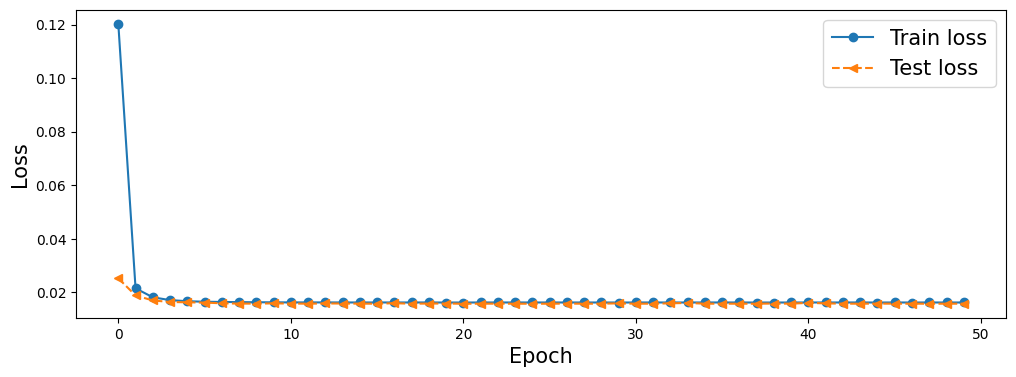

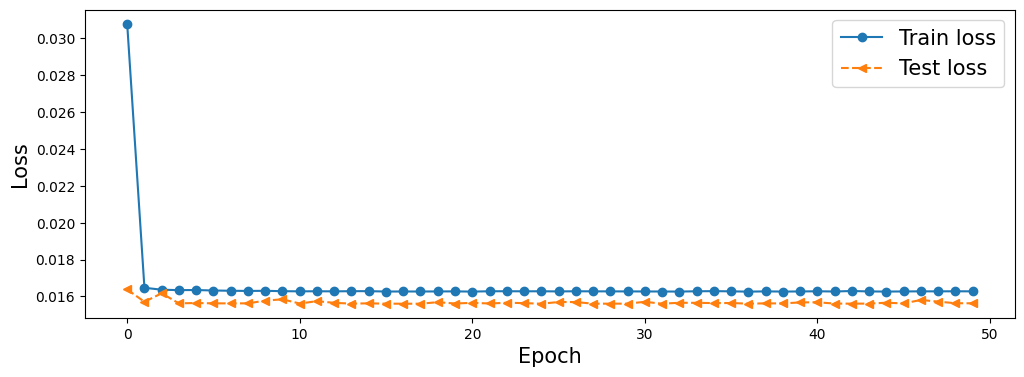

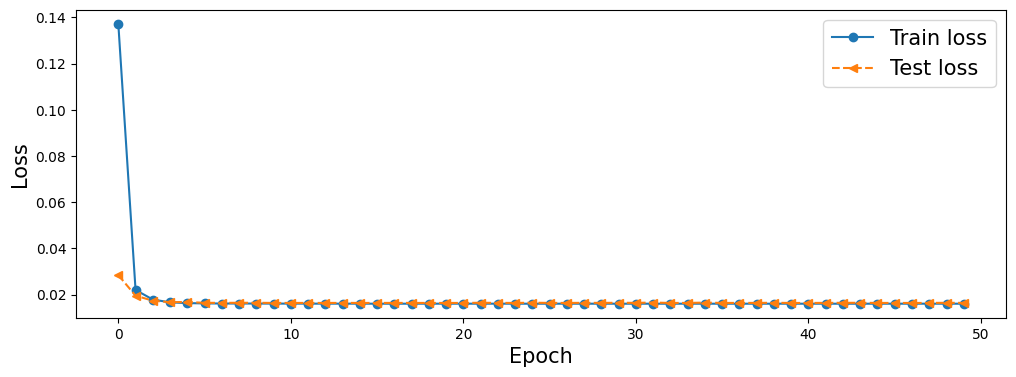

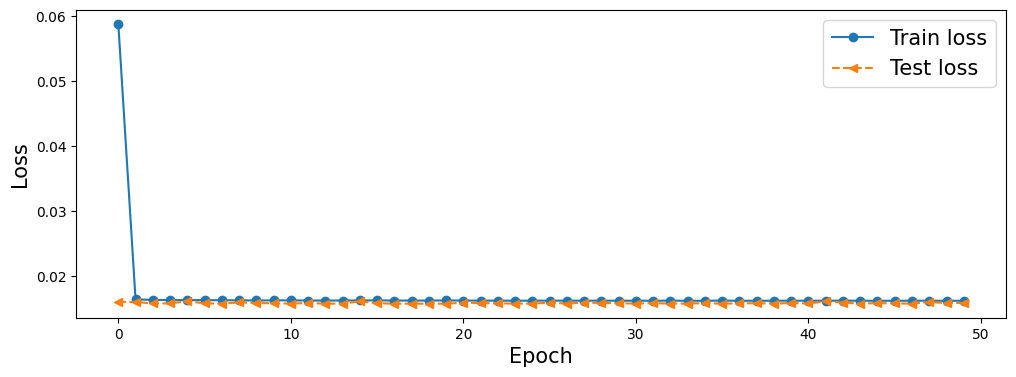

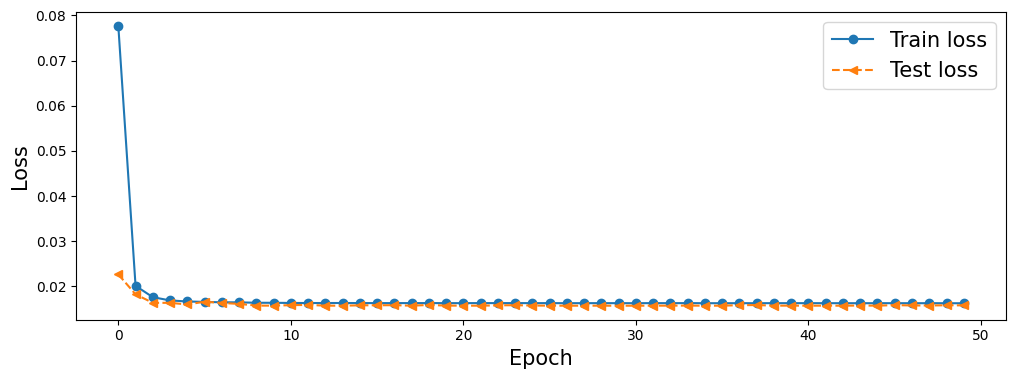

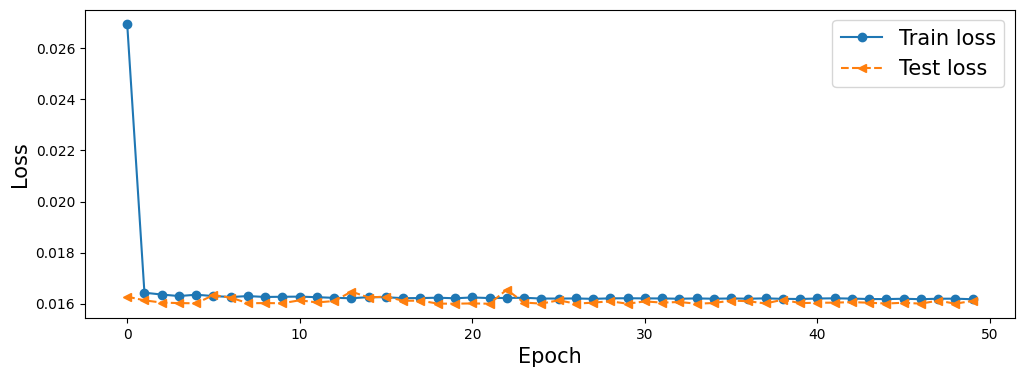

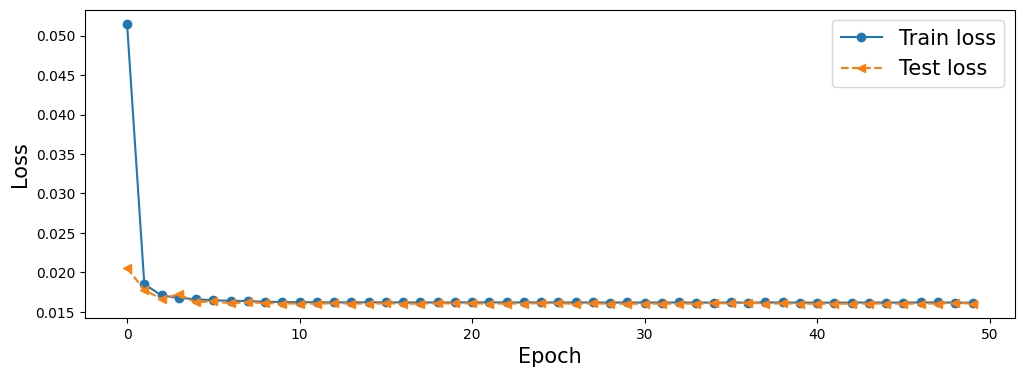

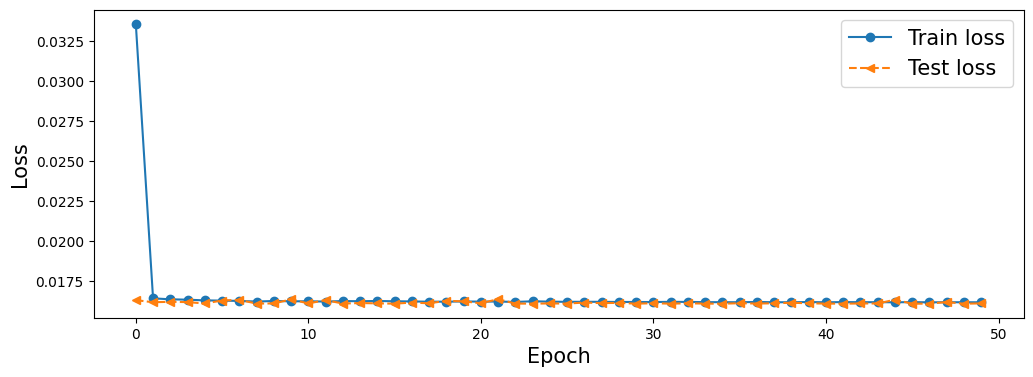

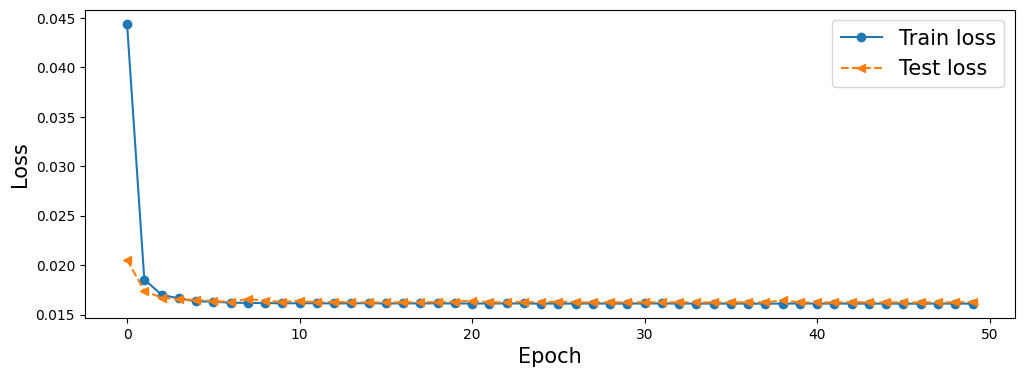

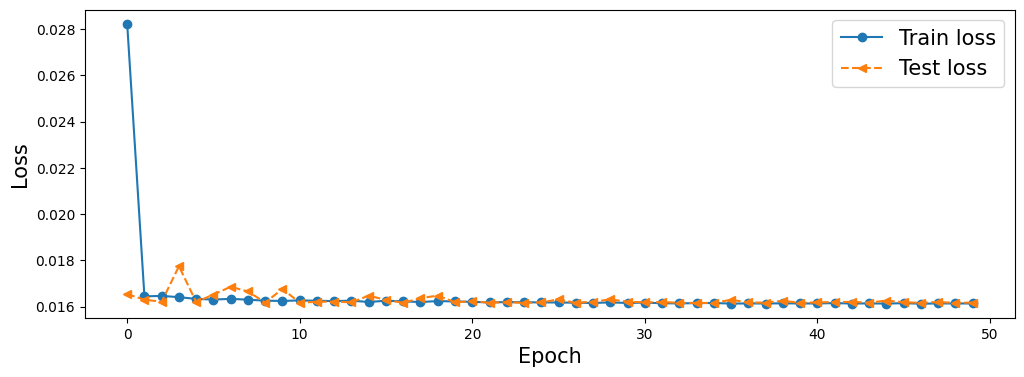

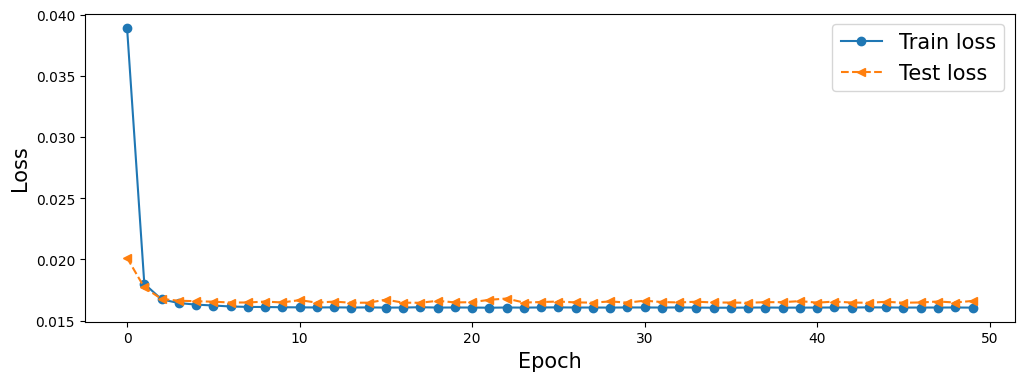

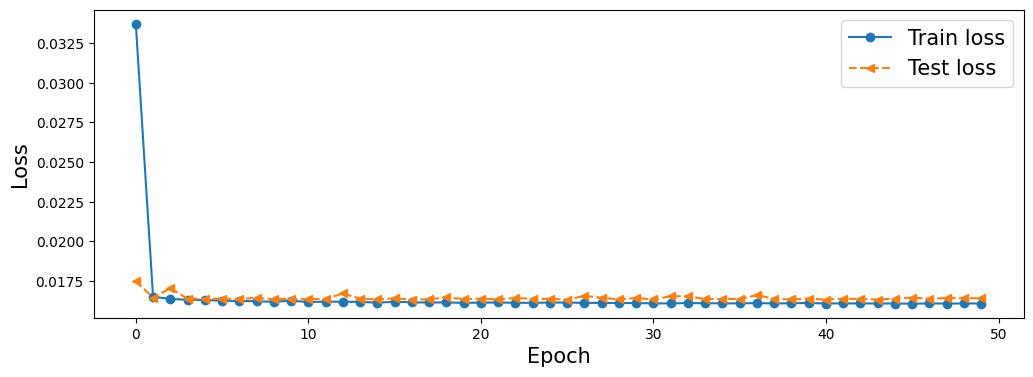

In [13]:
# NN Grid Search
import itertools

def grid_search_nn_training_n(param_grid, data=heston_simulated, train_test_split=0.8, num_epochs=50):
    best_params = None
    best_metrics = {
        'MSE': float('inf'),
        'RMSE': float('inf'),
        'MAE': float('inf'),
        'R2': float('-inf')
    }

    # Generate all combinations of parameters
    param_combinations = list(itertools.product(*param_grid.values()))

    for params in param_combinations:
        # Unpack parameters
        layers, standardize, init_weight = params

        print(f"Testing parameters: Layers={layers}, Standardize={standardize}, Init Weight={init_weight}")

        # Call nn_training_n with the current parameters
        _, prediction = nn_training_n(
            data=data,
            train_test_split=train_test_split,
            num_epochs=num_epochs,
            layers=layers,
            standardize=standardize,
            init_weight=init_weight
        )

        # Extract metrics from the prediction DataFrame
        mse = mean_squared_error(
            prediction['Call Option Price'],
            prediction['Call Option Price Prediction']
        )
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(
            prediction['Call Option Price'],
            prediction['Call Option Price Prediction']
        )
        r2 = r2_score(
            prediction['Call Option Price'],
            prediction['Call Option Price Prediction']
        )

        print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}\n")

        # Update best parameters if the current model is better
        if mse < best_metrics['MSE']:
            best_params = {
                'Layers': layers,
                'Standardize': standardize,
                'Init Weight': init_weight
            }
            best_metrics = {
                'MSE': mse,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            }

    # Print best parameters and metrics
    print("Best Parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")

    print("\nBest Metrics:")
    for key, value in best_metrics.items():
        print(f"  {key}: {value:.4f}")

# Example usage of grid search
grid_search_nn_training_n(
    param_grid={
        'layers': [[10, 10], [30, 20, 10], [50, 30, 20]],
        'criterion':[nn.MSELoss(), nn.HuberLoss(delta=1.0)],
        'init_weight': [True, False]
    }
)

Testing parameters: Layers=[10, 10], Standardize=True, Init Weight=True
Epoch 1
-------------------------------
size: 37340
loss: 1.009015  [    0/37340]
loss: 0.221865  [ 3200/37340]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.117671  [ 6400/37340]
loss: 0.046112  [ 9600/37340]
loss: 0.053907  [12800/37340]
loss: 0.054965  [16000/37340]
loss: 0.036725  [19200/37340]
loss: 0.034377  [22400/37340]
loss: 0.049835  [25600/37340]
loss: 0.042180  [28800/37340]
loss: 0.037600  [32000/37340]
loss: 0.020827  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.028248 

Epoch 1/50, Test Loss: 0.0282
Epoch 2
-------------------------------
size: 37340
loss: 0.019221  [    0/37340]
loss: 0.039008  [ 3200/37340]
loss: 0.016883  [ 6400/37340]
loss: 0.027696  [ 9600/37340]
loss: 0.028961  [12800/37340]
loss: 0.016718  [16000/37340]
loss: 0.011949  [19200/37340]
loss: 0.027296  [22400/37340]
loss: 0.018755  [25600/37340]
loss: 0.018459  [28800/37340]
loss: 0.019773  [32000/37340]
loss: 0.022385  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.019170 

Epoch 2/50, Test Loss: 0.0192
Epoch 3
-------------------------------
size: 37340
loss: 0.016523  [    0/37340]
loss: 0.010210  [ 3200/37340]
loss: 0.015524  [ 6400/37340]
loss: 0.023705  [ 9600/37340]
loss: 0.018495  [12800/37340]
loss: 0.008562  [16000/37340]
loss: 0.018042  [19200/37340]
loss: 0.015027  [22400/37340]
loss: 0.019980  [25600/37340]
loss: 0.015020  [28800/37340]
loss: 0.016957  [32000/37340]
loss: 0.016728  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.198372  [ 3200/37340]
loss: 0.042082  [ 6400/37340]
loss: 0.028827  [ 9600/37340]
loss: 0.033610  [12800/37340]
loss: 0.024409  [16000/37340]
loss: 0.017446  [19200/37340]
loss: 0.012155  [22400/37340]
loss: 0.020533  [25600/37340]
loss: 0.017937  [28800/37340]
loss: 0.022389  [32000/37340]
loss: 0.017008  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.016904 

Epoch 1/50, Test Loss: 0.0169
Epoch 2
-------------------------------
size: 37340
loss: 0.034821  [    0/37340]
loss: 0.014358  [ 3200/37340]
loss: 0.013601  [ 6400/37340]
loss: 0.011385  [ 9600/37340]
loss: 0.021989  [12800/37340]
loss: 0.016562  [16000/37340]
loss: 0.013279  [19200/37340]
loss: 0.012650  [22400/37340]
loss: 0.013625  [25600/37340]
loss: 0.012896  [28800/37340]
loss: 0.011574  [32000/37340]
loss: 0.012069  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.015986 

Epoch 2/50, Test Loss: 0.0160
Epoch 3
-------------------------------
size: 37340
loss: 0.010377  [    0/37340]
loss: 0.013856  [ 3200/37340]
loss: 0.016095  [ 6400/37340]
loss: 0.016902  [ 9600/37340]
loss: 0.006116  [12800/37340]
loss: 0.017324  [16000/37340]
loss: 0.007411  [19200/37340]
loss: 0.013290  [22400/37340]
loss: 0.017372  [25600/37340]
loss: 0.016226  [28800/37340]
loss: 0.015690  [32000/37340]
loss: 0.011249  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.184525  [ 3200/37340]
loss: 0.078765  [ 6400/37340]
loss: 0.071226  [ 9600/37340]
loss: 0.036329  [12800/37340]
loss: 0.043698  [16000/37340]
loss: 0.043723  [19200/37340]
loss: 0.036907  [22400/37340]
loss: 0.034153  [25600/37340]
loss: 0.027485  [28800/37340]
loss: 0.031027  [32000/37340]
loss: 0.018570  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.022442 

Epoch 1/50, Test Loss: 0.0224
Epoch 2
-------------------------------
size: 37340
loss: 0.028872  [    0/37340]
loss: 0.014209  [ 3200/37340]
loss: 0.017994  [ 6400/37340]
loss: 0.019228  [ 9600/37340]
loss: 0.015608  [12800/37340]
loss: 0.021089  [16000/37340]
loss: 0.026264  [19200/37340]
loss: 0.026586  [22400/37340]
loss: 0.013588  [25600/37340]
loss: 0.014788  [28800/37340]
loss: 0.017499  [32000/37340]
loss: 0.015945  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.018121 

Epoch 2/50, Test Loss: 0.0181
Epoch 3
-------------------------------
size: 37340
loss: 0.018919  [    0/37340]
loss: 0.013658  [ 3200/37340]
loss: 0.019991  [ 6400/37340]
loss: 0.018643  [ 9600/37340]
loss: 0.015531  [12800/37340]
loss: 0.017078  [16000/37340]
loss: 0.010239  [19200/37340]
loss: 0.019526  [22400/37340]
loss: 0.017925  [25600/37340]
loss: 0.007007  [28800/37340]
loss: 0.022674  [32000/37340]
loss: 0.011415  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.027942  [ 3200/37340]
loss: 0.034632  [ 6400/37340]
loss: 0.020874  [ 9600/37340]
loss: 0.011152  [12800/37340]
loss: 0.014907  [16000/37340]
loss: 0.016903  [19200/37340]
loss: 0.017765  [22400/37340]
loss: 0.018824  [25600/37340]
loss: 0.016743  [28800/37340]
loss: 0.011652  [32000/37340]
loss: 0.009025  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.016556 

Epoch 1/50, Test Loss: 0.0166
Epoch 2
-------------------------------
size: 37340
loss: 0.015352  [    0/37340]
loss: 0.015844  [ 3200/37340]
loss: 0.019563  [ 6400/37340]
loss: 0.012936  [ 9600/37340]
loss: 0.016558  [12800/37340]
loss: 0.015778  [16000/37340]
loss: 0.017910  [19200/37340]
loss: 0.016984  [22400/37340]
loss: 0.011010  [25600/37340]
loss: 0.019458  [28800/37340]
loss: 0.018753  [32000/37340]
loss: 0.009541  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.016295 

Epoch 2/50, Test Loss: 0.0163
Epoch 3
-------------------------------
size: 37340
loss: 0.020115  [    0/37340]
loss: 0.012092  [ 3200/37340]
loss: 0.022532  [ 6400/37340]
loss: 0.013060  [ 9600/37340]
loss: 0.021898  [12800/37340]
loss: 0.006874  [16000/37340]
loss: 0.018059  [19200/37340]
loss: 0.015343  [22400/37340]
loss: 0.014500  [25600/37340]
loss: 0.014475  [28800/37340]
loss: 0.016637  [32000/37340]
loss: 0.016903  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.369601  [ 6400/37340]
loss: 0.211414  [ 9600/37340]
loss: 0.207937  [12800/37340]
loss: 0.086999  [16000/37340]
loss: 0.051218  [19200/37340]
loss: 0.073500  [22400/37340]
loss: 0.064714  [25600/37340]
loss: 0.040755  [28800/37340]
loss: 0.039000  [32000/37340]
loss: 0.041404  [35200/37340]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


size: 9336
Test Error: 
 Avg loss: 0.037199 

Epoch 1/50, Test Loss: 0.0372
Epoch 2
-------------------------------
size: 37340
loss: 0.024544  [    0/37340]
loss: 0.050840  [ 3200/37340]
loss: 0.019623  [ 6400/37340]
loss: 0.028510  [ 9600/37340]
loss: 0.041634  [12800/37340]
loss: 0.038395  [16000/37340]
loss: 0.039481  [19200/37340]
loss: 0.026313  [22400/37340]
loss: 0.033379  [25600/37340]
loss: 0.029448  [28800/37340]
loss: 0.040823  [32000/37340]
loss: 0.025691  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.024279 

Epoch 2/50, Test Loss: 0.0243
Epoch 3
-------------------------------
size: 37340
loss: 0.023593  [    0/37340]
loss: 0.033717  [ 3200/37340]
loss: 0.023645  [ 6400/37340]
loss: 0.030654  [ 9600/37340]
loss: 0.021935  [12800/37340]
loss: 0.019934  [16000/37340]
loss: 0.012736  [19200/37340]
loss: 0.012443  [22400/37340]
loss: 0.018710  [25600/37340]
loss: 0.015800  [28800/37340]
loss: 0.029966  [32000/37340]
loss: 0.012297  [35200/37340]
size: 9336
Test Error: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.026304  [ 6400/37340]
loss: 0.027404  [ 9600/37340]
loss: 0.028512  [12800/37340]
loss: 0.017079  [16000/37340]
loss: 0.025524  [19200/37340]
loss: 0.019188  [22400/37340]
loss: 0.021538  [25600/37340]
loss: 0.013090  [28800/37340]
loss: 0.027194  [32000/37340]
loss: 0.015230  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.017329 

Epoch 1/50, Test Loss: 0.0173
Epoch 2
-------------------------------
size: 37340
loss: 0.016415  [    0/37340]
loss: 0.017835  [ 3200/37340]
loss: 0.019514  [ 6400/37340]
loss: 0.008894  [ 9600/37340]
loss: 0.021789  [12800/37340]
loss: 0.019873  [16000/37340]
loss: 0.026249  [19200/37340]
loss: 0.018449  [22400/37340]
loss: 0.020204  [25600/37340]
loss: 0.020053  [28800/37340]
loss: 0.010501  [32000/37340]
loss: 0.014004  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.016407 

Epoch 2/50, Test Loss: 0.0164
Epoch 3
-------------------------------
size: 37340
loss: 0.028422  [    0/37340]
loss: 0.018776  [ 3200/37340]
loss: 0.023767  [ 6400/37340]
loss: 0.034870  [ 9600/37340]
loss: 0.010249  [12800/37340]
loss: 0.021080  [16000/37340]
loss: 0.015061  [19200/37340]
loss: 0.018376  [22400/37340]
loss: 0.013896  [25600/37340]
loss: 0.011529  [28800/37340]
loss: 0.030728  [32000/37340]
loss: 0.007981  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.115164  [ 3200/37340]
loss: 0.069888  [ 6400/37340]
loss: 0.049141  [ 9600/37340]
loss: 0.046202  [12800/37340]
loss: 0.036906  [16000/37340]
loss: 0.028163  [19200/37340]
loss: 0.027758  [22400/37340]
loss: 0.030232  [25600/37340]
loss: 0.027563  [28800/37340]
loss: 0.028260  [32000/37340]
loss: 0.012453  [35200/37340]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


size: 9336
Test Error: 
 Avg loss: 0.022100 

Epoch 1/50, Test Loss: 0.0221
Epoch 2
-------------------------------
size: 37340
loss: 0.019723  [    0/37340]
loss: 0.014030  [ 3200/37340]
loss: 0.017950  [ 6400/37340]
loss: 0.018481  [ 9600/37340]
loss: 0.013437  [12800/37340]
loss: 0.024360  [16000/37340]
loss: 0.014684  [19200/37340]
loss: 0.017010  [22400/37340]
loss: 0.028843  [25600/37340]
loss: 0.009209  [28800/37340]
loss: 0.016778  [32000/37340]
loss: 0.013778  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.017606 

Epoch 2/50, Test Loss: 0.0176
Epoch 3
-------------------------------
size: 37340
loss: 0.015841  [    0/37340]
loss: 0.024224  [ 3200/37340]
loss: 0.012590  [ 6400/37340]
loss: 0.023500  [ 9600/37340]
loss: 0.016658  [12800/37340]
loss: 0.017120  [16000/37340]
loss: 0.010835  [19200/37340]
loss: 0.015436  [22400/37340]
loss: 0.035150  [25600/37340]
loss: 0.008753  [28800/37340]
loss: 0.015004  [32000/37340]
loss: 0.011951  [35200/37340]
size: 9336
Test Error: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.030682  [ 3200/37340]
loss: 0.022872  [ 6400/37340]
loss: 0.018167  [ 9600/37340]
loss: 0.015961  [12800/37340]
loss: 0.021031  [16000/37340]
loss: 0.011243  [19200/37340]
loss: 0.015922  [22400/37340]
loss: 0.017604  [25600/37340]
loss: 0.020906  [28800/37340]
loss: 0.024403  [32000/37340]
loss: 0.011670  [35200/37340]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


size: 9336
Test Error: 
 Avg loss: 0.016734 

Epoch 1/50, Test Loss: 0.0167
Epoch 2
-------------------------------
size: 37340
loss: 0.010057  [    0/37340]
loss: 0.019745  [ 3200/37340]
loss: 0.013074  [ 6400/37340]
loss: 0.010922  [ 9600/37340]
loss: 0.016603  [12800/37340]
loss: 0.025845  [16000/37340]
loss: 0.018566  [19200/37340]
loss: 0.013592  [22400/37340]
loss: 0.030240  [25600/37340]
loss: 0.011087  [28800/37340]
loss: 0.015865  [32000/37340]
loss: 0.018206  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.016603 

Epoch 2/50, Test Loss: 0.0166
Epoch 3
-------------------------------
size: 37340
loss: 0.020890  [    0/37340]
loss: 0.013310  [ 3200/37340]
loss: 0.024417  [ 6400/37340]
loss: 0.010733  [ 9600/37340]
loss: 0.009474  [12800/37340]
loss: 0.023750  [16000/37340]
loss: 0.012528  [19200/37340]
loss: 0.025644  [22400/37340]
loss: 0.016913  [25600/37340]
loss: 0.023143  [28800/37340]
loss: 0.007358  [32000/37340]
loss: 0.015111  [35200/37340]
size: 9336
Test Error: 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.057324  [ 6400/37340]
loss: 0.075569  [ 9600/37340]
loss: 0.034545  [12800/37340]
loss: 0.024070  [16000/37340]
loss: 0.034269  [19200/37340]
loss: 0.039850  [22400/37340]
loss: 0.027959  [25600/37340]
loss: 0.033152  [28800/37340]
loss: 0.026587  [32000/37340]
loss: 0.027109  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.023469 

Epoch 1/50, Test Loss: 0.0235
Epoch 2
-------------------------------
size: 37340
loss: 0.019558  [    0/37340]
loss: 0.029026  [ 3200/37340]
loss: 0.019317  [ 6400/37340]
loss: 0.028760  [ 9600/37340]
loss: 0.014673  [12800/37340]
loss: 0.021404  [16000/37340]
loss: 0.015304  [19200/37340]
loss: 0.014465  [22400/37340]
loss: 0.018296  [25600/37340]
loss: 0.019041  [28800/37340]
loss: 0.029072  [32000/37340]
loss: 0.012527  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.018665 

Epoch 2/50, Test Loss: 0.0187
Epoch 3
-------------------------------
size: 37340
loss: 0.021855  [    0/37340]
loss: 0.023563  [ 3200/37340]
loss: 0.025054  [ 6400/37340]
loss: 0.009320  [ 9600/37340]
loss: 0.028236  [12800/37340]
loss: 0.014646  [16000/37340]
loss: 0.019938  [19200/37340]
loss: 0.017363  [22400/37340]
loss: 0.020063  [25600/37340]
loss: 0.015268  [28800/37340]
loss: 0.017437  [32000/37340]
loss: 0.012780  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.027612  [ 6400/37340]
loss: 0.027270  [ 9600/37340]
loss: 0.022966  [12800/37340]
loss: 0.016685  [16000/37340]
loss: 0.014292  [19200/37340]
loss: 0.010761  [22400/37340]
loss: 0.016495  [25600/37340]
loss: 0.029025  [28800/37340]
loss: 0.018936  [32000/37340]
loss: 0.009338  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.016491 

Epoch 1/50, Test Loss: 0.0165
Epoch 2
-------------------------------
size: 37340
loss: 0.008796  [    0/37340]
loss: 0.017777  [ 3200/37340]
loss: 0.013418  [ 6400/37340]
loss: 0.013137  [ 9600/37340]
loss: 0.013040  [12800/37340]
loss: 0.012513  [16000/37340]
loss: 0.009158  [19200/37340]
loss: 0.031886  [22400/37340]
loss: 0.012096  [25600/37340]
loss: 0.015680  [28800/37340]
loss: 0.013241  [32000/37340]
loss: 0.012992  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.016152 

Epoch 2/50, Test Loss: 0.0162
Epoch 3
-------------------------------
size: 37340
loss: 0.013897  [    0/37340]
loss: 0.020321  [ 3200/37340]
loss: 0.013850  [ 6400/37340]
loss: 0.010370  [ 9600/37340]
loss: 0.025277  [12800/37340]
loss: 0.014580  [16000/37340]
loss: 0.020184  [19200/37340]
loss: 0.010141  [22400/37340]
loss: 0.016927  [25600/37340]
loss: 0.020582  [28800/37340]
loss: 0.011178  [32000/37340]
loss: 0.016798  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.667528  [    0/37340]
loss: 0.181657  [ 3200/37340]
loss: 0.078060  [ 6400/37340]
loss: 0.158739  [ 9600/37340]
loss: 0.056043  [12800/37340]
loss: 0.041794  [16000/37340]
loss: 0.041782  [19200/37340]
loss: 0.033123  [22400/37340]
loss: 0.026968  [25600/37340]
loss: 0.029547  [28800/37340]
loss: 0.025690  [32000/37340]
loss: 0.039725  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.024334 

Epoch 1/50, Test Loss: 0.0243
Epoch 2
-------------------------------
size: 37340
loss: 0.029159  [    0/37340]
loss: 0.019393  [ 3200/37340]
loss: 0.017153  [ 6400/37340]
loss: 0.019944  [ 9600/37340]
loss: 0.015303  [12800/37340]
loss: 0.025031  [16000/37340]
loss: 0.029643  [19200/37340]
loss: 0.015941  [22400/37340]
loss: 0.025724  [25600/37340]
loss: 0.013917  [28800/37340]
loss: 0.016132  [32000/37340]
loss: 0.021611  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.018999 

Epoch 2/50, Test Loss: 0.0190
Epoch 3
-------------------------------
size: 37340
loss: 0.009083  [    0/37340]
loss: 0.025717  [ 3200/37340]
loss: 0.023624  [ 6400/37340]
loss: 0.016579  [ 9600/37340]
loss: 0.014564  [12800/37340]
loss: 0.019512  [16000/37340]
loss: 0.026405  [19200/37340]
loss: 0.012074  [22400/37340]
loss: 0.012156  [25600/37340]
loss: 0.016237  [28800/37340]
loss: 0.016613  [32000/37340]
loss: 0.020620  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.023068  [ 3200/37340]
loss: 0.023936  [ 6400/37340]
loss: 0.029424  [ 9600/37340]
loss: 0.022140  [12800/37340]
loss: 0.021370  [16000/37340]
loss: 0.011247  [19200/37340]
loss: 0.009871  [22400/37340]
loss: 0.025216  [25600/37340]
loss: 0.017864  [28800/37340]
loss: 0.010905  [32000/37340]
loss: 0.015645  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.016287 

Epoch 1/50, Test Loss: 0.0163
Epoch 2
-------------------------------
size: 37340
loss: 0.026796  [    0/37340]
loss: 0.014128  [ 3200/37340]
loss: 0.013068  [ 6400/37340]
loss: 0.015969  [ 9600/37340]
loss: 0.029824  [12800/37340]
loss: 0.014134  [16000/37340]
loss: 0.015221  [19200/37340]
loss: 0.012882  [22400/37340]
loss: 0.016726  [25600/37340]
loss: 0.011266  [28800/37340]
loss: 0.008925  [32000/37340]
loss: 0.009440  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.016613 

Epoch 2/50, Test Loss: 0.0166
Epoch 3
-------------------------------
size: 37340
loss: 0.026047  [    0/37340]
loss: 0.017596  [ 3200/37340]
loss: 0.024144  [ 6400/37340]
loss: 0.012248  [ 9600/37340]
loss: 0.020437  [12800/37340]
loss: 0.013191  [16000/37340]
loss: 0.012504  [19200/37340]
loss: 0.017060  [22400/37340]
loss: 0.013080  [25600/37340]
loss: 0.019086  [28800/37340]
loss: 0.018426  [32000/37340]
loss: 0.021177  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

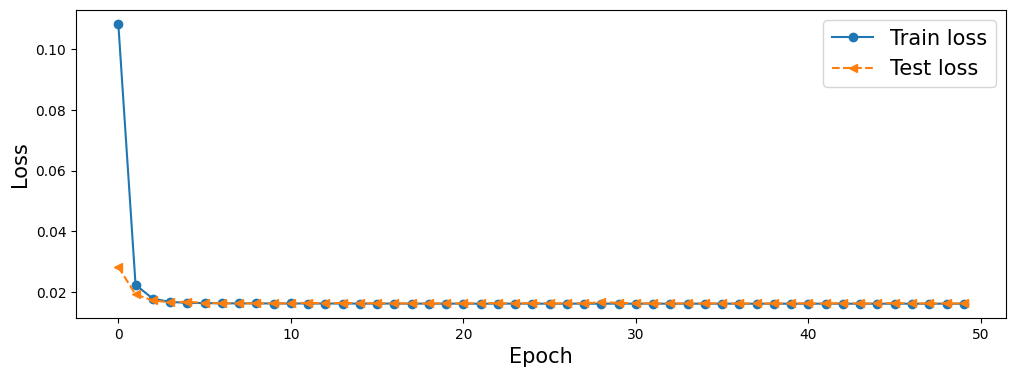

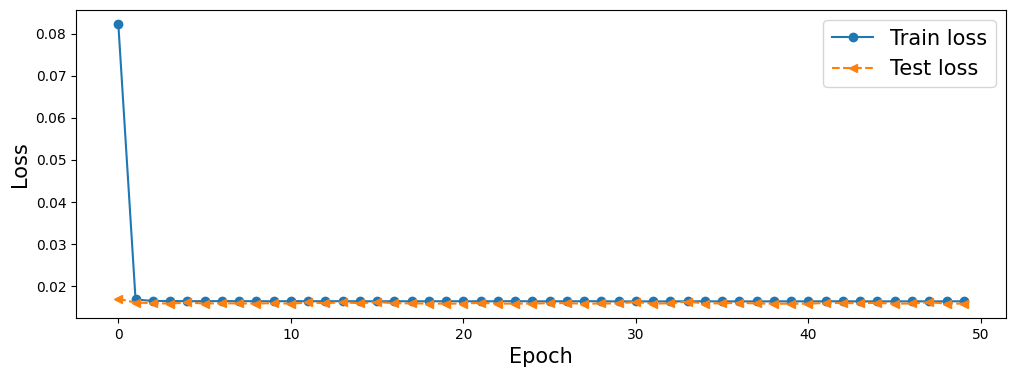

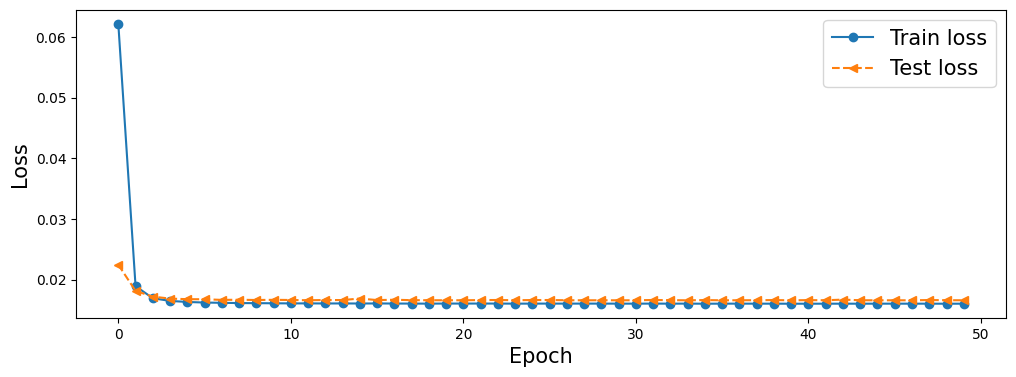

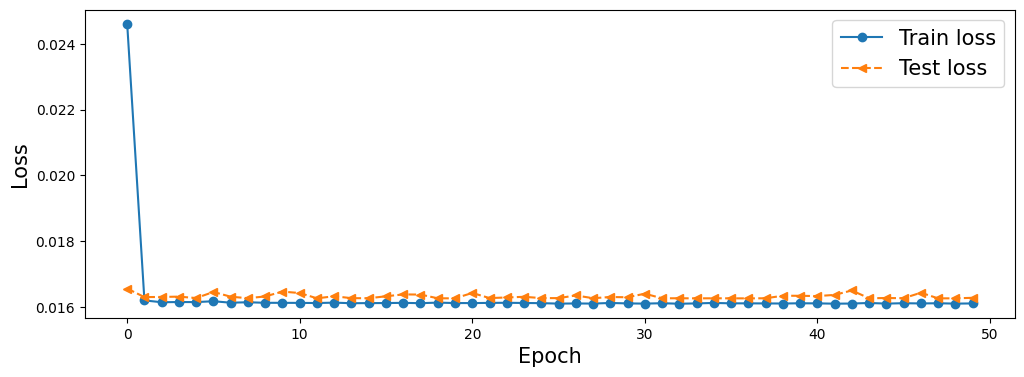

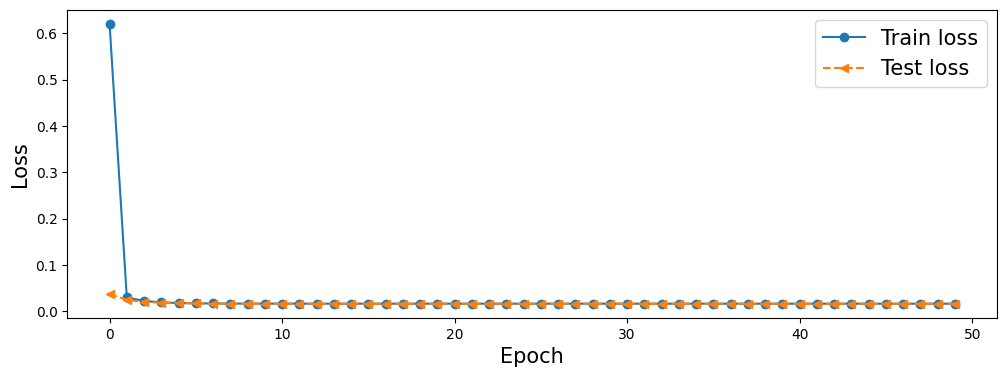

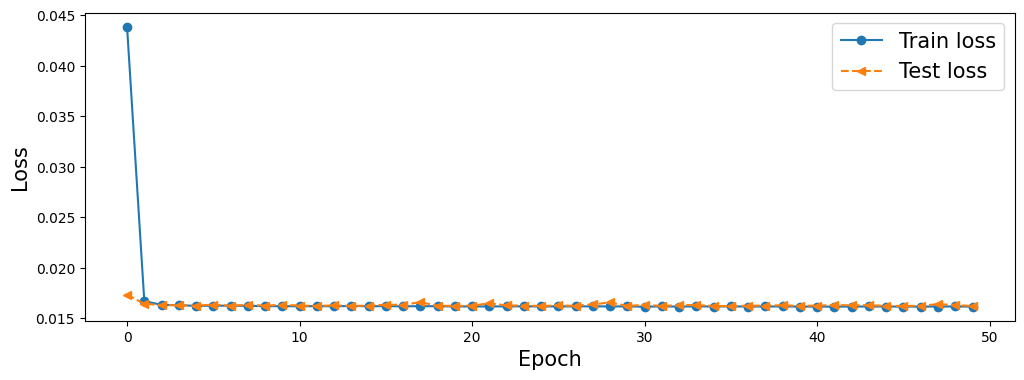

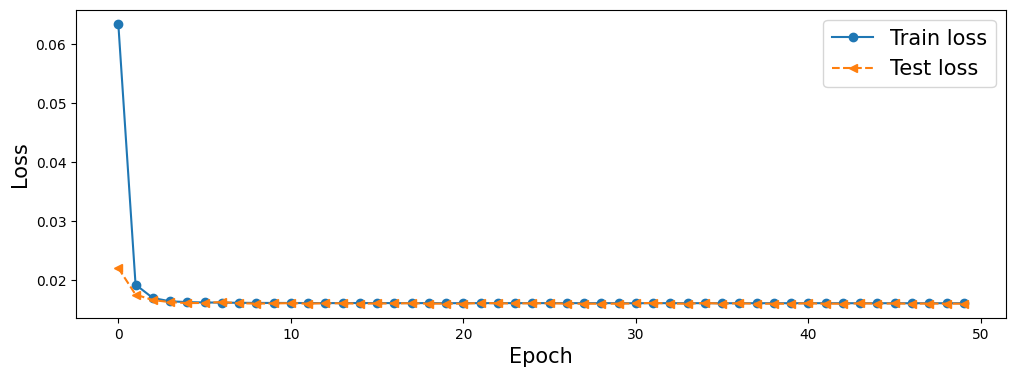

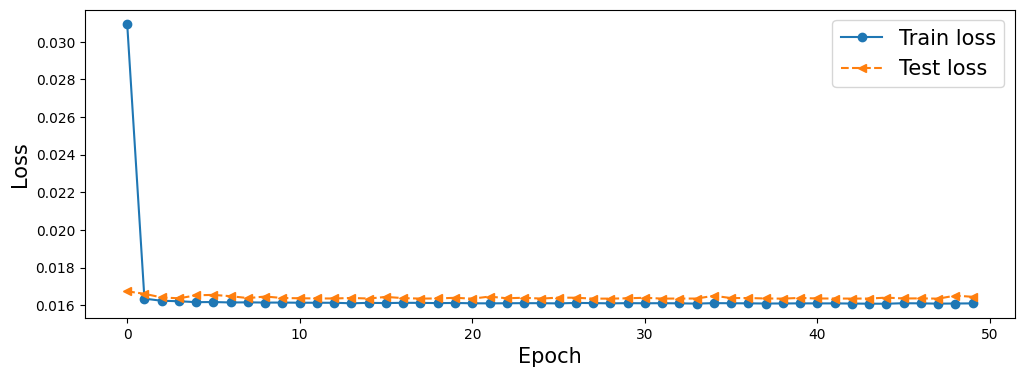

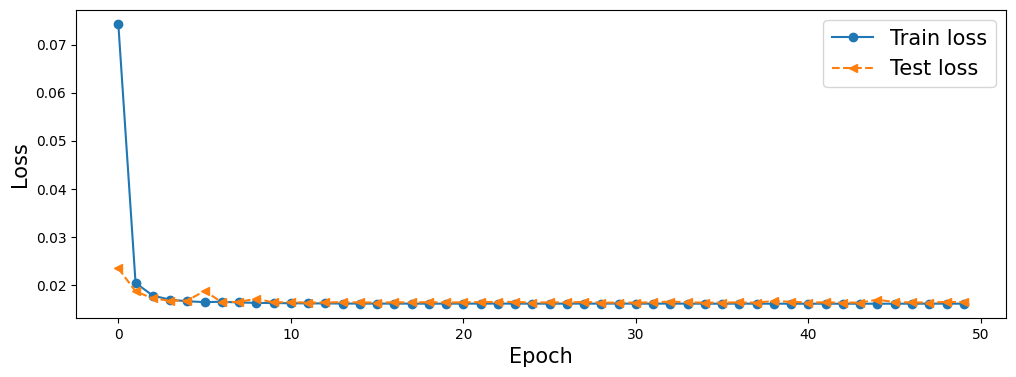

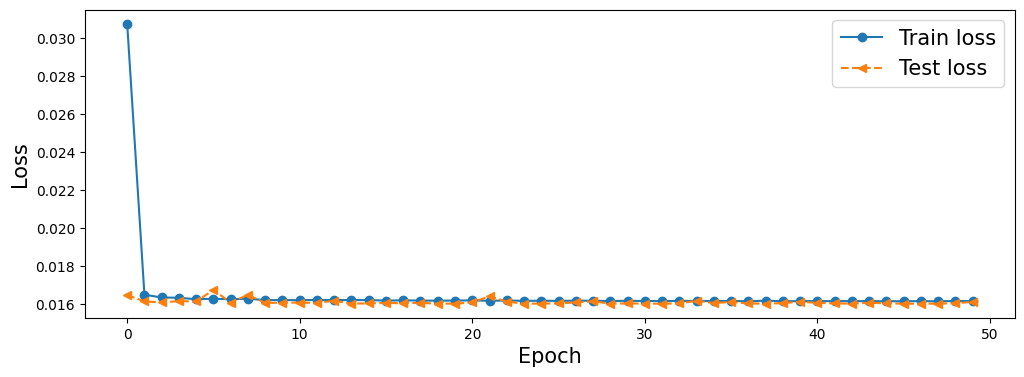

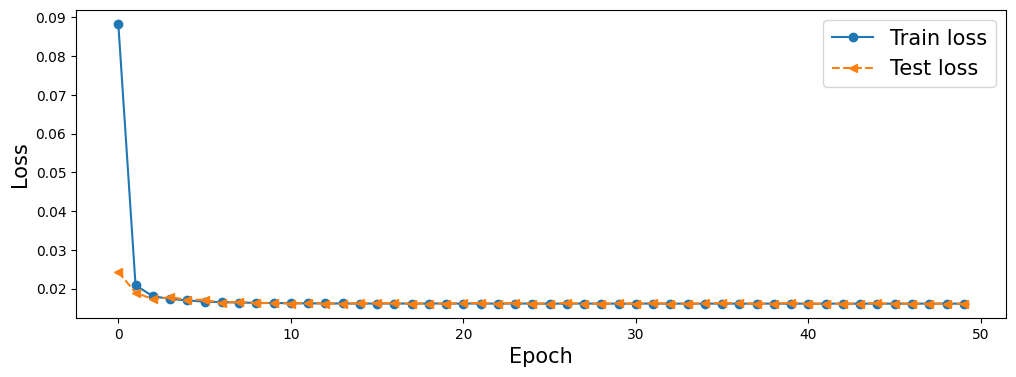

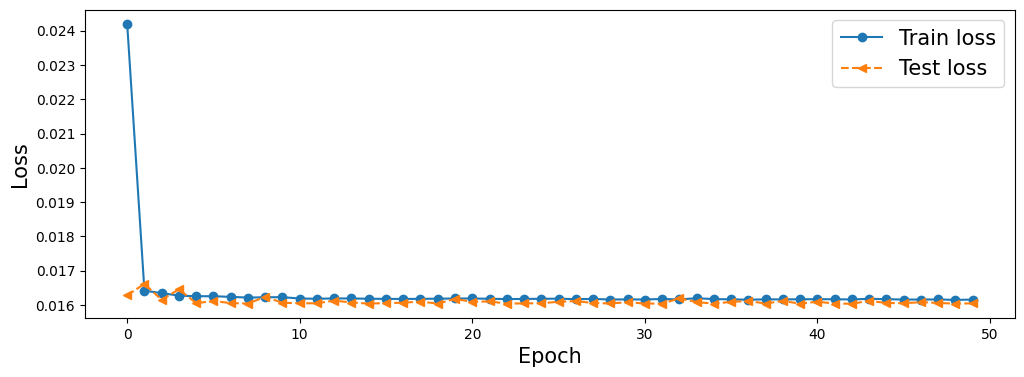

In [14]:
grid_search_nn_training_n(
    param_grid={
        'layers': [[10, 10], [20, 10], [30, 20]],
        'standardize': [True, False],
        'init_weight': [True, False]
    }
)

Training with standardize=True, filters=[16, 32], kernel_size=3
Epoch 1
-------------------------------
size: 37340


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 2.213159  [    0/37340]
loss: 0.036310  [ 3200/37340]
loss: 0.023091  [ 6400/37340]
loss: 0.033351  [ 9600/37340]
loss: 0.018342  [12800/37340]
loss: 0.026636  [16000/37340]
loss: 0.029770  [19200/37340]
loss: 0.019451  [22400/37340]
loss: 0.020218  [25600/37340]
loss: 0.036191  [28800/37340]
loss: 0.019407  [32000/37340]
loss: 0.018358  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.018104 

Epoch 1/50, Test Loss: 0.0181
Epoch 2
-------------------------------
size: 37340
loss: 0.022945  [    0/37340]
loss: 0.019315  [ 3200/37340]
loss: 0.021256  [ 6400/37340]
loss: 0.017494  [ 9600/37340]
loss: 0.025892  [12800/37340]
loss: 0.016473  [16000/37340]
loss: 0.019418  [19200/37340]
loss: 0.011148  [22400/37340]
loss: 0.020518  [25600/37340]
loss: 0.011440  [28800/37340]
loss: 0.020492  [32000/37340]
loss: 0.007117  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.018018 

Epoch 2/50, Test Loss: 0.0180
Epoch 3
-------------------------------
size: 37340
loss: 0.025242  [    0/37340]
loss: 0.022325  [ 3200/37340]
loss: 0.018454  [ 6400/37340]
loss: 0.016821  [ 9600/37340]
loss: 0.017682  [12800/37340]
loss: 0.021731  [16000/37340]
loss: 0.018252  [19200/37340]
loss: 0.023432  [22400/37340]
loss: 0.023197  [25600/37340]
loss: 0.026540  [28800/37340]
loss: 0.011480  [32000/37340]
loss: 0.020899  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.029239  [ 3200/37340]
loss: 0.037459  [ 6400/37340]
loss: 0.027298  [ 9600/37340]
loss: 0.036713  [12800/37340]
loss: 0.029977  [16000/37340]
loss: 0.023814  [19200/37340]
loss: 0.025035  [22400/37340]
loss: 0.016365  [25600/37340]
loss: 0.019432  [28800/37340]
loss: 0.031106  [32000/37340]
loss: 0.024628  [35200/37340]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.020455 

Epoch 1/50, Test Loss: 0.0205
Epoch 2
-------------------------------
size: 37340
loss: 0.023556  [    0/37340]
loss: 0.012789  [ 3200/37340]
loss: 0.017265  [ 6400/37340]
loss: 0.016949  [ 9600/37340]
loss: 0.020282  [12800/37340]
loss: 0.011774  [16000/37340]
loss: 0.011566  [19200/37340]
loss: 0.028262  [22400/37340]
loss: 0.015231  [25600/37340]
loss: 0.029130  [28800/37340]
loss: 0.021067  [32000/37340]
loss: 0.020521  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.018626 

Epoch 2/50, Test Loss: 0.0186
Epoch 3
-------------------------------
size: 37340
loss: 0.023213  [    0/37340]
loss: 0.013634  [ 3200/37340]
loss: 0.023221  [ 6400/37340]
loss: 0.014113  [ 9600/37340]
loss: 0.019612  [12800/37340]
loss: 0.014107  [16000/37340]
loss: 0.023393  [19200/37340]
loss: 0.018938  [22400/37340]
loss: 0.029131  [25600/37340]
loss: 0.020163  [28800/37340]
loss: 0.025382  [32000/37340]
loss: 0.030016  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.050725  [ 3200/37340]
loss: 0.051306  [ 6400/37340]
loss: 0.041109  [ 9600/37340]
loss: 0.031301  [12800/37340]
loss: 0.040606  [16000/37340]
loss: 0.023051  [19200/37340]
loss: 0.030049  [22400/37340]
loss: 0.030832  [25600/37340]
loss: 0.018641  [28800/37340]
loss: 0.024056  [32000/37340]
loss: 0.022697  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.019860 

Epoch 1/50, Test Loss: 0.0199
Epoch 2
-------------------------------
size: 37340
loss: 0.010983  [    0/37340]
loss: 0.020876  [ 3200/37340]
loss: 0.019654  [ 6400/37340]
loss: 0.017031  [ 9600/37340]
loss: 0.020039  [12800/37340]
loss: 0.010236  [16000/37340]
loss: 0.033308  [19200/37340]
loss: 0.012416  [22400/37340]
loss: 0.008815  [25600/37340]
loss: 0.015065  [28800/37340]
loss: 0.026590  [32000/37340]
loss: 0.018642  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.017905 

Epoch 2/50, Test Loss: 0.0179
Epoch 3
-------------------------------
size: 37340
loss: 0.015660  [    0/37340]
loss: 0.027512  [ 3200/37340]
loss: 0.012684  [ 6400/37340]
loss: 0.013186  [ 9600/37340]
loss: 0.009443  [12800/37340]
loss: 0.009028  [16000/37340]
loss: 0.016380  [19200/37340]
loss: 0.023151  [22400/37340]
loss: 0.024589  [25600/37340]
loss: 0.020679  [28800/37340]
loss: 0.014665  [32000/37340]
loss: 0.030107  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.063184  [ 3200/37340]
loss: 0.034509  [ 6400/37340]
loss: 0.029950  [ 9600/37340]
loss: 0.033905  [12800/37340]
loss: 0.029608  [16000/37340]
loss: 0.028918  [19200/37340]
loss: 0.030074  [22400/37340]
loss: 0.021579  [25600/37340]
loss: 0.022733  [28800/37340]
loss: 0.026300  [32000/37340]
loss: 0.014370  [35200/37340]
size: 9336


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Error: 
 Avg loss: 0.022003 

Epoch 1/50, Test Loss: 0.0220
Epoch 2
-------------------------------
size: 37340
loss: 0.022339  [    0/37340]
loss: 0.020644  [ 3200/37340]
loss: 0.020583  [ 6400/37340]
loss: 0.033159  [ 9600/37340]
loss: 0.015885  [12800/37340]
loss: 0.021207  [16000/37340]
loss: 0.035507  [19200/37340]
loss: 0.013321  [22400/37340]
loss: 0.021351  [25600/37340]
loss: 0.026888  [28800/37340]
loss: 0.019783  [32000/37340]
loss: 0.022967  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 0.020733 

Epoch 2/50, Test Loss: 0.0207
Epoch 3
-------------------------------
size: 37340
loss: 0.017764  [    0/37340]
loss: 0.020512  [ 3200/37340]
loss: 0.021674  [ 6400/37340]
loss: 0.024285  [ 9600/37340]
loss: 0.018966  [12800/37340]
loss: 0.022852  [16000/37340]
loss: 0.019794  [19200/37340]
loss: 0.038524  [22400/37340]
loss: 0.014905  [25600/37340]
loss: 0.019083  [28800/37340]
loss: 0.012456  [32000/37340]
loss: 0.022417  [35200/37340]
size: 9336
Test Error: 
 Avg loss: 

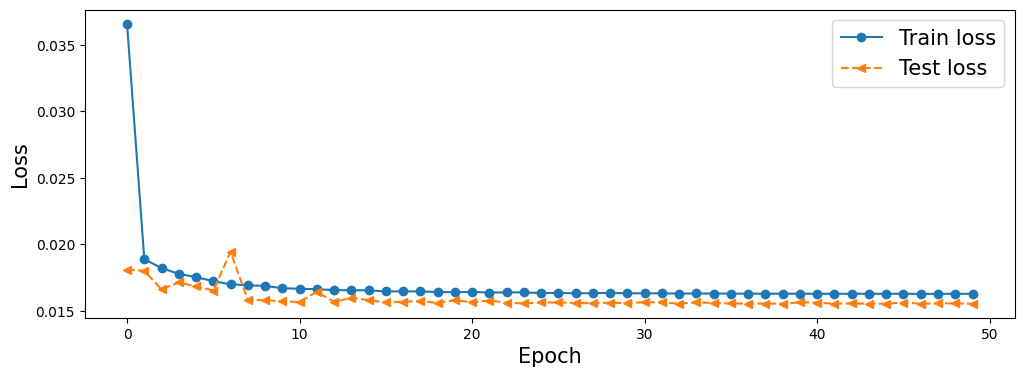

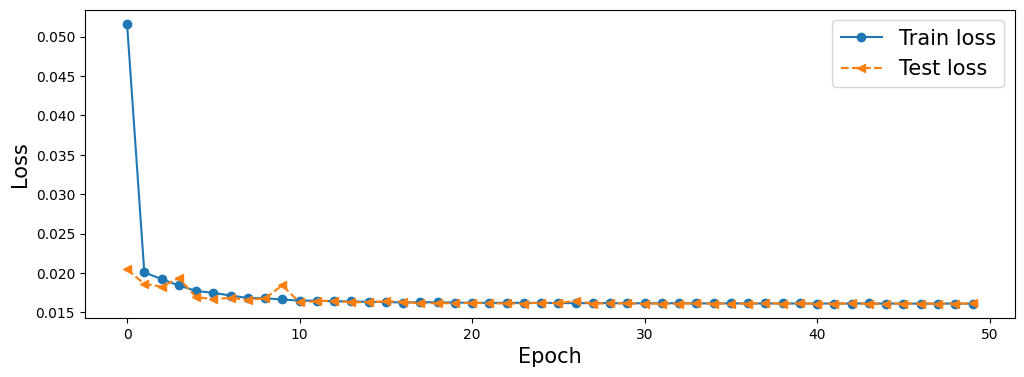

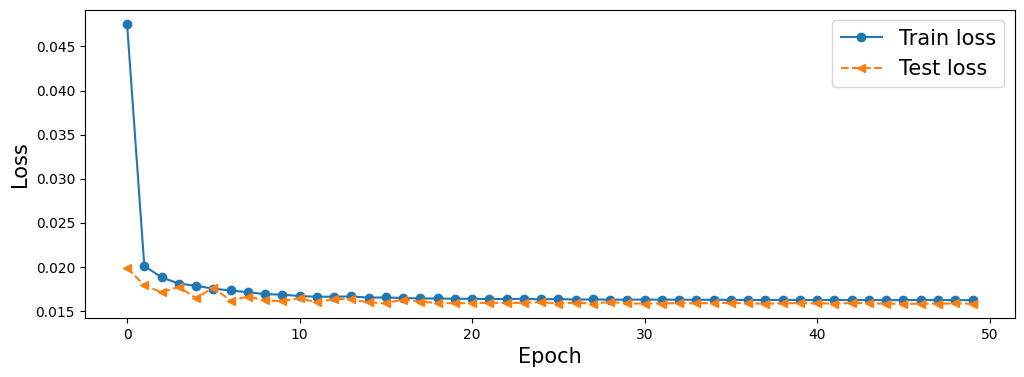

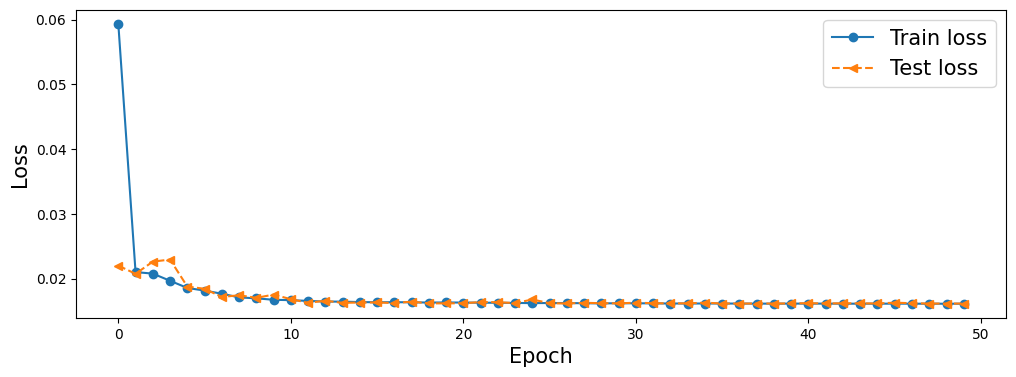

In [16]:
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# 你的 nn_training_cnn 函数在这里 (假设它像之前的回复中定义的那样)

def grid_search_cnn(data, param_grid, num_epochs=50):  # num_epochs 现在是固定参数
    """
    为 CNN 模型执行网格搜索。

    参数:
        data: 包含训练数据的 DataFrame。
        param_grid: 包含网格搜索的参数网格的字典。
        num_epochs: 固定训练轮数

    返回:
        best_params: 包含网格搜索中找到的最佳参数的字典。
        best_model: 具有最佳参数的已训练 CNN 模型。
        best_results: 包含最佳模型的性能指标的字典。
    """
    best_score = float('inf')  # 初始化为一个高值以进行最小化
    best_params = {}
    best_model = None
    best_results = {}

    for standardize in param_grid['standardize']:
        for filters in param_grid['filters']:
            for kernel_size in param_grid['kernel_size']:
                print(f"Training with standardize={standardize}, filters={filters}, kernel_size={kernel_size}")
                try:  # 添加 try-except 块来处理潜在的异常
                    test_indices, predictions = nn_training_cnn(
                        data=data,
                        num_epochs=num_epochs,  # 使用固定的 num_epochs
                        filters=filters,
                        kernel_size=kernel_size,
                        standardize=standardize  # 添加 standardize 参数
                    )

                    # 评估模型 (你可以选择你自己的评估指标)
                    mse = mean_squared_error(predictions.iloc[:, -2], predictions['Call Option Price Prediction'])

                    if mse < best_score:
                        best_score = mse
                        best_params = {
                            'standardize': standardize,
                            'filters': filters,
                            'kernel_size': kernel_size
                        }
                        # best_model = model  # 正确存储最佳模型(如果nn_training_cnn返回模型的话)
                        best_results = {
                            'mse': mse,
                            'rmse': np.sqrt(mse),
                            'mae': mean_absolute_error(predictions.iloc[:, -2], predictions['Call Option Price Prediction']),
                            'r2': r2_score(predictions.iloc[:, -2], predictions['Call Option Price Prediction'])
                        }
                except Exception as e: # 捕获任何异常
                    print(f"An error occurred during training: {e}")
                    continue # 跳过当前参数组合

    print(f"Best Parameters: {best_params}")
    print(f"Best Results: {best_results}")

    return best_params, best_model, best_results

# 示例用法
param_grid = {
    'standardize': [True, False],
    'filters': [[16, 32], [32, 64]],
    'kernel_size': [3, 5]
}

# 假设 'heston_simulated' 是你的 DataFrame
best_params, best_model, best_results = grid_search_cnn(heston_simulated, param_grid)

In [ ]:
heston_simulated_prediction_huber_n['Call Option Price Prediction'].describe()

count    10000.000000
mean         0.758528
std          0.003012
min          0.751874
25%          0.757238
50%          0.760473
75%          0.760664
max          0.760664
Name: Call Option Price Prediction, dtype: float64

Epoch 1
-------------------------------
size: 282916
loss: 0.918543  [    0/282916]
loss: 0.220808  [ 3200/282916]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.045371  [ 6400/282916]
loss: 0.035483  [ 9600/282916]
loss: 0.021443  [12800/282916]
loss: 0.023807  [16000/282916]
loss: 0.018029  [19200/282916]
loss: 0.027446  [22400/282916]
loss: 0.047764  [25600/282916]
loss: 0.009044  [28800/282916]
loss: 0.020044  [32000/282916]
loss: 0.036978  [35200/282916]
loss: 0.011121  [38400/282916]
loss: 0.012391  [41600/282916]
loss: 0.015684  [44800/282916]
loss: 0.009687  [48000/282916]
loss: 0.016019  [51200/282916]
loss: 0.010309  [54400/282916]
loss: 0.016357  [57600/282916]
loss: 0.008998  [60800/282916]
loss: 0.010953  [64000/282916]
loss: 0.023246  [67200/282916]
loss: 0.015133  [70400/282916]
loss: 0.023973  [73600/282916]
loss: 0.017133  [76800/282916]
loss: 0.011518  [80000/282916]
loss: 0.011887  [83200/282916]
loss: 0.022435  [86400/282916]
loss: 0.016586  [89600/282916]
loss: 0.033813  [92800/282916]
loss: 0.024891  [96000/282916]
loss: 0.012601  [99200/282916]
loss: 0.014967  [102400/282916]
loss: 0.015400  [105600/282916]
loss: 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


流式输出内容被截断，只能显示最后 5000 行内容。
loss: 0.010815  [195200/282916]
loss: 0.020866  [198400/282916]
loss: 0.030401  [201600/282916]
loss: 0.022169  [204800/282916]
loss: 0.007723  [208000/282916]
loss: 0.008372  [211200/282916]
loss: 0.010597  [214400/282916]
loss: 0.014667  [217600/282916]
loss: 0.018470  [220800/282916]
loss: 0.011414  [224000/282916]
loss: 0.019454  [227200/282916]
loss: 0.021007  [230400/282916]
loss: 0.015645  [233600/282916]
loss: 0.021203  [236800/282916]
loss: 0.015108  [240000/282916]
loss: 0.007988  [243200/282916]
loss: 0.015744  [246400/282916]
loss: 0.035911  [249600/282916]
loss: 0.010154  [252800/282916]
loss: 0.023593  [256000/282916]
loss: 0.009533  [259200/282916]
loss: 0.006752  [262400/282916]
loss: 0.011148  [265600/282916]
loss: 0.009810  [268800/282916]
loss: 0.014723  [272000/282916]
loss: 0.016724  [275200/282916]
loss: 0.014442  [278400/282916]
loss: 0.015520  [281600/282916]
size: 70730
Test Error: 
 Avg loss: 0.016077 

Epoch 24/50, Test Loss: 0.0161

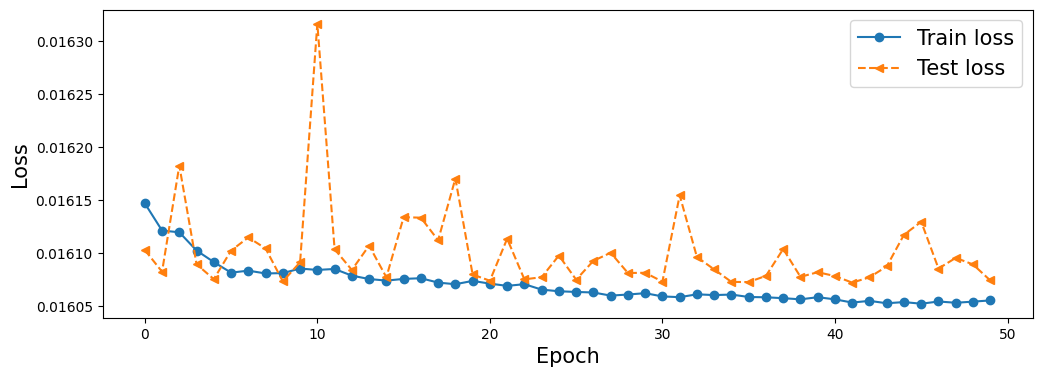

In [ ]:
returned_values_mse = nn_training(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion = nn.MSELoss(), node_1 = 10, node_2 = 10, standardize = False, init_weight = False)
heston_simulated_prediction_mse = returned_values_mse[1]
test_indice_mse = returned_values_mse[0]

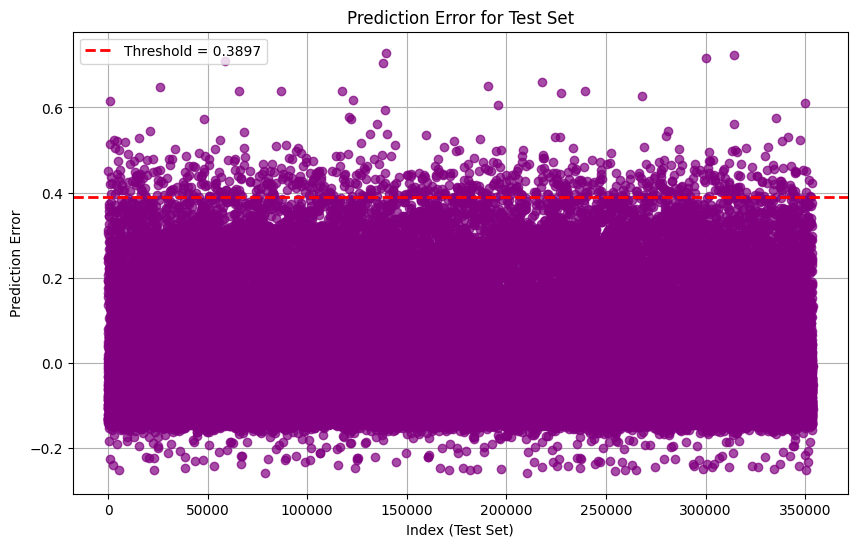

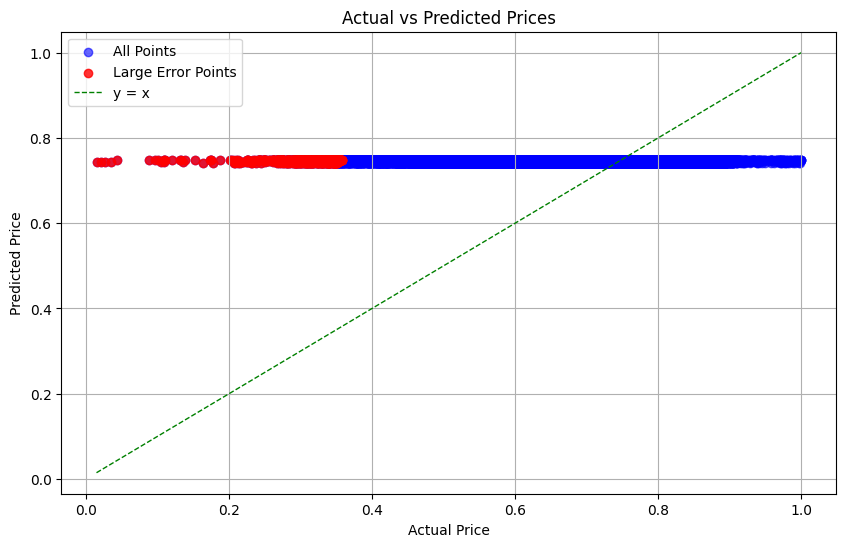

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness               -1.672652e-18               0.540870
Time to maturity        -6.695633e-18              -0.712719
interest rate            7.373735e-18              -0.601731
divident yield          -4.978778e-17               0.368487
initial vol              1.667629e-18              -0.205757
long term expected vol   3.476405e-17              -1.062369
vol revert rate         -1.896677e-17               0.540182
vol of vol               3.053972e-18              -0.022792
correlation of W and W  -1.029711e-17              -0.022312
Call Option Price        7.474048e-01               0.307057


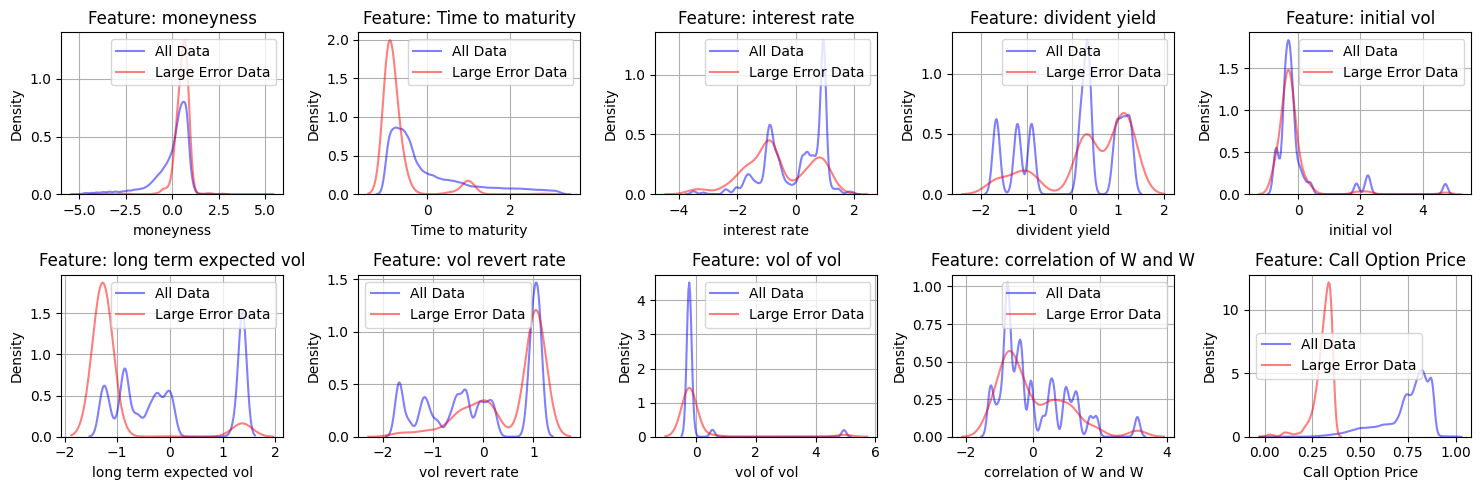

Correlation with Prediction Error:
moneyness                 0.071129
Time to maturity         -0.244482
interest rate            -0.059475
divident yield            0.010291
initial vol              -0.035111
long term expected vol   -0.114194
vol revert rate           0.134368
vol of vol               -0.011638
correlation of W and W    0.001682
Call Option Price        -0.623477
dtype: float64


In [ ]:
result_evaluation(data = heston_simulated_prediction_mse, test_indices = test_indice_mse)

Epoch 1
-------------------------------
size: 282916
loss: 0.319692  [    0/282916]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


loss: 0.110338  [ 3200/282916]
loss: 0.049624  [ 6400/282916]
loss: 0.035091  [ 9600/282916]
loss: 0.031516  [12800/282916]
loss: 0.026277  [16000/282916]
loss: 0.026303  [19200/282916]
loss: 0.016284  [22400/282916]
loss: 0.015989  [25600/282916]
loss: 0.014708  [28800/282916]
loss: 0.010611  [32000/282916]
loss: 0.008775  [35200/282916]
loss: 0.011016  [38400/282916]
loss: 0.008409  [41600/282916]
loss: 0.011199  [44800/282916]
loss: 0.011247  [48000/282916]
loss: 0.008421  [51200/282916]
loss: 0.008122  [54400/282916]
loss: 0.008621  [57600/282916]
loss: 0.007522  [60800/282916]
loss: 0.012959  [64000/282916]
loss: 0.006813  [67200/282916]
loss: 0.008816  [70400/282916]
loss: 0.009586  [73600/282916]
loss: 0.006274  [76800/282916]
loss: 0.011665  [80000/282916]
loss: 0.007872  [83200/282916]
loss: 0.011202  [86400/282916]
loss: 0.008638  [89600/282916]
loss: 0.007802  [92800/282916]
loss: 0.006643  [96000/282916]
loss: 0.009128  [99200/282916]
loss: 0.010787  [102400/282916]
loss: 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


size: 70730


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


流式输出内容被截断，只能显示最后 5000 行内容。
loss: 0.008300  [195200/282916]
loss: 0.008379  [198400/282916]
loss: 0.009144  [201600/282916]
loss: 0.004387  [204800/282916]
loss: 0.009694  [208000/282916]
loss: 0.006977  [211200/282916]
loss: 0.008538  [214400/282916]
loss: 0.007741  [217600/282916]
loss: 0.007636  [220800/282916]
loss: 0.011870  [224000/282916]
loss: 0.005041  [227200/282916]
loss: 0.010156  [230400/282916]
loss: 0.010003  [233600/282916]
loss: 0.011417  [236800/282916]
loss: 0.004088  [240000/282916]
loss: 0.004168  [243200/282916]
loss: 0.006348  [246400/282916]
loss: 0.010856  [249600/282916]
loss: 0.022669  [252800/282916]
loss: 0.006091  [256000/282916]
loss: 0.009406  [259200/282916]
loss: 0.007505  [262400/282916]
loss: 0.012202  [265600/282916]
loss: 0.010674  [268800/282916]
loss: 0.009139  [272000/282916]
loss: 0.010099  [275200/282916]
loss: 0.006535  [278400/282916]
loss: 0.010766  [281600/282916]
size: 70730
Test Error: 
 Avg loss: 0.008134 

Epoch 24/50, Test Loss: 0.0081

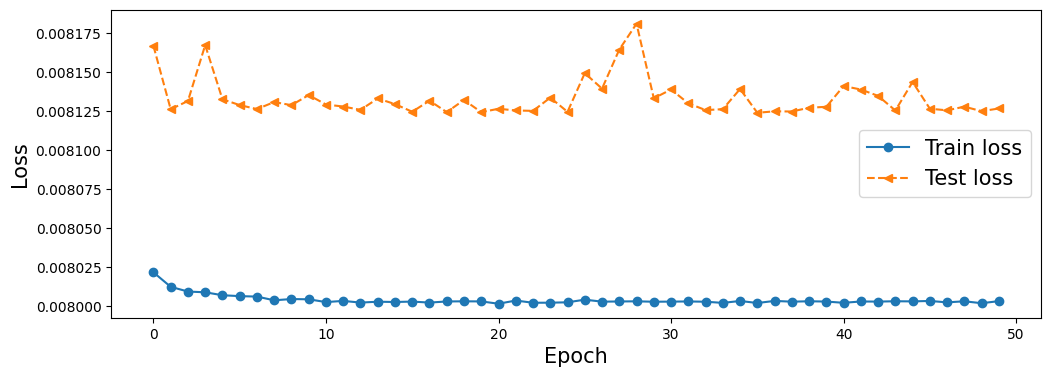

In [ ]:
returned_values_huber = nn_training(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion = nn.HuberLoss(delta=1.0), node_1 = 10, node_2 = 10, standardize = True, init_weight = True)
heston_simulated_prediction_huber = returned_values_huber[1]
test_indice_huber = returned_values_huber[0]

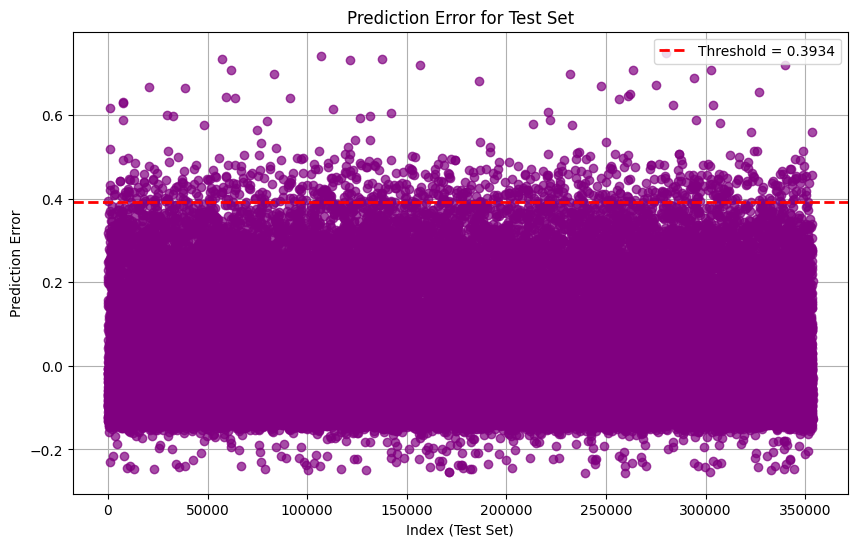

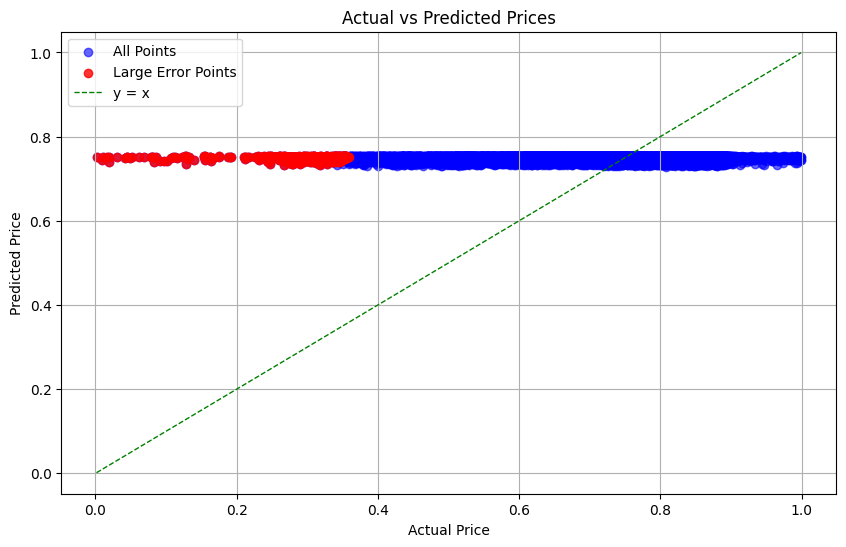

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness               -1.672652e-18               0.519320
Time to maturity        -6.374162e-18              -0.661448
interest rate            7.253183e-18              -0.711071
divident yield          -3.986237e-17               0.416879
initial vol             -3.295075e-18              -0.226940
long term expected vol   2.557701e-17              -1.021302
vol revert rate         -1.575207e-17               0.536122
vol of vol               3.053972e-18               0.056858
correlation of W and W  -9.895271e-18               0.091415
Call Option Price        7.474048e-01               0.299009


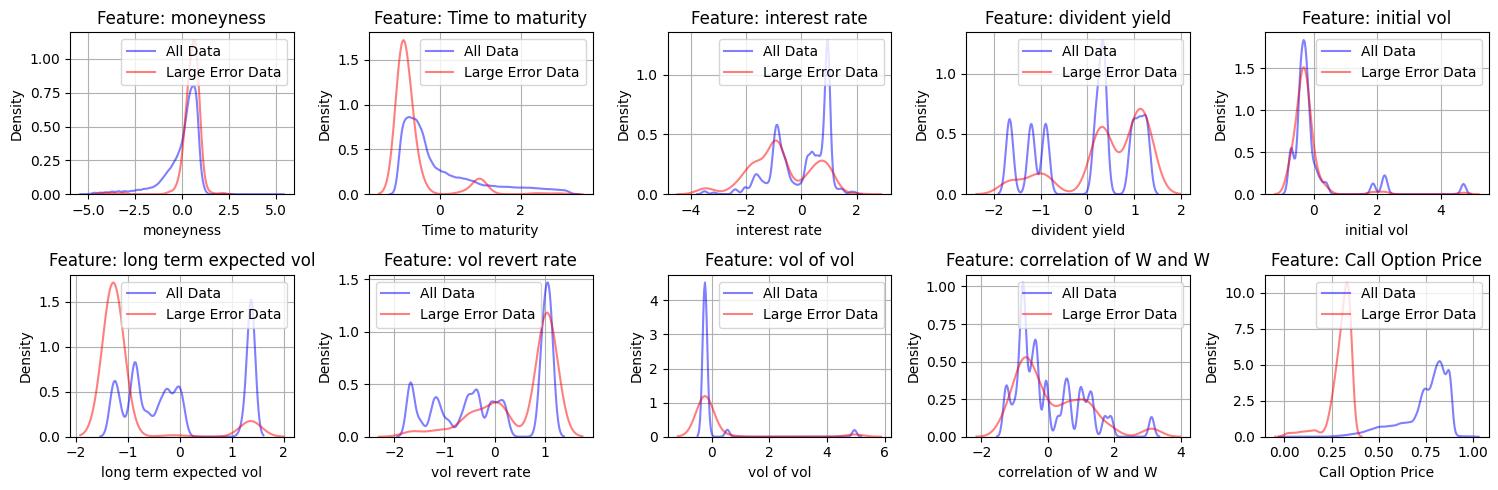

Correlation with Prediction Error:
moneyness                 0.072702
Time to maturity         -0.231012
interest rate            -0.070852
divident yield            0.023328
initial vol              -0.036758
long term expected vol   -0.138037
vol revert rate           0.125597
vol of vol               -0.014896
correlation of W and W    0.006355
Call Option Price        -0.650716
dtype: float64


In [ ]:
result_evaluation(heston_simulated_prediction_huber, test_indices = test_indice_huber)

In [ ]:
# Convert df to tabular
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

class TabularDataset(Dataset):
    def __init__(self, dataframe):
        self.data = torch.tensor(dataframe.iloc[:, :-1].values, dtype=torch.float32)
        self.targets = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

class RegressionModel_n(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        """
        Parameters:
        - input_size: 输入特征的维度
        - hidden_size: 每层隐藏层的神经元数量
        - num_layers: 隐藏层的数量（不包括输入层和输出层）
        """
        super(RegressionModel_n, self).__init__()
        self.num_layers = num_layers
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)
        ])

        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output_layer(x)
        return x

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print('size:',size)
    losses = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        losses += loss.item() * y.size(0)/ size
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return losses

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    print('size:',size)

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() * y.size(0)/size

    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

# Training
def nn_training_n(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion = nn.MSELoss(), input_size=9, hidden_size=64, num_layers=5, standardize = True, init_weight = True):
  # whether standardize the data
  if standardize:
      scaler = StandardScaler()
      data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])
  dataset = TabularDataset(data)

  # Split the dataset into train and test sets
  train_size = int(train_test_split * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

  # DataLoader
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

  epochs = num_epochs
  train_losses = []
  test_losses = []

  #parameters
  model = RegressionModel_n(input_size=9, hidden_size=64, num_layers=5)
  if init_weight:
    def init_weights(m):
      if isinstance(m, nn.Linear):
          nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
          if m.bias is not None:
              nn.init.zeros_(m.bias)

    model.apply(init_weights)


  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss = train_loop(train_loader, model, criterion, optimizer)
      test_loss = test_loop(test_loader, model, criterion)
      train_losses.append(train_loop(train_loader, model, criterion, optimizer))
      test_losses.append(test_loop(test_loader, model, criterion))
      print(f"Epoch {t+1}/{epochs}, Test Loss: {test_loss:.4f}")
  print("Done!")

  # Loss plot
  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1, 1, 1)
  ax.plot(range(epochs),train_losses, '-o', label='Train loss')
  ax.plot(range(epochs),test_losses, '--<', label='Test loss')

  ax.set_xlabel('Epoch', size=15)
  ax.set_ylabel('Loss', size=15)
  ax.legend(fontsize=15)

  # Prediction & Comparision
  def predict(model, dataloader):
      model.eval()
      predictions = []
      with torch.no_grad():
          for X, _ in dataloader:
              pred = model(X).squeeze()
              predictions.extend(pred.tolist())
      return predictions

  predicted_prices = predict(model, test_loader)
  test_indices = test_dataset.indices
  actual_prices = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_indices]
  errors = np.abs(np.array(actual_prices) - np.array(predicted_prices))

  heston_simulated_test = heston_simulated.iloc[test_indices].copy()
  heston_simulated_test['Call Option Price Prediction'] = predicted_prices
  heston_simulated_prediction = heston_simulated_test.reset_index(drop=True)
  return test_indices, heston_simulated_prediction

Epoch 1
-------------------------------
size: 282916
loss: 0.755004  [    0/282916]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


loss: 0.021533  [ 3200/282916]
loss: 0.017815  [ 6400/282916]
loss: 0.015900  [ 9600/282916]
loss: 0.012673  [12800/282916]
loss: 0.013890  [16000/282916]
loss: 0.009501  [19200/282916]
loss: 0.007164  [22400/282916]
loss: 0.010190  [25600/282916]
loss: 0.011158  [28800/282916]
loss: 0.010094  [32000/282916]
loss: 0.008618  [35200/282916]
loss: 0.008553  [38400/282916]
loss: 0.008405  [41600/282916]
loss: 0.009895  [44800/282916]
loss: 0.008175  [48000/282916]
loss: 0.012703  [51200/282916]
loss: 0.006956  [54400/282916]
loss: 0.005641  [57600/282916]
loss: 0.008211  [60800/282916]
loss: 0.006141  [64000/282916]
loss: 0.007690  [67200/282916]
loss: 0.010437  [70400/282916]
loss: 0.008528  [73600/282916]
loss: 0.005866  [76800/282916]
loss: 0.010123  [80000/282916]
loss: 0.008690  [83200/282916]
loss: 0.006406  [86400/282916]
loss: 0.007110  [89600/282916]
loss: 0.009111  [92800/282916]
loss: 0.013704  [96000/282916]
loss: 0.005764  [99200/282916]
loss: 0.002775  [102400/282916]
loss: 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


流式输出内容被截断，只能显示最后 5000 行内容。
loss: 0.006249  [195200/282916]
loss: 0.008517  [198400/282916]
loss: 0.007831  [201600/282916]
loss: 0.008407  [204800/282916]
loss: 0.007903  [208000/282916]
loss: 0.007501  [211200/282916]
loss: 0.008121  [214400/282916]
loss: 0.008227  [217600/282916]
loss: 0.014826  [220800/282916]
loss: 0.004515  [224000/282916]
loss: 0.007603  [227200/282916]
loss: 0.004241  [230400/282916]
loss: 0.005542  [233600/282916]
loss: 0.007084  [236800/282916]
loss: 0.010814  [240000/282916]
loss: 0.008458  [243200/282916]
loss: 0.010349  [246400/282916]
loss: 0.007596  [249600/282916]
loss: 0.005604  [252800/282916]
loss: 0.007116  [256000/282916]
loss: 0.007027  [259200/282916]
loss: 0.005651  [262400/282916]
loss: 0.008832  [265600/282916]
loss: 0.004578  [268800/282916]
loss: 0.008861  [272000/282916]
loss: 0.007517  [275200/282916]
loss: 0.007864  [278400/282916]
loss: 0.009065  [281600/282916]
size: 70730
Test Error: 
 Avg loss: 0.007997 

Epoch 24/50, Test Loss: 0.0080

NameError: name 'result_evaluation' is not defined

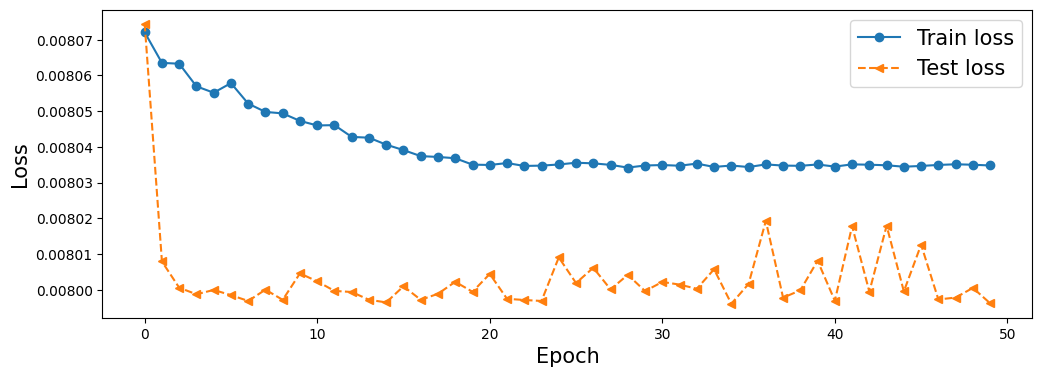

In [ ]:
returned_values_huber_n = nn_training_n(data=heston_simulated, train_test_split=0.8, num_epochs=50, criterion = nn.HuberLoss(delta=1.0), input_size=9, hidden_size=64, num_layers=5, standardize = True, init_weight = True)
heston_simulated_prediction_huber_n = returned_values_huber_n[1]
test_indice_huber_n = returned_values_huber_n[0]
result_evaluation(heston_simulated_prediction_huber_n, test_indices = test_indice_huber_n)

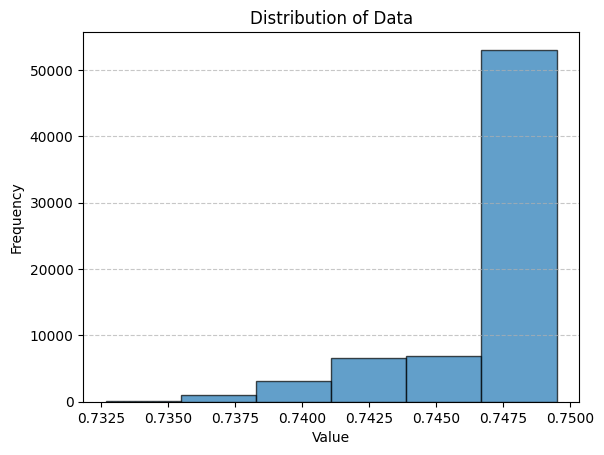

In [ ]:
pred=list(heston_simulated_prediction_huber_n['Call Option Price Prediction'])
plt.hist(pred, bins=6, edgecolor='black', alpha=0.7)
plt.title("Distribution of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

70730

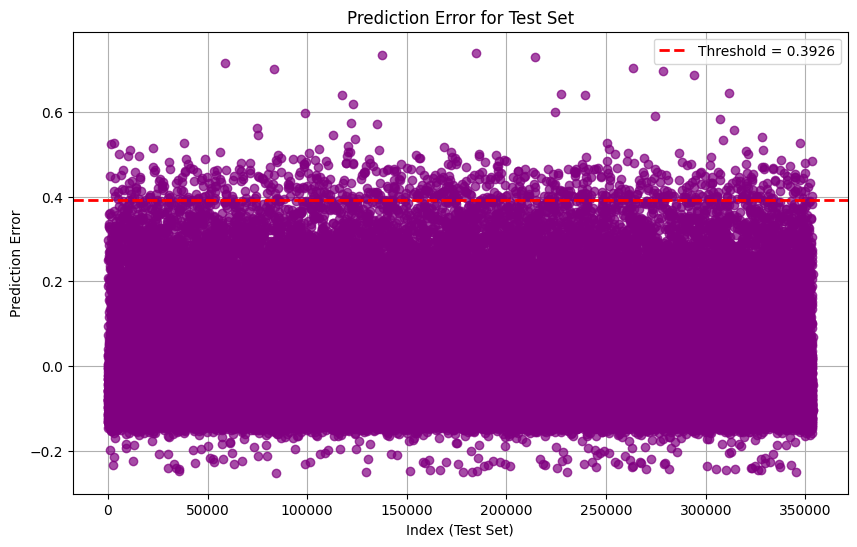

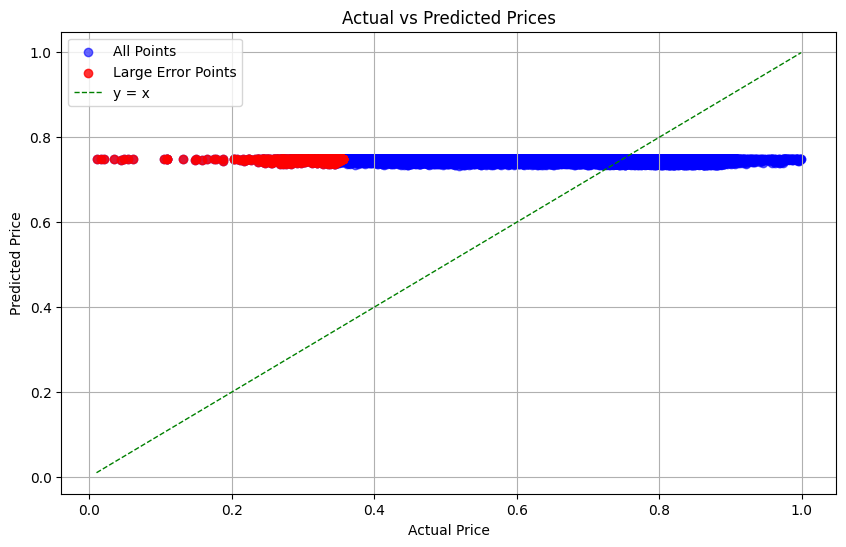

Feature Means Comparison:
                        All Data Mean  Large Error Data Mean
moneyness               -1.672652e-18               0.495751
Time to maturity        -6.695633e-18              -0.736139
interest rate            7.373735e-18              -0.605189
divident yield          -4.978778e-17               0.335503
initial vol              1.667629e-18              -0.205918
long term expected vol   3.476405e-17              -1.101202
vol revert rate         -1.896677e-17               0.520988
vol of vol               3.053972e-18               0.094375
correlation of W and W  -1.029711e-17               0.054729
Call Option Price        7.474048e-01               0.308162


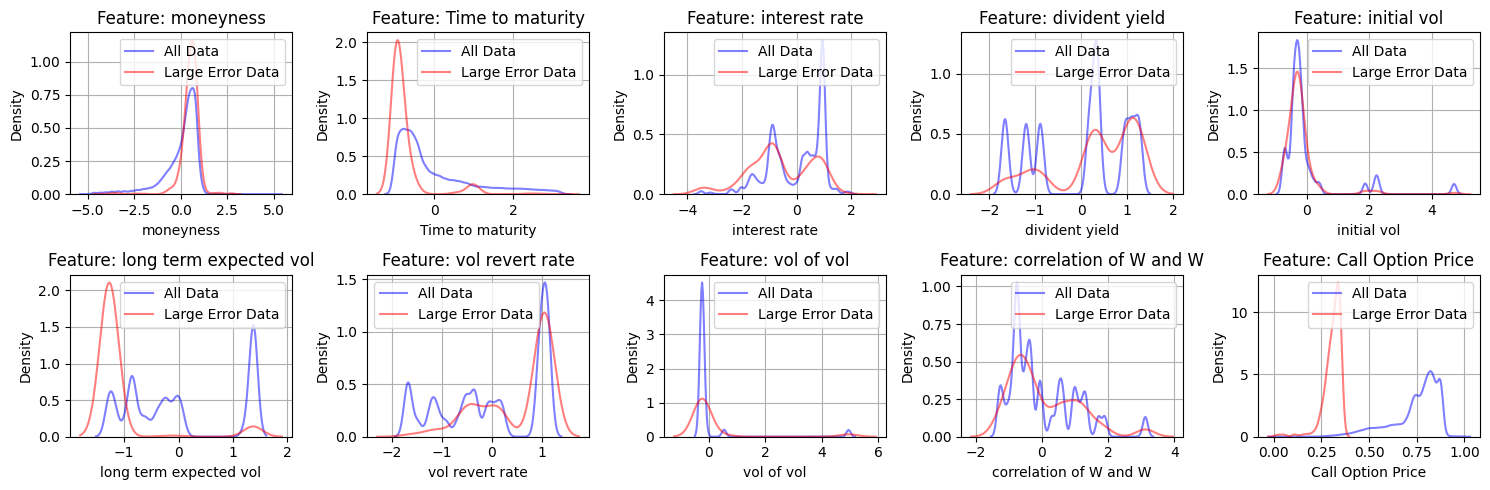

Correlation with Prediction Error:
moneyness                 0.073608
Time to maturity         -0.246991
interest rate            -0.062278
divident yield            0.016148
initial vol              -0.028849
long term expected vol   -0.126085
vol revert rate           0.130451
vol of vol               -0.009893
correlation of W and W    0.007846
Call Option Price        -0.633623
dtype: float64


In [ ]:
result_evaluation(heston_simulated_prediction_huber_n, test_indices = test_indice_huber_n)

改进：  
1.数据中是否存在极值（inf,nan） ————> 归一化标准化，去除极端值等预处理  
2.学习率过高 ————>random search  
3.权重初始化 ————> 用合理的初始化方法，如 Xavier 或 He 初始化  
4.梯度爆炸  
打印每次反向传播后的梯度：  
for param in model.parameters():  
    print(param.grad.norm().item())  
使用梯度裁剪（Gradient Clipping）来限制梯度的大小  
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)



Call Option Price 的相关系数接近1，这表明预测误差几乎完全由期权价格的大小驱动。  
可能的原因是模型对期权价格本身的变化捕捉得不够准确。例如，期权价格越大，可能越难准确预测。  
优化方向：可以针对高价格的期权进行分段建模或调整损失函数（如引入加权损失），来降低高价期权对整体误差的影响。

In [ ]:
import pandas as pd
import numpy as np

# 预测集 DataFrame
heston_simulated_test = heston_simulated.iloc[test_indices].copy()
heston_simulated_test['Call Option Price Prediction'] = predicted_prices
heston_simulated_prediction = heston_simulated_test.reset_index(drop=True)
heston_simulated_prediction

moneyness  Time to maturity  interest rate  divident yield  \
0       0.883635            129.00       0.052565          0.0166   
1       0.828280             18.00       0.045700          0.0172   
2       0.904269             73.00       0.052163          0.0166   
3       0.994953             27.00       0.055400          0.0153   
4       0.846276             11.00       0.047000          0.0172   
...          ...               ...            ...             ...   
70725   0.964748             19.00       0.047400          0.0172   
70726   0.996464              5.00       0.039500          0.0172   
70727   1.051822            114.96       0.047440          0.0171   
70728   0.905090             15.00       0.046600          0.0170   
70729   0.942518             57.00       0.055470          0.0156   

       initial vol  long term expected vol  vol revert rate    vol of vol  \
0         0.173578                0.967624         0.109203  1.000000e-10   
1         0.199351                0.696114         0.527390  4.829867e-06   
2         0.173142                0.029380         0.578677  4.032324e-06   
3         0.218994                0.967624         0.054130  8.518853e-05   
4         0.245998                0.809239         0.448631  4.429184e-06   
...            ...                     ...              ...           ...   
70725     0.197350                0.004207         0.207476  2.445759e-05   
70726     0.184452                1.012215         0.867167  4.829867e-06   
70727     0.245998                0.696114         0.877774  3.092682e-05   
70728     0.410673                1.999866         0.867167  9.620556e-06   
70729     0.173390                0.004207         0.880482  6.461707e-06   

       correlation of W and W  Call Option Price  Call Option Price Prediction  
0                    0.014899           0.763200                      0.756351  
1                    0.013355           0.796233                      0.756351  
2                    0.014458           0.534781                      0.756351  
3                    0.031290           0.784386                      0.756351  
4                    0.013823           0.769314                      0.756351  
...                       ...                ...                           ...  
70725                0.016572           0.447124                      0.747054  
70726                0.014308           0.660521                      0.756351  
70727                0.009006           0.771761                      0.756351  
70728                0.026009           0.883719                      0.756351  
70729                0.039103           0.489800                      0.756351  

[70730 rows x 11 columns]

In [ ]:
heston_simulated_prediction['Call Option Price Prediction'].describe()

count    70730.000000
mean         0.754879
std          0.002506
min          0.742038
25%          0.754883
50%          0.756351
75%          0.756351
max          0.756351
Name: Call Option Price Prediction, dtype: float64

In [ ]:
heston_simulated_prediction['Call Option Price'].describe()

count    70730.000000
mean         0.747353
std          0.127126
min          0.010457
25%          0.703183
50%          0.786414
75%          0.837180
max          0.999829
Name: Call Option Price, dtype: float64

In [ ]:
# Convert df to tabular
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

class TabularDataset(Dataset):
    def __init__(self, dataframe):
        self.data = torch.tensor(dataframe.iloc[:, :-1].values, dtype=torch.float32)
        self.targets = torch.tensor(dataframe.iloc[:, -1].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

dataset = TabularDataset(heston_simulated)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

class RegressionModel(nn.Module):
    def __init__(self,node_number1,node_number2):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(9, node_number1) # fc: fully connected layer
        self.fc2 = nn.Linear(node_number1, node_number2)
        self.fc3 = nn.Linear(node_number2, 1)  # Output is a single value (regression)

    def forward(self, x):
        '''it cant fit non-linear data'''
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

criterion = nn.HuberLoss(delta=1.0)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 使用 Adam 优化器

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    print('size:',size)
    losses = 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        losses += loss.item() * y.size(0)/ size
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return losses

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    print('size:',size)

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item() * y.size(0)/size

    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

# Training
epochs = 50
train_losses = []
test_losses = []

#parameters
model = RegressionModel(10,10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_loader, model, criterion, optimizer)
    test_loss = test_loop(test_loader, model, criterion)
    train_losses.append(train_loop(train_loader, model, criterion, optimizer))
    test_losses.append(test_loop(test_loader, model, criterion))
    print(f"Epoch {t+1}/{epochs}, Test Loss: {test_loss:.4f}")
print("Done!")

Epoch 1
-------------------------------
size: 282916
loss: 0.498442  [    0/282916]


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


loss: 0.131863  [ 3200/282916]
loss: 0.040156  [ 6400/282916]
loss: 0.014984  [ 9600/282916]
loss: 0.018130  [12800/282916]
loss: 0.007074  [16000/282916]
loss: 0.010434  [19200/282916]
loss: 0.009973  [22400/282916]
loss: 0.008660  [25600/282916]
loss: 0.009738  [28800/282916]
loss: 0.011080  [32000/282916]
loss: 0.007733  [35200/282916]
loss: 0.010316  [38400/282916]
loss: 0.009593  [41600/282916]
loss: 0.005706  [44800/282916]
loss: 0.011011  [48000/282916]
loss: 0.004708  [51200/282916]
loss: 0.009985  [54400/282916]
loss: 0.009664  [57600/282916]
loss: 0.008249  [60800/282916]
loss: 0.003802  [64000/282916]
loss: 0.004797  [67200/282916]
loss: 0.006745  [70400/282916]
loss: 0.007564  [73600/282916]
loss: 0.009586  [76800/282916]
loss: 0.007185  [80000/282916]
loss: 0.008766  [83200/282916]
loss: 0.006523  [86400/282916]
loss: 0.005321  [89600/282916]
loss: 0.007167  [92800/282916]
loss: 0.004118  [96000/282916]
loss: 0.006706  [99200/282916]
loss: 0.005547  [102400/282916]
loss: 0

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:1100: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


流式输出内容被截断，只能显示最后 5000 行内容。
loss: 0.007436  [195200/282916]
loss: 0.010625  [198400/282916]
loss: 0.007571  [201600/282916]
loss: 0.013814  [204800/282916]
loss: 0.011219  [208000/282916]
loss: 0.012830  [211200/282916]
loss: 0.007691  [214400/282916]
loss: 0.006801  [217600/282916]
loss: 0.008618  [220800/282916]
loss: 0.009457  [224000/282916]
loss: 0.004207  [227200/282916]
loss: 0.004308  [230400/282916]
loss: 0.003219  [233600/282916]
loss: 0.005900  [236800/282916]
loss: 0.005646  [240000/282916]
loss: 0.012284  [243200/282916]
loss: 0.005721  [246400/282916]
loss: 0.004340  [249600/282916]
loss: 0.004519  [252800/282916]
loss: 0.005344  [256000/282916]
loss: 0.006751  [259200/282916]
loss: 0.004181  [262400/282916]
loss: 0.009098  [265600/282916]
loss: 0.007382  [268800/282916]
loss: 0.008861  [272000/282916]
loss: 0.003436  [275200/282916]
loss: 0.007094  [278400/282916]
loss: 0.007527  [281600/282916]
size: 70730
Test Error: 
 Avg loss: 0.008002 

Epoch 24/50, Test Loss: 0.0080

In [ ]:
# 分段建模&加权损失函数
class DynamicRegressionModel(nn.Module):
    def __init__(self, input_size, node_number1, node_number2):
        super(DynamicRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, node_number1)  # 动态输入特征数
        self.fc2 = nn.Linear(node_number1, node_number2)
        self.fc3 = nn.Linear(node_number2, 1)  # 输出为单个值

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class WeightedMSELoss(nn.Module):
    def __init__(self, weight_function):
        super(WeightedMSELoss, self).__init__()
        self.weight_function = weight_function  # 自定义权重函数

    def forward(self, predictions, targets):
        # 计算权重
        weights = self.weight_function(targets)
        # 加权 MSE 损失
        loss = torch.mean(weights * (predictions - targets) ** 2)
        return loss
def price_weight_function(targets):
    return 1 + (targets / targets.max())

def train_segmented_models_with_weights_new_model(heston_simulated, price_threshold, node_number1, node_number2, epochs=50):
    """
    分段建模：低价期权使用普通损失函数，高价期权使用加权损失函数，使用新的 DynamicRegressionModel
    """
    low_price_data = heston_simulated[heston_simulated['Call Option Price'] <= price_threshold]
    high_price_data = heston_simulated[heston_simulated['Call Option Price'] > price_threshold]
    low_price_dataset = TabularDataset(low_price_data)
    high_price_dataset = TabularDataset(high_price_data)

    train_low_size = int(0.8 * len(low_price_dataset))
    test_low_size = len(low_price_dataset) - train_low_size
    train_low_dataset, test_low_dataset = torch.utils.data.random_split(low_price_dataset, [train_low_size, test_low_size])

    train_high_size = int(0.8 * len(high_price_dataset))
    test_high_size = len(high_price_dataset) - train_high_size
    train_high_dataset, test_high_dataset = torch.utils.data.random_split(high_price_dataset, [train_high_size, test_high_size])

    train_low_loader = DataLoader(train_low_dataset, batch_size=32, shuffle=True)
    test_low_loader = DataLoader(test_low_dataset, batch_size=32, shuffle=True)
    train_high_loader = DataLoader(train_high_dataset, batch_size=32, shuffle=True)
    test_high_loader = DataLoader(test_high_dataset, batch_size=32, shuffle=True)

    input_size = heston_simulated.shape[1] - 1  # 获取特征数
    low_price_model = DynamicRegressionModel(input_size=input_size, node_number1=node_number1, node_number2=node_number2)
    high_price_model = DynamicRegressionModel(input_size=input_size, node_number1=node_number1, node_number2=node_number2)

    low_optimizer = torch.optim.Adam(low_price_model.parameters(), lr=0.001)
    high_optimizer = torch.optim.Adam(high_price_model.parameters(), lr=0.001)

    weighted_criterion = WeightedMSELoss(price_weight_function)  # 加权损失函数

    return low_price_model, high_price_model, train_low_loader, test_low_loader, train_high_loader, test_high_loader, low_optimizer, high_optimizer

# 调用函数并获取模型和 DataLoader
low_model_new, high_model_new, train_low_loader, test_low_loader, train_high_loader, test_high_loader, low_optimizer, high_optimizer = train_segmented_models_with_weights_new_model(
    heston_simulated=heston_simulated,
    price_threshold=threshold,
    node_number1=10,
    node_number2=10,
    epochs=50
)

weighted_criterion = WeightedMSELoss(price_weight_function)
train_low_losses = []
test_low_losses = []
train_high_losses = []
test_high_losses = []

# 开始训练
for t in range(epochs):
    print(f"Training Low Price Model - Epoch {t+1}")
    train_loss = train_loop(train_low_loader, low_model_new, criterion, low_optimizer)
    test_loss = test_loop(test_low_loader, low_model_new, criterion)
    train_low_losses.append(train_loss)
    test_low_losses.append(test_loss)
    print(f"Epoch {t+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

for t in range(epochs):
    print(f"Training High Price Model with Weighted Loss - Epoch {t+1}")
    train_loss = train_loop(train_high_loader, high_model_new, weighted_criterion, high_optimizer)
    test_loss = test_loop(test_high_loader, high_model_new, criterion)
    train_high_losses.append(train_loss)
    test_high_losses.append(test_loss)
    print(f"Epoch {t+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

print("Training Completed!")

Training Low Price Model - Epoch 1
size: 764
loss: 0.087800  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000137 

Epoch 1, Train Loss: 0.0260, Test Loss: 0.0001
Training Low Price Model - Epoch 2
size: 764
loss: 0.000136  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000278 

Epoch 2, Train Loss: 0.0009, Test Loss: 0.0003
Training Low Price Model - Epoch 3
size: 764
loss: 0.000303  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000144 

Epoch 3, Train Loss: 0.0001, Test Loss: 0.0001
Training Low Price Model - Epoch 4
size: 764
loss: 0.000158  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000087 

Epoch 4, Train Loss: 0.0001, Test Loss: 0.0001
Training Low Price Model - Epoch 5
size: 764
loss: 0.000097  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000088 

Epoch 5, Train Loss: 0.0001, Test Loss: 0.0001
Training Low Price Model - Epoch 6
size: 764
loss: 0.000080  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000082 

Epoch 6, Train Loss: 0.0001, Test Loss: 0.000

/Users/yina1114/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/yina1114/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


size: 192
Test Error: 
 Avg loss: 0.000080 

Epoch 7, Train Loss: 0.0001, Test Loss: 0.0001
Training Low Price Model - Epoch 8
size: 764
loss: 0.000051  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000077 

Epoch 8, Train Loss: 0.0001, Test Loss: 0.0001
Training Low Price Model - Epoch 9
size: 764
loss: 0.000062  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000073 

Epoch 9, Train Loss: 0.0001, Test Loss: 0.0001
Training Low Price Model - Epoch 10
size: 764
loss: 0.000085  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000071 

Epoch 10, Train Loss: 0.0001, Test Loss: 0.0001
Training Low Price Model - Epoch 11
size: 764
loss: 0.000048  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000069 

Epoch 11, Train Loss: 0.0001, Test Loss: 0.0001
Training Low Price Model - Epoch 12
size: 764
loss: 0.000065  [    0/  764]
size: 192
Test Error: 
 Avg loss: 0.000067 

Epoch 12, Train Loss: 0.0001, Test Loss: 0.0001
Training Low Price Model - Epoch 13
size: 764
loss: 0.000045  [    

/Users/yina1114/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.000983  [    0/   89]
size: 23
Test Error: 
 Avg loss: 0.000441 

Epoch 5, Train Loss: 0.0007, Test Loss: 0.0004
Training High Price Model with Weighted Loss - Epoch 6
size: 89
loss: 0.000700  [    0/   89]
size: 23
Test Error: 
 Avg loss: 0.000522 

Epoch 6, Train Loss: 0.0007, Test Loss: 0.0005
Training High Price Model with Weighted Loss - Epoch 7
size: 89
loss: 0.000690  [    0/   89]
size: 23
Test Error: 
 Avg loss: 0.000589 

Epoch 7, Train Loss: 0.0007, Test Loss: 0.0006
Training High Price Model with Weighted Loss - Epoch 8
size: 89
loss: 0.000838  [    0/   89]
size: 23
Test Error: 
 Avg loss: 0.000615 

Epoch 8, Train Loss: 0.0008, Test Loss: 0.0006
Training High Price Model with Weighted Loss - Epoch 9
size: 89
loss: 0.000849  [    0/   89]
size: 23
Test Error: 
 Avg loss: 0.000595 

Epoch 9, Train Loss: 0.0008, Test Loss: 0.0006
Training High Price Model with Weighted Loss - Epoch 10
size: 89
loss: 0.000896  [    0/   89]
size: 23
Test Error: 
 Avg loss: 0.000549 



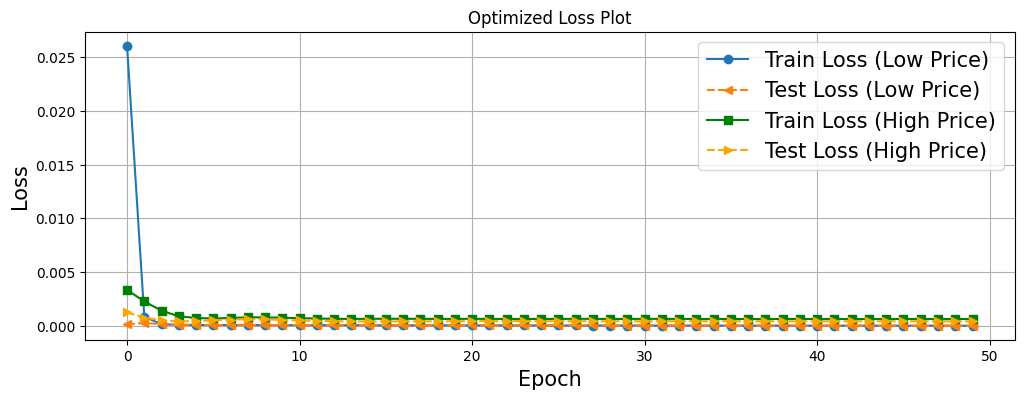

In [ ]:
# 优化后的 Loss plot
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(range(epochs), train_low_losses, '-o', label='Train Loss (Low Price)')
ax.plot(range(epochs), test_low_losses, '--<', label='Test Loss (Low Price)')
ax.plot(range(epochs), train_high_losses, '-s', label='Train Loss (High Price)', color='green')
ax.plot(range(epochs), test_high_losses, '-->', label='Test Loss (High Price)', color='orange')

ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax.set_title("Optimized Loss Plot")
plt.grid()
plt.show()


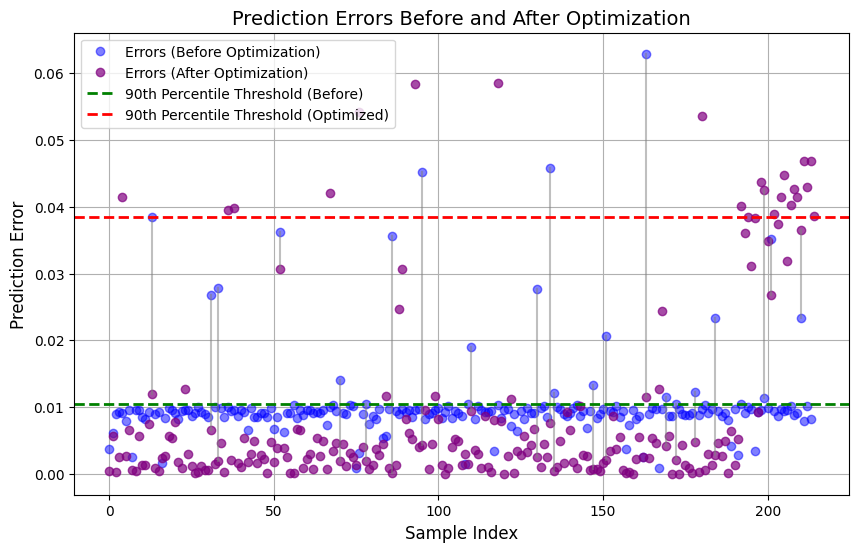

In [ ]:
# 优化后的 Prediction & Comparison
def predict_optimized(low_model, high_model, test_low_loader, test_high_loader):
    """
    使用低价和高价模型分别预测测试集的价格
    """
    low_model.eval()
    high_model.eval()

    low_predictions = []
    high_predictions = []

    with torch.no_grad():
        for X, _ in test_low_loader:
            pred = low_model(X).squeeze()
            low_predictions.extend(pred.tolist())

        for X, _ in test_high_loader:
            pred = high_model(X).squeeze()
            high_predictions.extend(pred.tolist())

    return low_predictions, high_predictions

low_predicted_prices, high_predicted_prices = predict_optimized(
    low_model_new, high_model_new, test_low_loader, test_high_loader
)

low_actual_prices = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_low_loader.dataset.indices]
high_actual_prices = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_high_loader.dataset.indices]

all_actual_prices = low_actual_prices + high_actual_prices
all_predicted_prices = low_predicted_prices + high_predicted_prices

errors_optimized = np.abs(np.array(all_actual_prices) - np.array(all_predicted_prices))

predicted_prices_before = predict(model, test_loader)
actual_prices_before = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_dataset.indices]
errors_before = np.abs(np.array(actual_prices_before) - np.array(predicted_prices_before))

threshold_before = np.percentile(errors_before, 90)

large_error_indices = np.where(errors_before > threshold_before)[0]

plt.figure(figsize=(10, 6))

plt.plot(range(len(errors_before)), errors_before, 'o', color='blue', alpha=0.5, label='Errors (Before Optimization)')

plt.plot(range(len(errors_optimized)), errors_optimized, 'o', color='purple', alpha=0.7, label='Errors (After Optimization)')

for i in large_error_indices:
    plt.plot([i, i], [errors_before[i], errors_optimized[i]], color='gray', linestyle='-', alpha=0.5)

plt.axhline(y=threshold_before, color='green', linestyle='--', linewidth=2, label='90th Percentile Threshold (Before)')
plt.axhline(y=np.percentile(errors_optimized, 90), color='red', linestyle='--', linewidth=2, label='90th Percentile Threshold (Optimized)')

plt.xlabel('Sample Index', size=12)
plt.ylabel('Prediction Error', size=12)
plt.title('Prediction Errors Before and After Optimization', size=14)
plt.legend()
plt.grid()
plt.show()

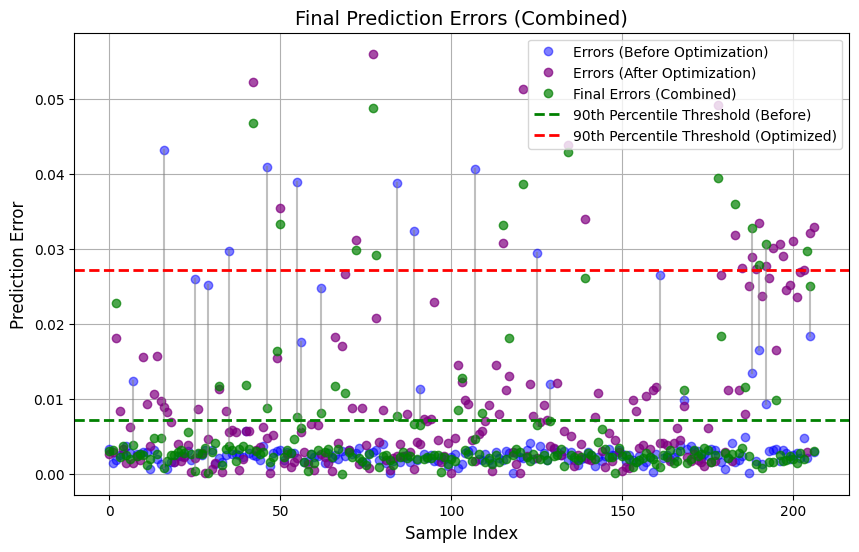

In [ ]:
# 保留优化前和优化后模型的预测值（对那些优化前在当时90thershold以下的点，保留优化前的模型的prediction，其它点保留优化后的模型的prediction）
def combine_predictions(model, low_model, high_model, test_loader, test_low_loader, test_high_loader, threshold_before):
    """
    对测试集的点进行筛选：
    - 优化前误差小于阈值的点，使用优化前模型的预测值
    - 优化前误差大于阈值的点，使用优化后模型的预测值
    """
    # 优化前模型的预测值
    predicted_prices_before = predict(model, test_loader)
    actual_prices = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_dataset.indices]
    errors_before = np.abs(np.array(actual_prices) - np.array(predicted_prices_before))

    # 优化后模型的预测值
    low_predicted_prices, high_predicted_prices = predict_optimized(low_model, high_model, test_low_loader, test_high_loader)
    low_actual_prices = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_low_loader.dataset.indices]
    high_actual_prices = [heston_simulated.iloc[idx]['Call Option Price'] for idx in test_high_loader.dataset.indices]
    all_actual_prices = low_actual_prices + high_actual_prices
    all_predicted_prices_optimized = low_predicted_prices + high_predicted_prices

    # 构造最终的预测值数组
    combined_predictions = []
    for i in range(len(errors_before)):
        if errors_before[i] <= threshold_before:
            # 使用优化前的预测值
            combined_predictions.append(predicted_prices_before[i])
        else:
            # 使用优化后的预测值
            combined_predictions.append(all_predicted_prices_optimized[i])

    return combined_predictions, all_actual_prices

# 调用函数并获取最终的预测值
threshold_before = np.percentile(errors_before, 90)
final_predictions, all_actual_prices = combine_predictions(
    model, low_model_new, high_model_new, test_loader, test_low_loader, test_high_loader, threshold_before
)

# 计算最终误差
final_errors = np.abs(np.array(all_actual_prices) - np.array(final_predictions))

# 绘制最终误差分布图
plt.figure(figsize=(10, 6))

# 优化前误差
plt.plot(range(len(errors_before)), errors_before, 'o', color='blue', alpha=0.5, label='Errors (Before Optimization)')

# 优化后误差
plt.plot(range(len(errors_optimized)), errors_optimized, 'o', color='purple', alpha=0.7, label='Errors (After Optimization)')

# 最终误差
plt.plot(range(len(final_errors)), final_errors, 'o', color='green', alpha=0.7, label='Final Errors (Combined)')

# 添加竖线连接优化前和最终的误差
large_error_indices = np.where(errors_before > threshold_before)[0]
for i in large_error_indices:
    plt.plot([i, i], [errors_before[i], final_errors[i]], color='gray', linestyle='-', alpha=0.5)

# 添加分界线
plt.axhline(y=threshold_before, color='green', linestyle='--', linewidth=2, label='90th Percentile Threshold (Before)')
plt.axhline(y=np.percentile(errors_optimized, 90), color='red', linestyle='--', linewidth=2, label='90th Percentile Threshold (Optimized)')

# 图形设置
plt.xlabel('Sample Index', size=12)
plt.ylabel('Prediction Error', size=12)
plt.title('Final Prediction Errors (Combined)', size=14)
plt.legend()
plt.grid()
plt.show()


In [ ]:
# reference: https://github.com/rasbt/machine-learning-book/blob/main/ch14/ch14_part1.ipynb
def train(model, loss_fn, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)

        loss_hist_valid[epoch] /= len(valid_dl.dataset)

    return loss_hist_train, loss_hist_valid
model = RegressionModel(10,10)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
hist = train(model, criterion, epochs, train_loader, test_loader)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([27])) that is different to the input size (torch.Size([27, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

### Grid Search

In [ ]:
# Additional Homework by Kamin At
# Can you implement grid search to achieve better test loss?
# Modified by: Kamin At

node_list_1=[6,8,10,12]
node_list_2=[6,8,10,12]
results=[]

for i in (node_list_1):
    for j in node_list_2:
        print(f"Training model with {i} input nodes and {j} hidden nodes.")
        model = RegressionModel(i, j)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        epochs = 20

        train_losses = []
        test_losses = []

        for t in range(epochs):
            train_loss = train_loop(train_loader, model, criterion, optimizer)
            test_loss = test_loop(test_loader, model, criterion)
            train_losses.append(train_loss)
            test_losses.append(test_loss)

        final_test_loss = test_losses[-1]
        results.append({'hidden_nodes1': i, 'hidden_nodes2': j, 'final_test_loss': final_test_loss})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='final_test_loss')

results_df

Training model with 6 input nodes and 6 hidden nodes.
size: 827
loss: 0.005587  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.002605 

size: 827
loss: 0.003419  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.001235 

size: 827
loss: 0.001472  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.000755 

size: 827
loss: 0.000712  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.000550 

size: 827
loss: 0.000511  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.000417 

size: 827
loss: 0.000341  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.000339 

size: 827
loss: 0.000278  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.000299 

size: 827
loss: 0.000175  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.000253 

size: 827
loss: 0.000342  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.000217 

size: 827
loss: 0.000209  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.000190 

size: 827
loss: 0.000118  [    0/  827]
size: 207
Test Error: 
 Avg loss: 0.000181 

size: 827
l

hidden_nodes1  hidden_nodes2  final_test_loss
14             12             10         0.000094
7               8             12         0.000097
3               6             12         0.000097
5               8              8         0.000099
11             10             12         0.000103
6               8             10         0.000103
10             10             10         0.000106
4               8              6         0.000112
13             12              8         0.000114
0               6              6         0.000126
12             12              6         0.000129
15             12             12         0.000134
2               6             10         0.000139
1               6              8         0.000240
8              10              6         0.000259
9              10              8         0.000274

Visualization

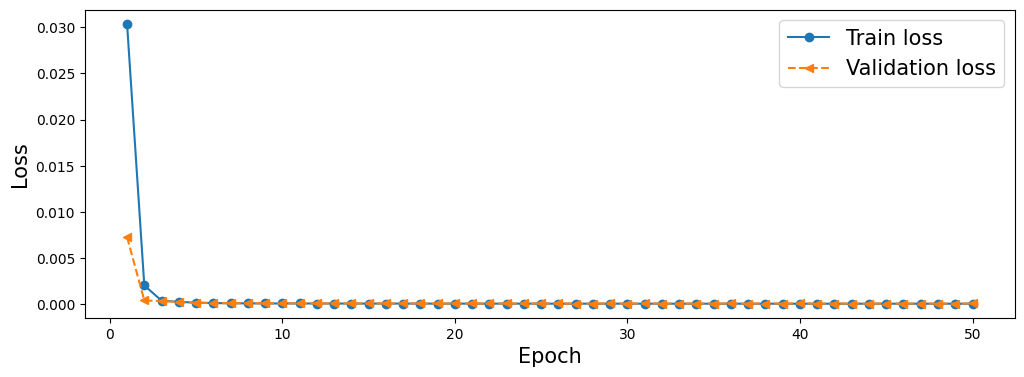

In [ ]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)


#plt.savefig('figures/14_13.png')
plt.show()

# Train model with Real-World Data